# Cole et al. (2021) fMRI data analysis

Analyses used in: 
Cole MW, Ito T, Cocuzza C, Sanchez-Romero R (In Press). "The functional relevance of task-state functional connectivity". Journal of Neuroscience. doi:10.1523/JNEUROSCI.1713-20.2021 https://doi.org/10.1523/JNEUROSCI.1713-20.2021

This makes heavy use of the Actflow Toolbox: https://colelab.github.io/ActflowToolbox/

Github repository for this code: https://github.com/ColeLab/TaskFCActflow_release

More information on the Cole Neurocognition Lab's work: https://www.colelab.org/

*Purpose of this project*: Test the advantages (and validity) of using task FC with activity flow mapping

In [1]:
#Load dependencies
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0, 'glmScripts/parcellated_postproc/')
import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp
import nuisanceRegressionPipeline_GlasserParcels as nrp
import os.path
import importlib
from functools import partial

import ActflowToolbox as actflow

#Useful for code development; reloads modules as files are changed
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams.update({'font.size': 14})
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['image.cmap'] = 'seismic'

#Set general variables
basedir='/projects/f_mc1689_1/TaskFCActflow/'
preprocdatadir=basedir+'/data/hcppreprocessedmsmall/parcellated_postproc/'
preprocdatadir_GLMs=basedir+'/data/hcppreprocessedmsmall/parcellated_postproc/'
preprocdatadir_vertexwise=basedir+'/data/hcppreprocessedmsmall/vertexWise/'
datadir=preprocdatadir
resultsdir=basedir+'data/results_final/'
figuredir=basedir+'/docs/figures/'

import multiprocessing as mp
numWorkers=mp.cpu_count()
print("Number of CPU cores available: "+str(numWorkers))
#numWorkers=int(round(numWorkers/2))
print("Number of CPU cores being used: "+str(numWorkers))


Number of CPU cores available: 20
Number of CPU cores being used: 20


In [2]:
print('Some version info:')
sm.show_versions()

Some version info:

INSTALLED VERSIONS
------------------
Python: 3.7.3.final.0
OS: Linux 3.10.0-1160.11.1.el7.x86_64 #1 SMP Fri Dec 18 16:34:56 UTC 2020 x86_64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.11.1 (/home/mc1689/.local/lib/python3.7/site-packages/statsmodels)

Required Dependencies

cython: 0.29.6 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/Cython)
numpy: 1.17.0 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/numpy)
scipy: 1.2.1 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/scipy)
pandas: 0.24.2 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/pandas)
    dateutil: 2.8.0 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/dateutil)
patsy: 0.5.1 (/home/mc1689/.local/lib/python3.7/site-packages/patsy)

Optional Dependencies

matplotlib: 3.0.3 (/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplot

In [3]:
#Data: HCP352 subjects (selected subset of S1200 HCP release)

subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832','154229','164939','175338','185139','194645','204622',
            '213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331',
            '154532','165638','175742','185341','195445','205119','213421','274542','341834',
            '393247','479762','545345','597869','664757','742549','820745','887373','989987',
            '102311','111009','118831','128632','135528','146432','154936','167036','176441',
            '186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932',
            '129028','135629','146533','156031','167440','176845','187850','196346','205826',
            '214423','285446','348545','395756','481042','553344','599671','675661','749058',
            '832651','899885','991267','102614','112920','119126','129129','135932','147636',
            '157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774',
            '103111','113316','120212','130013','136227','148133','157437','169545','178748',
            '188549','198451','208327','217429','290136','352738','414229','497865','559457',
            '615744','679770','753150','837560','907656','993675','103414','113619','120414',
            '130114','136833','150726','157942','171330']

### REPLICATION SUBJECTS
subjNums_replication = ['178950','189450','199453','209228','220721','298455','356948','419239','499566','561444','618952','680452','757764','841349','908860',
            '103818','113922','121618','130619','137229','151829','158035','171633','179346','190031','200008','210112','221319','299154','361234',
            '424939','500222','570243','622236','687163','769064','845458','911849','104416','114217','122317','130720','137532','151930','159744',
            '172029','180230','191235','200614','211316','228434','300618','361941','432332','513130','571144','623844','692964','773257','857263',
            '926862','105014','114419','122822','130821','137633','152427','160123','172938','180432','192035','200917','211417','239944','303119',
            '365343','436239','513736','579665','638049','702133','774663','865363','930449','106521','114823','123521','130922','137936','152831',
            '160729','173334','180533','192136','201111','211619','249947','305830','366042','436845','516742','580650','645450','715041','782561',
            '871762','942658','106824','117021','123925','131823','138332','153025','162026','173536','180735','192439','201414','211821','251833',
            '310621','371843','445543','519950','580751','647858','720337','800941','871964','955465','107018','117122','125222','132017','138837',
            '153227','162329','173637','180937','193239','201818','211922','257542','314225','378857','454140','523032','585862','654350','725751',
            '803240','872562','959574','107422','117324','125424','133827','142828','153631','164030','173940','182739','194140','202719','212015',
            '257845','316633','381543','459453','525541','586460','654754','727553','812746','873968','966975']


# Using JiEtAl2019 partition
networkdef_dir='/projects/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/'
sys.path.insert(0, networkdef_dir)
networkdef = np.loadtxt('/projects/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt')
#networkdef = np.loadtxt('/projects/AnalysisTools/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'vmm':11, 'ora':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)
nTasks = 7
nConds = 24

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

tasks_condmappings = {'EMOTION':[0,1],
     'GAMBLING':[2,3],
     'LANGUAGE':[4,5],
     'MOTOR':[6,7,8,9,10,11],
     'RELATIONAL':[12,13],
     'SOCIAL':[14,15],
     'WM':[16,17,18,19,20,21,22,23]}
taskNames = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
TRsPerRun = [176,176,253,253,316,316,284,284,232,232,274,274,405,405]
restRuns = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']
taskNameList = ['tfMRI_EMOTION', 'tfMRI_GAMBLING','tfMRI_LANGUAGE','tfMRI_MOTOR','tfMRI_RELATIONAL','tfMRI_SOCIAL','tfMRI_WM']
taskRuns= ['tfMRI_EMOTION_RL','tfMRI_EMOTION_LR','tfMRI_GAMBLING_RL','tfMRI_GAMBLING_LR',
           'tfMRI_LANGUAGE_RL','tfMRI_LANGUAGE_LR','tfMRI_MOTOR_RL','tfMRI_MOTOR_LR',
           'tfMRI_RELATIONAL_RL','tfMRI_RELATIONAL_LR','tfMRI_SOCIAL_RL','tfMRI_SOCIAL_LR','tfMRI_WM_RL','tfMRI_WM_LR']
taskConditions = ['EMOTION:fear','EMOTION:neut','GAMBLING:win','GAMBLING:loss','LANGUAGE:story','LANGUAGE:math',
                  'MOTOR:cue','MOTOR:lf','MOTOR:rf','MOTOR:lh','MOTOR:rh','MOTOR:t','REASONING:rel',
                  'REASONING:match','SOCIAL:mental','SOCIAL:rnd','WM 0bk:body','WM 0bk:faces','WM 0bk:places',
                  'WM 0bk:tools','WM 2bk:body','WM 2bk:faces','WM 2bk:places','WM 2bk:tools']

#24 Task condition order:
# 1. EV1_EMOTION_fear
# 2. EV2_EMOTION_neut
# 3. EV3_GAMBLING_win
# 4. EV4_GAMBLING_loss
# 5. EV5_LANGUAGE_story
# 6. EV6_LANGUAGE_math
# 7. EV7_MOTOR_cue
# 8. EV8_MOTOR_lf
# 9. EV9_MOTOR_rf
# 10. EV10_MOTOR_lh
# 11. EV11_MOTOR_rh
# 12. EV12_MOTOR_t
# 13. EV13_RELATIONAL_relation
# 14. EV14_RELATIONAL_match
# 15. EV15_SOCIAL_mental
# 16. EV16_SOCIAL_rnd
# 17. EV17_WM_0bk_body
# 18. EV18_WM_0bk_faces
# 19. EV19_WM_0bk_places
# 20. EV20_WM_0bk_tools
# 21. EV21_WM_2bk_body
# 22. EV22_WM_2bk_faces
# 23. EV23_WM_2bk_places
# 24. EV24_WM_2bk_tools

# Run preprocessing and GLMs

In [4]:
## Running data preprocessing (resting-state and task-state nuisance) and task canonical GLM

runRestTaskPreproc_and_TaskGLM=False
if runRestTaskPreproc_and_TaskGLM:
    ## Using SLURM cluster command (in parallel)
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import nuisanceRegressionPipeline_GlasserParcels as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        file_python.write("nrp.step2_nuisanceRegression(subj_nums=[str(" + str(subj) + ")],nproc=numWorkers, model='24pXaCompCorXVolterra',spikeReg=False,zscore=False)\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='canonical', byRun=False, zscore=False, verbose=True, nproc=numWorkers)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:2:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

In [5]:
## Task FIR + canonical GLM for task-state FC

runTaskFCPreproc=False
if runTaskFCPreproc:
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import nuisanceRegressionPipeline_GlasserParcels as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='FIR_plus_canonical', byRun=False, zscore=False, verbose=True, nproc=numWorkers, nuisance_reg_simultaneous=False)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:5:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

In [6]:
## Running data preprocessing variant: Canonical GLM each run separate

runTaskGLM_byrun=False
if runTaskGLM_byrun:
    ## Using SLURM cluster command (in parallel)
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import nuisanceRegressionPipeline_GlasserParcels as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        #file_python.write("nrp.step2_nuisanceRegression(subj_nums=[str(" + str(subj) + ")],nproc=numWorkers, model='24pXaCompCorXVolterra',spikeReg=False,zscore=False,just_regressors_for_taskGLM=False)\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='canonical', byRun=True, zscore=False, verbose=True, nproc=numWorkers, nuisance_reg_simultaneous=False)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:5:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

In [7]:
## VERTEXWISE VERSION: Running data preprocessing (resting-state and task-state) and task canonical GLM

runRestTaskPreproc_and_TaskGLM_vertexwise=False
if runRestTaskPreproc_and_TaskGLM_vertexwise:
    ## Using SLURM cluster command (in parallel)
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/vertexwise_postproc/')\n")
        file_python.write("import taskGLMPipeline_VertexWise as tgp; import nuisanceRegressionPipeline_VertexWise as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        file_python.write("nrp.step2_nuisanceRegression(subj_nums=[str(" + str(subj) + ")],nproc=numWorkers, model='24pXaCompCorXVolterra',spikeReg=False,zscore=False)\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='canonical', byRun=False, zscore=False)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:3:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

In [8]:
## VERTEXWISE VERSION: Task FIR + canonical GLM with nuisance regression for task-state FC

runTaskFCPreproc_vertexwise=False
if runTaskFCPreproc_vertexwise:
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/vertexwise_postproc/')\n")
        file_python.write("import taskGLMPipeline_VertexWise as tgp; import nuisanceRegressionPipeline_VertexWise as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='FIR_plus_canonical', byRun=False, zscore=False, verbose=True, nproc=numWorkers)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:2:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

In [9]:
## Test: Task FIR (no canonical GLM) with nuisance regression for task-state FC

runTaskFCPreproc_FIRonly=False
if runTaskFCPreproc_FIRonly:
    job_sent_to_scheduler=False
    import os
    scount = 0
    for subj in subjNums:
        #print('Subject ' + subj)
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')

        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")

        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import nuisanceRegressionPipeline_GlasserParcels as nrp; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("import multiprocessing as mp; numWorkers=mp.cpu_count()\n")
        file_python.write("tgp.runSingleSubjTaskGLM(str("+str(subj)+"), nuisModel='24pXaCompCorXVolterra', taskModel='FIR', byRun=False, zscore=False, verbose=True, nproc=numWorkers)\n")

        file_python.close()

        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:3:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()

        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

        scount += 1

    if job_sent_to_scheduler:
        print("***WAIT FOR SLURM JOBS TO FINISH, THEN LOAD DATA***")

# Define functions for loading preprocessed data

In [11]:
def loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False,vertexVoxelWise=False,restRuns=restRuns):
    """
    Loads in nuisance regressed HCP resting-state data

    Parameters:
        subj        :       single subject number as a string
        model       :       nuisance regression model (currently only acompcor version)   -   '24pXaCompCorXVolterra','24pXaCompCorXVolterra_zscore' (data zscored prior to running regression)
        zscore      :       (Default=False) - If False, returns data as-is. If True, return data where each run is z-normalized.
        FIR         :       (Default=False) - If True, applies the same task FIR regression on rest data (to directly compare rest and task)

    Returns: Concatenated region x time resting-state time series data for all 4 HCP runs

    """
    if vertexVoxelWise:
        vertexVoxelWiseStr='64k_'
        datadirectory=preprocdatadir_vertexwise
    else:
        vertexVoxelWiseStr=''
        datadirectory=datadir
        
    datafile = datadirectory + subj + '_glmPlusNuisRegOutput_' + vertexVoxelWiseStr + 'data.h5' 
    h5f = h5py.File(datafile,'r')
    data = []
    
    if FIR:
        dataid = 'rfMRI_REST_' + model + '_taskReg_resid_FIR'
        data = h5f['taskRegression'][dataid][:]
        if zscore:
            # Zscore each run separately
            runstart = 0
            for run in range(4):
                runend = runstart + 1195
                data[:,runstart:runend] = stats.zscore(data[:,runstart:runend],axis=1)
                runstart += 1195
                
            #            # Now z-score rest time series as if it were task
            #            trcount = 0
            #            for ntrs in TRsPerRun:
            #                trstart = trcount
            #                trend = trcount + ntrs
            #                data[:,trstart:trend] = stats.zscore(data[:,trstart:trend],axis=1)
            #
            #                trcount += ntrs

        data = data.T
    else:
        for run in restRuns:
            dataid = run + '/nuisanceReg_resid_' + model
            tmp = h5f[dataid][:]
            if zscore:
                tmp = stats.zscore(tmp,axis=1)
            data.extend(tmp.T)
    data = np.asarray(data).T
    h5f.close()
    return data


def loadTaskActivity(subj,model='24pXaCompCorXVolterra',zscore=False,regressors='byCondition',preprocdatadir_GLMs=preprocdatadir_GLMs, vertexVoxelWise=False):
    """
    Loads in nuisance regressed HCP resting-state data

    Parameters:
        subj        :       single subject number as a string
        model       :       nuisance regression model (currently only acompcor version)   -   '24pXaCompCorXVolterra','24pXaCompCorXVolterra_zscore' (data zscored prior to running regression)
        regressors  :       ['byCondition', 'byTask', 'byTaskByRun', 'byConditionByRun'] - regression for each task condition (24 task regressors) / by each task (7 task regressors) / by each task for each run separately

    Returns: 
        betas       :       Concatenated region x activations task condition beta coefficients  data for all 7 HCP tasks (24 conditions)
        taskkeys    :       key-value mappings indicating which tasks are associated with each column vector

    """
    if vertexVoxelWise:
        vertexVoxelWiseStr='64k_'
        datadirectory=preprocdatadir_vertexwise
    else:
        vertexVoxelWiseStr=''
        datadirectory=preprocdatadir_GLMs
    
    datafile = datadirectory + subj + '_glmPlusNuisRegOutput_' + vertexVoxelWiseStr + 'data.h5' 

    #print(datafile)
    h5f = h5py.File(datafile,'r')
    betas = []
    for task in taskNames:
        if regressors=='byCondition':
            dataid = 'tfMRI_' + task + '_' + model + '_taskReg_betas_canonical'
            if zscore:
                dataid = dataid +'_zscore'
            tmp = h5f['taskRegression'][dataid][:]
            betas.extend(tmp[:,1:].T)
        elif regressors=='byTask':
            dataid = 'tfMRI_' + task + '_' + model + '_taskReg_7TaskRegs_betas_canonical'
            tmp = h5f['taskRegression'][dataid][:]
            betas.extend(tmp[:,1:].T)
        elif regressors=='byTaskByRun':
            dataid_rl = 'tfMRI_' + task + '_RL_' + model + '_taskReg_7TaskRegs_betas_canonical'
            dataid_lr = 'tfMRI_' + task + '_LR_' + model + '_taskReg_7TaskRegs_betas_canonical'
            tmp_rl = h5f['taskRegression'][dataid_rl][:]
            tmp_lr = h5f['taskRegression'][dataid_lr][:]
            betas.extend(tmp_rl[:,1:].T)
            betas.extend(tmp_lr[:,1:].T)
        elif regressors=='byConditionByRun':
            dataid_rl = 'tfMRI_' + task + '_RL_' + model + '_taskReg_betas_canonical'
            dataid_lr = 'tfMRI_' + task + '_LR_' + model + '_taskReg_betas_canonical'
            if zscore:
                dataid_rl = dataid_rl +'_zscore'
                dataid_lr = dataid_lr +'_zscore'
            tmp_rl = h5f['taskRegression'][dataid_rl][:]
            tmp_lr = h5f['taskRegression'][dataid_lr][:]
            betas.extend(tmp_rl[:,1:].T)
            betas.extend(tmp_lr[:,1:].T)

    betas = np.asarray(betas).T
    h5f.close()

    if regressors=='byCondition':
        # task condition indices (identifies which columns are associated with each beta/condition)
        taskkeys = {'EMOTION':[0,1],
                    'GAMBLING':[2,3],
                    'LANGUAGE':[4,5],
                    'MOTOR':[6,7,8,9,10,11],
                    'RELATIONAL':[12,13],
                    'SOCIAL':[14,15],
                    'WM':[16,17,18,19,20,21,22,23]}
    elif regressors=='byTask':
        # Order of task regressors
        taskkeys = ['EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
    elif regressors=='byTaskByRun':
        taskkeys = ['EMOTION_RL', 'EMOTION_LR', 'GAMBLING_RL', 'GAMBLING_LR', 'LANGUAGE_RL', 'LANGUAGE_LR',
                    'MOTOR_RL', 'MOTOR_LR', 'RELATIONAL_RL', 'RELATION_LR', 'SOCIAL_RL', 'SOCIAL_LR', 'WM_RL', 'WM_LR']
    elif regressors=='byConditionByRun':
        # task condition indices (identifies which columns are associated with each beta/condition)
        taskkeys = {'EMOTION_RL':[0,1],
                    'EMOTION_LR':[2,3],
                    'GAMBLING_RL':[4,5],
                    'GAMBLING_LR':[6,7],
                    'LANGUAGE_RL':[8,9],
                    'LANGUAGE_LR':[10,11],
                    'MOTOR_RL':[12,13,14,15,16,17],
                    'MOTOR_LR':[18,19,20,21,22,23],
                    'RELATIONAL_RL':[24,25],
                    'RELATIONAL_LR':[26,27],
                    'SOCIAL_RL':[28,29],
                    'SOCIAL_LR':[30,31],
                    'WM_RL':[32,33,34,35,36,37,38,39],
                    'WM_LR':[40,41,42,43,44,45,46,47]}

    return betas, taskkeys

def loadTaskResiduals(subj, model='24pXaCompCorXVolterra', taskModel='FIR', zscore=False, vertexVoxelWise=False):
    """
    Loads in nuisance regressed HCP task-state data, removing mean-evoked task condition responses using FIR modeling

    Parameters:
        subj        :       single subject number as a string
        model       :       nuisance regression model (currently only acompcor version)   -   '24pXaCompCorXVolterra','24pXaCompCorXVolterra_zscore' (data zscored prior to running regression)
        zscore      :       (Default=False) - If False, returns data as-is. If True, return data where each run is z-normalized.
        FIR         :       (Default=False) - If True, applies the same task FIR regression on rest data (to directly compare rest and task)

    Returns: Concatenated region x time resting-state time series data for all 4 HCP runs

    """
    
    if vertexVoxelWise:
        vertexVoxelWiseStr='64k_'
        datadirectory=preprocdatadir_vertexwise
    else:
        vertexVoxelWiseStr=''
        datadirectory=datadir
        
    datafile = datadirectory + subj + '_glmPlusNuisRegOutput_' + vertexVoxelWiseStr + 'data.h5' 

    h5f = h5py.File(datafile,'r')
    resids = []
    for task in taskNames:
        dataid = 'tfMRI_' + task + '_' + model + '_taskReg_resid_' + taskModel
        tmp = h5f['taskRegression'][dataid][:]
        if zscore:
            nTRsPerRun = int(tmp.shape[1]/2) # divide by 2 - fir regression is run on concatenated task scans, but we want to z-normalize each run separately
            tmp[:,:nTRsPerRun] = stats.zscore(tmp[:,:nTRsPerRun],axis=1)
            tmp[:,nTRsPerRun:] = stats.zscore(tmp[:,nTRsPerRun:],axis=1)
        resids.extend(tmp.T)
    resids = np.asarray(resids).T
    h5f.close()
    return resids

# Loading task activation data

In [12]:
#Load task activity (GLM betas) data
activations_bycond=np.zeros((nParcels,nConds,nSubjs))
scount = 0
for subj  in subjNums:
    activations_bycond[:,:,scount] = loadTaskActivity(subj,model='24pXaCompCorXVolterra',regressors='byCondition',zscore=False)[0]
    scount += 1

Text(0.5, 0.98, 'Actual activations (24 conditions)')

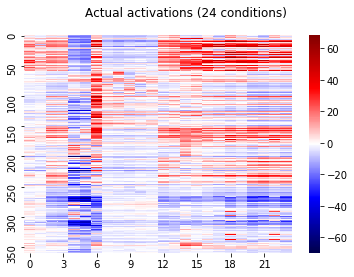

In [14]:
#Visualize mean activity patterns by task
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (24 conditions)')

In [15]:
#Convert to 7-task data order by averaging 24-condition betas
activations_bytask=np.zeros((nParcels,nTasks,nSubjs))
for tasknum in range(nTasks):
    condnums_fortask=tasks_condmappings[taskNames[tasknum]]
    activations_bytask[:,tasknum,:] = np.mean(activations_bycond[:,condnums_fortask,:],axis=1)


Text(0.5, 0.98, 'Actual activations (7 tasks)')

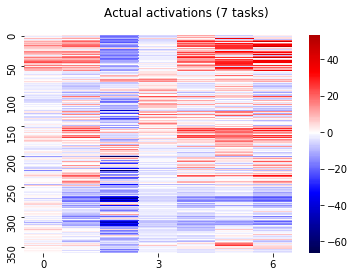

In [16]:
#Visualize mean activity patterns by task

ax = sns.heatmap(np.mean(activations_bytask,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (7 tasks)')

Mean similarities across tasks: r=0.48747924521319713


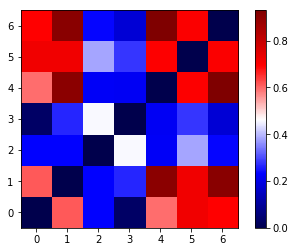

In [17]:
#Calculate similarities across tasks
corrmat=np.corrcoef(np.transpose(np.mean(activations_bytask[netorder,:,:],axis=2)))
#Set matrix diagonal to 0s
np.fill_diagonal(corrmat,0)
plt.imshow(corrmat,origin='lower')
plt.colorbar()
upperTIndices_corrmat=np.triu_indices(np.shape(corrmat)[0],k=1)
print('Mean similarities across tasks: r=' + str(np.mean(np.mean(corrmat[upperTIndices_corrmat]))))

## Calculate repeat reliability (noise ceiling) of task activations

In [57]:
#Load task activity (GLM betas) data
activations_bycondbyrun=np.zeros((nParcels,nConds*2,nSubjs))
scount = 0
for subj  in subjNums:
    activations_bycondbyrun[:,:,scount] = loadTaskActivity(subj,model='24pXaCompCorXVolterra',regressors='byConditionByRun',zscore=False)[0]
    scount += 1

In [58]:
#Get condition index numbers by run
betas,taskkeys=loadTaskActivity(subjNums[0],model='24pXaCompCorXVolterra',regressors='byConditionByRun',zscore=False)
run1_cond_indices=np.concatenate([value for key, value in taskkeys.items() if '_RL' in key])
run2_cond_indices=np.concatenate([value for key, value in taskkeys.items() if '_LR' in key])
run1_cond_indices_mask=np.zeros(nConds*2)>1
run1_cond_indices_mask[run1_cond_indices]=True
run2_cond_indices_mask=np.zeros(nConds*2)>1
run2_cond_indices_mask[run2_cond_indices]=True

#Reorganize data to 2 node x condition x subject matrices
actvect_splitbyrun_group_run1s = activations_bycondbyrun[:,run1_cond_indices,:]
actvect_splitbyrun_group_run2s = activations_bycondbyrun[:,run2_cond_indices,:]


Run 1 data


Text(0.5, 0.98, 'Actual activations (24 conditions)')

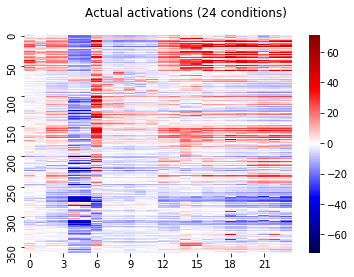

In [20]:
#Visualize mean activity patterns by task, run 1 data
print('Run 1 data')
ax = sns.heatmap(np.mean(actvect_splitbyrun_group_run1s,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (24 conditions)')

Run 2 data


Text(0.5, 0.98, 'Actual activations (24 conditions)')

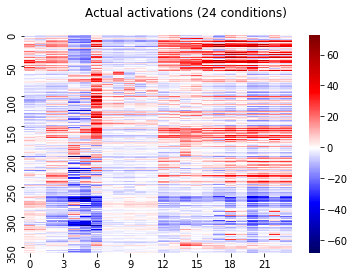

In [21]:
#Visualize mean activity patterns by task, run 2 data
print('Run 2 data')
ax = sns.heatmap(np.mean(actvect_splitbyrun_group_run2s,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (24 conditions)')

In [22]:
#Run repeat reliability (noise ceiling) analysis
print("==Repeat reliability across 24 task conditions")
noiseceiling_output=actflow.actflowcomp.noiseceilingcalc(actvect_splitbyrun_group_run1s, actvect_splitbyrun_group_run2s, full_report=True, print_report=True, avgthencomp_fixedeffects=True)


==Repeat reliability across 24 task conditions
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.52, t-value vs. 0: 65.65, p-value vs. 0: 3.363851818711326e-125
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.04
 
Mean MAE (mean absolute error) = 13.75
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generated/sklearn.

In [23]:
# from importlib import reload
# actflow.tools = reload(actflow.tools)

#Save condition-wise accuracy for each node to surface map
#taskcorrFC
datamat=np.mean(noiseceiling_output['corr_conditionwise_compthenavg_bynode'],axis=1)
datamat=datamat[:,np.newaxis]
outfilename='figures/NoiseCeiling_condwise_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

#Max and min values
print('Maximum of map: ', np.max(datamat[datamat!=0]))
print('Minimum of map: ', np.min(datamat[datamat!=0]))

Command:
wb_command -cifti-convert -from-text figures/NoiseCeiling_condwise_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii figures/NoiseCeiling_condwise_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:figures/NoiseCeiling_condwise_discovery176.dscalar.nii
Maximum of map:  0.8094196524591349
Minimum of map:  0.003770126323336996


Plots of average-then-compare node-wise repeat reliability by condition:
[0.7800847472761331, 0.6919557557416793, 0.9727472384559246, 0.9609874718258535, 0.9155932220970873, 0.8315895969368915, 0.9511722375451304, 0.8980222412610352, 0.906957506179867, 0.8412120234134247, 0.9427129304605585, 0.8859011738616529, 0.988210923205291, 0.9887346124498112, 0.9548386397395022, 0.9805079010337925, 0.9774801372325627, 0.9273549291454624, 0.9675639463640276, 0.9553066819070588, 0.9302958859223042, 0.9519410162172812, 0.9698750299242442, 0.9812218272307669]


(array([1., 0., 1., 0., 1., 1., 2., 3., 6., 9.]),
 array([0.69195576, 0.72163364, 0.75131153, 0.78098941, 0.8106673 ,
        0.84034518, 0.87002307, 0.89970096, 0.92937884, 0.95905673,
        0.98873461]),
 <a list of 10 Patch objects>)

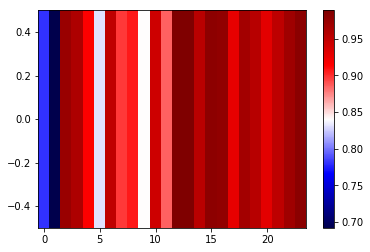

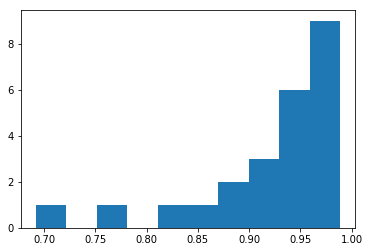

In [24]:
print('Plots of average-then-compare node-wise repeat reliability by condition:')
mat1=noiseceiling_output['corr_nodewise_avgthencomp_bycond']
print(mat1)
mat_mod = np.expand_dims(mat1, axis=0)
plt.imshow(mat_mod,aspect='auto',origin='lower')
plt.colorbar()
plt.figure()
plt.hist(mat1)


Plots of compare-then-average node-wise repeat reliability by condition:
[0.25542581 0.19939568 0.6790289  0.67593907 0.39941032 0.36874858
 0.60315951 0.33077973 0.29488357 0.26310333 0.28854238 0.28840662
 0.72003803 0.69662168 0.70287375 0.68171921 0.60147654 0.5563762
 0.72250567 0.65022568 0.68638826 0.66576733 0.70360302 0.73764336]


(array([1., 5., 1., 2., 0., 0., 1., 2., 5., 7.]),
 array([0.19939568, 0.25322044, 0.30704521, 0.36086998, 0.41469475,
        0.46851952, 0.52234429, 0.57616906, 0.62999383, 0.6838186 ,
        0.73764336]),
 <a list of 10 Patch objects>)

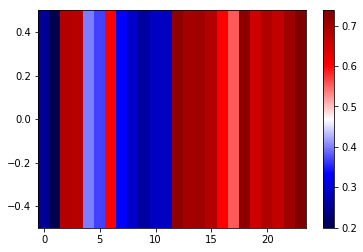

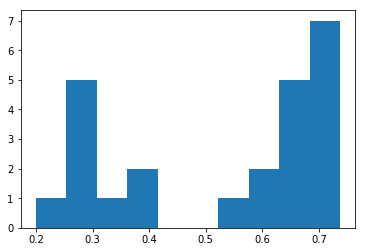

In [25]:
print('Plots of compare-then-average node-wise repeat reliability by condition:')
mat1=np.mean(noiseceiling_output['corr_nodewise_compthenavg_bycond'],axis=1)
print(mat1)
mat_mod = np.expand_dims(mat1, axis=0)
plt.imshow(mat_mod,aspect='auto',origin='lower')
plt.colorbar()
plt.figure()
plt.hist(mat1)


Plots of average-then-compare condition-wise repeat reliability by parcel:


(array([  1.,   0.,   0.,   2.,   6.,  11.,  21.,  40., 137., 142.]),
 array([0.18459193, 0.26458555, 0.34457916, 0.42457277, 0.50456638,
        0.58455999, 0.6645536 , 0.74454722, 0.82454083, 0.90453444,
        0.98452805]),
 <a list of 10 Patch objects>)

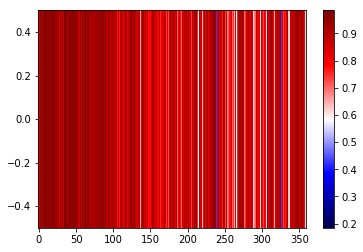

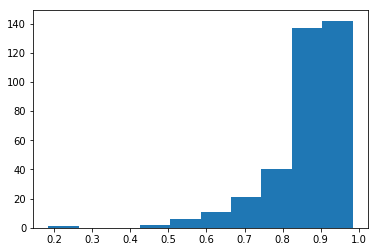

In [26]:
print('Plots of average-then-compare condition-wise repeat reliability by parcel:')
mat1=np.array(noiseceiling_output['corr_conditionwise_avgthencomp_bynode'])[netorder]
mat_mod = np.expand_dims(mat1, axis=0)
plt.imshow(mat_mod,aspect='auto',origin='lower')
plt.colorbar()
plt.figure()
plt.hist(mat1)

Plots of condition-wise repeat reliability by parcel:


(array([10., 24., 50., 79., 69., 54., 34., 17., 11., 12.]),
 array([0.00377013, 0.08433508, 0.16490003, 0.24546498, 0.32602994,
        0.40659489, 0.48715984, 0.56772479, 0.64828975, 0.7288547 ,
        0.80941965]),
 <a list of 10 Patch objects>)

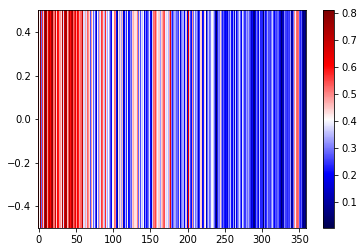

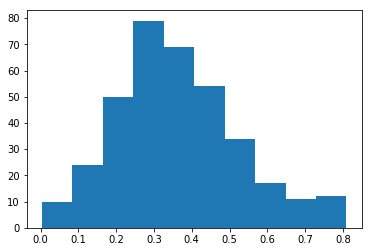

In [27]:
print('Plots of condition-wise repeat reliability by parcel:')
mat1=np.mean(np.array(noiseceiling_output['corr_conditionwise_compthenavg_bynode'])[netorder,:],axis=1)
mat_mod = np.expand_dims(mat1, axis=0)
plt.imshow(mat_mod,aspect='auto',origin='lower')
plt.colorbar()
plt.figure()
plt.hist(mat1)
#plt.figure()
#plt.hist(np.mean(noiseceiling_output['repeat_corr_conditionwise_compthenavg_bynode'][netorder,:],axis=0))

# Correlation-based resting-state FC

## Calculating correlation-based resting-state FC 

In [136]:
#Load rest residuals (post-preprocessing) data in and run correlation for each subject
restFC_corr_bysubj=np.zeros((nParcels,nParcels,nSubjs))
scount = 0
for subj  in subjNums:
    restdata = loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False)
    restFC_corr_bysubj[:,:,scount] = actflow.connectivity_estimation.corrcoefconn(restdata)
    scount += 1

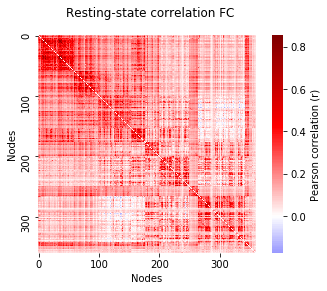

In [29]:
# plt.imshow(np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'})
ax.figure.suptitle('Resting-state correlation FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'restFC_discovery176.pdf')

## Activity flow mapping with correlation-based resting-state FC

In [30]:
#Run actflow predictions
print("==Activity flow mapping results, correlation-based resting-state FC, 7 tasks==")
actflowOutput_restFCCorr = actflow.actflowcomp.actflowtest(activations_bytask, restFC_corr_bysubj)

==Activity flow mapping results, correlation-based resting-state FC, 7 tasks==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 7 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.60, t-value vs. 0: 84.21, p-value vs. 0: 1.5380140644250529e-143
 
Mean % variance explained (R^2 score, coeff. of determination) = -877.11
 
Mean MAE (mean absolute error) = 307.31
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.o

In [137]:
#Run actflow predictions, by condition
print("==Activity flow mapping results, correlation-based resting-state FC, 24 conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr_bysubj, avgthencomp_fixedeffects=True)


==Activity flow mapping results, correlation-based resting-state FC, 24 conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.59, t-value vs. 0: 90.76, p-value vs. 0: 4.1935660731125815e-149
 
Mean % variance explained (R^2 score, coeff. of determination) = -838.07
 
Mean MAE (mean absolute error) = 332.44
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-

In [32]:
#Run actflow predictions, by condition, split-half (noise ceiling)
print("==Activity flow mapping results, correlation-based resting-state FC, 24 conditions, split-half==")
print("==Comparing actflow predictions of Run 2 (based on Run 1 data) vs. actual Run 1 activations (noise ceiling/repeat reliability)==")
actflowOutput_restFCCorr_bycond_splithalf = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, restFC_corr_bysubj, actVect_group_test=actvect_splitbyrun_group_run2s)


==Activity flow mapping results, correlation-based resting-state FC, 24 conditions, split-half==
==Comparing actflow predictions of Run 2 (based on Run 1 data) vs. actual Run 1 activations (noise ceiling/repeat reliability)==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.31, t-value vs. 0: 35.69, p-value vs. 0: 3.100340549076402e-82
 
Mean % variance explained (R^2 score, coeff. of determination) = -867.49
 
Mean MAE (mean absolute error) = 384.86
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data'

## Activity flow mapping with LOCALLY-NON-CIRCULAR correlation-based resting-state FC

In [33]:
## Calculating with SLURM cluster command (in parallel), loading from data if saved
#Calculate locally-non-circular activations (excluding vertices near to-be-predicted ROIs)

loaddata_ifavailable=True
datasuffix='_taskbetas24cond_noncirc_data'

activations_noncirc_bycond=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    outname1 = 'taskbeta'
    
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        activations_noncirc_bycond[:,:,:,scount] = h5f[outname1][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/')\n")
        file_python.write("import loadTaskActivity_byscript as loadt; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("activitydata = loadt.loadTaskActivity('" + str(subj) + "',model='24pXaCompCorXVolterra',regressors='byCondition',zscore=False,preprocdatadir_GLMs='" + preprocdatadir_vertexwise + "',vertexVoxelWise=True)\n")
        file_python.write("activations_noncirc_bycond = actflow.connectivity_estimation.calcactivity_parcelwise_noncircular(activitydata, dilated_parcels=True, verbose=False)\n")

        file_python.write("#Save data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'taskbeta'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=activations_noncirc_bycond)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=activations_noncirc_bycond)\n")
        file_python.write("h5f.close()")
        file_python.close()                
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:01:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

In [34]:
#Convert to 7-task data
activations_noncirc_bytask=np.zeros((nParcels,nParcels,nTasks,nSubjs))
for tasknum in range(nTasks):
    condnums_fortask=tasks_condmappings[taskNames[tasknum]]
    activations_noncirc_bytask[:,:,tasknum,:] = np.mean(activations_noncirc_bycond[:,:,condnums_fortask,:],axis=2)

array([[1., 1.],
       [1., 1.]])

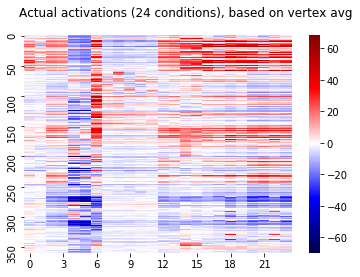

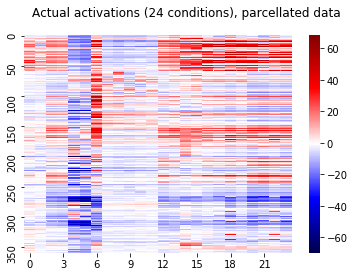

In [35]:
#Pull out vertex-averaged GLM activations (unmodified by local-non-circularity calculations)

activations_vertexavg_bycond=np.zeros((nParcels,nConds,nSubjs))
# extract the diagonal of the 360 x 360 matrix for each condition.
# The diagonal corresponds to the original activation for the target regions
for region_num in range(nParcels):
    for cond_num in range(nConds):
        for subj_num in range(nSubjs):
            activations_vertexavg_bycond[region_num,cond_num,subj_num] = activations_noncirc_bycond[region_num,region_num,cond_num,subj_num]

            
flip_hemisphere_indices=np.concatenate([np.arange(180,360), np.arange(0,180)])

#Visualize mean activity patterns by task
ax = sns.heatmap(np.mean(activations_vertexavg_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (24 conditions), based on vertex avg')

plt.figure()
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
ax.figure.suptitle('Actual activations (24 conditions), parcellated data')

#Save to dscalar file
# ActflowToolbox.tools.map_to_surface = importlib.reload(ActflowToolbox.tools.map_to_surface)
# #import ActflowToolbox.tools.map_to_surface
# ActflowToolbox.tools.map_to_surface.map_to_surface(activations_vertexavg_bycond_avg,outputdir+'activations_vertexavg_bycond_avg')

# inputdata_flipped=np.zeros(np.shape(activations_vertexavg_bycond))
# inputdata_flipped[0:180,:,:]=activations_vertexavg_bycond[180:360,:,:]
# inputdata_flipped[180:360,:,:]=activations_vertexavg_bycond[0:180,:,:]
# np.corrcoef(inputdata_flipped.flatten(),activations_bycond.flatten())

np.corrcoef(activations_vertexavg_bycond.flatten(),activations_bycond.flatten())


/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


array([[1.        , 0.99876794],
       [0.99876794, 1.        ]])

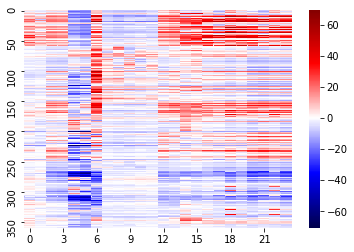

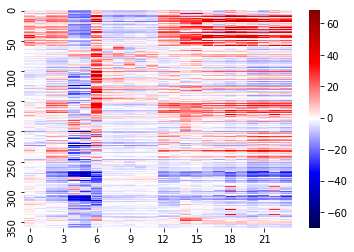

In [36]:
#Test: Calculate activations from vertices (GLM first, then average)

dlabelfile_forparcels='/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii'
#dlabelfile_forparcels='/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/tools/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
#dlabelfile_forparcels='/projects/f_mc1689_1/TaskFCActflow/docs/scripts/final_analyses/ActflowToolbox/tools/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
dlabels = np.squeeze(nib.load(dlabelfile_forparcels).get_data())

activations_vertexmean=np.zeros((nParcels,nConds,nSubjs))
scount = 0
for subj in subjNums:
    #print(subj + ', ' + str(scount))
    activitydata = loadTaskActivity(subj,model='24pXaCompCorXVolterra',regressors='byCondition',zscore=False,preprocdatadir_GLMs=preprocdatadir_vertexwise,vertexVoxelWise=True)[0]
    
    for parcel_num in range(360):
        # get all target ROI indices
        target_ind = np.where(dlabels==(parcel_num+1))[0] # Find target parcel indices (from dlabel file)
        activations_vertexmean[parcel_num,:,scount] = np.nanmean(np.real(activitydata[target_ind,:]),axis=0)
    
    scount += 1

#activations_vertexmean_avg = np.mean(activations_vertexmean[flip_hemisphere_indices,:,:],axis=2)
activations_vertexmean_avg = np.mean(activations_vertexmean,axis=2)

#plt.imshow(activations_vertexmean_avg[netorder,:],aspect='auto')
ax = sns.heatmap(activations_vertexmean_avg[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
#plt.colorbar()
plt.figure()


origActivationsMean=np.mean(activations_bycond,axis=2)
ax = sns.heatmap(origActivationsMean[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=50,xticklabels=3)
#plt.imshow(origActivationsMean[netorder,:],aspect='auto')
#plt.colorbar()

#Compare to noncircular code derived version
numValues=np.product(np.shape(activations_vertexmean_avg))

np.corrcoef(np.reshape(activations_vertexmean_avg,numValues),np.reshape(origActivationsMean,numValues))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


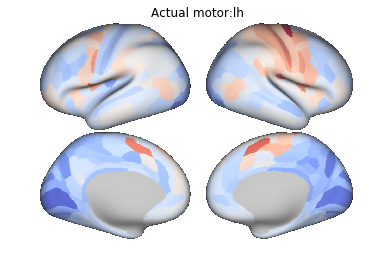

In [37]:
#Plotting images in-line, motor:lh

from wbplot import pscalar
import matplotlib.image as mpimg

condlabel='motor:lh'
condnum=9

#Actual
inputdata=np.mean(activations_vertexavg_bycond[:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual '+condlabel)
plt.imshow(img)


In [38]:
## Calculating with SLURM cluster command (in parallel), loading from data if saved
#Load rest residuals (post-preprocessing) data in and run correlation for each subject, run non-circular code

loaddata_ifavailable=True
datasuffix='_corrRestFC_noncirc_data'

restFC_noncirc_corr_bysubj=np.zeros((nParcels,nParcels,nSubjs))
outname1 = 'restFCcorr'
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        restFC_noncirc_corr_bysubj[:,:,scount] = h5f[outname1][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/')\n")
        file_python.write("import loadRestResiduals_byscript; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,FIR=False,vertexVoxelWise=True, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "', restRuns=['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR'])\n")
        file_python.write("restFC_noncirc_corr_bysubj=actflow.connectivity_estimation.calcconn_parcelwise_noncircular(restdata,connmethod='pearsoncorr',dilated_parcels=True, verbose=False)\n")
        file_python.write("#Save data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'restFCcorr'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_noncirc_corr_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_noncirc_corr_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:03:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

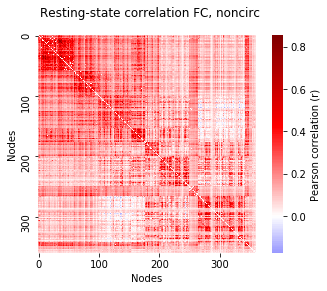

In [39]:
# plt.imshow(np.mean(restFC_noncirc_corr_bysubj[netorder,:,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_noncirc_corr_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'})
ax.figure.suptitle('Resting-state correlation FC, noncirc')
ax.set(xlabel='Nodes',ylabel='Nodes')

array([[1.        , 0.97111732],
       [0.97111732, 1.        ]])

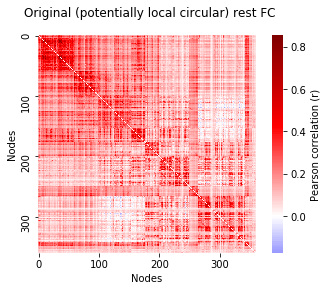

In [40]:
orig_restFC_mean=np.mean(restFC_corr_bysubj,axis=2)
# plt.imshow(orig_restFC_mean[netorder,:][:,netorder],origin='lower')
# plt.colorbar()
# plt.title('Original (potentially local circular) rest FC')
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'})
ax.figure.suptitle('Original (potentially local circular) rest FC')
ax.set(xlabel='Nodes',ylabel='Nodes')

#Compare to noncircular code derived version
noncirc_restFC_mean=np.mean(restFC_noncirc_corr_bysubj,axis=2)
numValues=np.product(np.shape(orig_restFC_mean))
np.corrcoef(np.reshape(noncirc_restFC_mean,numValues),np.reshape(orig_restFC_mean,numValues))

In [41]:
#Run actflow predictions
print("==Activity flow mapping results, NON-CIRCULAR, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_noncirc_restFCCorr = actflow.actflowcomp.actflowtest(activations_noncirc_bycond, restFC_noncirc_corr_bysubj, separate_activations_bytarget=True)

==Activity flow mapping results, NON-CIRCULAR, correlation-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.57, t-value vs. 0: 87.46, p-value vs. 0: 2.348150306642009e-146
 
Mean % variance explained (R^2 score, coeff. of determination) = -805.57
 
Mean MAE (mean absolute error) = 325.62
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. S

# Multiple-regression-based resting-state FC

## Activity flow mapping with multiple-regression-based resting-state FC

In [13]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregRestFC_data'

restFC_mreg_bysubj=np.zeros((nParcels,nParcels,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        restFC_mreg_bysubj[:,:,scount] = h5f['restFCRegression'][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/')\n")
        file_python.write("import loadRestResiduals_byscript; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,FIR=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "', restRuns=['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR'])\n")
        file_python.write("restFC_mreg_bysubj=actflow.connectivity_estimation.multregconn(restdata)\n")
        file_python.write("#Save multiple-regression task FC data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'restFCRegression'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_mreg_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_mreg_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:05:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

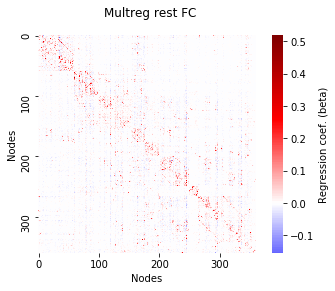

In [14]:
# plt.imshow(np.mean(restFC_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#plt.savefig('matrix.png',dpi=600,transparent=True, bbox_inches='tight')
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [15]:
#Run actflow predictions
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==")
#actflowOutput_restFCMReg_bytask = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bysubj, avgthencomp_fixedeffects=True)
actflowOutput_restFCMReg_bytask = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bysubj, avgthencomp_fixedeffects=False)

==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.89, t-value vs. 0: 165.91, p-value vs. 0: 2.1294740292018985e-194
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.78
 
Mean MAE (mean absolute error) = 5.38
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https:

In [138]:
print("===Compare Rest multregFC actflow predictions to Rest corr (all time points) actflow prediction===")
model_compare_RestMultRegFCVsRestCorrActflow = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_bytask['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_bytask['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Rest multregFC actflow predictions to Rest corr (all time points) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.89
Model2 mean Pearson r=0.59
R-value difference = 0.30
Model1 vs. Model2 T-value: 92.01, p-value: 3.977144562351872e-150
 
Model1 mean % predicted variance explained R^2=0.78
Model2 mean % predicted variance explained R^2=-838.07
R^2 difference = 838.86
 
Model1 mean MAE = 5.38
Model2 mean MAE = 332.44
Model1 vs. Model2 mean MAE difference = -327.06
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not.

In [139]:
#Values for effect size calculation; nodewise average across conditions; using https://memory.psych.mun.ca/models/stats/effect_size.shtml
std_mreg=np.std(np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond'],axis=0))
print("std_mreg=",std_mreg)
std_corr=np.std(np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond_model2'],axis=0))
print("std_corr=",std_corr)
rval_mreg_corr=np.corrcoef(np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond'],axis=0), np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond_model2'],axis=0))[0,1]
print("rval_mreg_corr=",rval_mreg_corr)
std_diffs=np.std(np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond'],axis=0)-np.mean(model_compare_RestMultRegFCVsRestCorrActflow['corr_nodewise_compthenavg_bycond_model2'],axis=0))
print('std_diffs=',std_diffs)

std_mreg= 0.031587204157440416
std_corr= 0.06778533362389111
rval_mreg_corr= 0.7286866431215429
std_diffs= 0.04972071314620424


/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


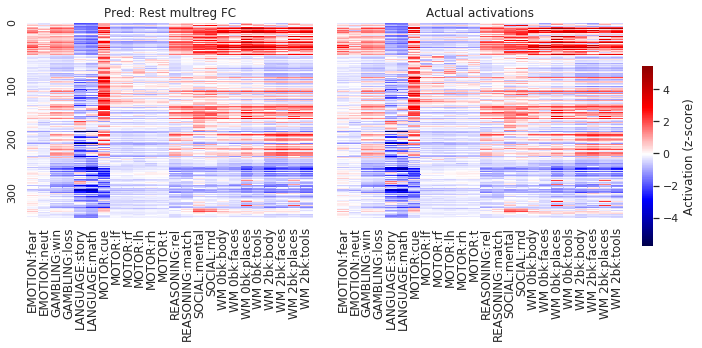

In [140]:
#Visualize predicted and actual activations
data1=stats.zscore(np.mean(actflowOutput_restFCMReg_bytask['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
data2=stats.zscore(np.mean(activations_bycond,axis=2)[netorder,:],axis=None)
#data3=stats.zscore(np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
datamin=min(np.array([min(data1.flatten()),min(data2.flatten())]))
datamax=max(np.array([max(data1.flatten()),max(data2.flatten())]))
fig, axn = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10,5])
cbar_ax = fig.add_axes([.90, .3, .015, .5])
ax1 = sns.heatmap(data1,ax=axn[0],center=0,cmap='seismic',cbar=False,yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax1.title.set_text('Pred: Rest multreg FC')
ax2 = sns.heatmap(data2,ax=axn[1],center=0,cmap='seismic',cbar=True,cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (z-score)'},yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax2.title.set_text('Actual activations')
#ax3 = sns.heatmap(data3,ax=axn[2],center=0,cmap='seismic',cbar=True,cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (z-score)'},yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
#ax3.title.set_text('Pred: Task multreg FC')
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 12)
ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 12)
#ax3.set_xticklabels(ax3.get_xmajorticklabels(), fontsize = 12)
fig.tight_layout(rect=[0, 0, .9, 1])
# fig=ax.get_figure()
fig.savefig(figuredir+'restActflowPred_MultregFCAllData_discovery176.pdf')

## Activity flow mapping with LOCALLY-NON-CIRCULAR multiple-regression-based resting-state FC

In [48]:
## Calculating NON-CIRCULAR multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregRestFC_noncirc_data'

restFC_noncirc_mreg_bysubj=np.zeros((nParcels,nParcels,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        restFC_noncirc_mreg_bysubj[:,:,scount] = h5f['restFCRegression'][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/')\n")
        file_python.write("import loadRestResiduals_byscript; import h5py; import ActflowToolbox as actflow\n")
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,FIR=False,vertexVoxelWise=True, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "', restRuns=['rfMRI_REST1_RL', 'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR'])\n")
        file_python.write("restFC_noncirc_mreg_bysubj=actflow.connectivity_estimation.calcconn_parcelwise_noncircular_surface(restdata,dilated_parcels=True,verbose=True)\n")
        file_python.write("#Save multiple-regression task FC data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'restFCRegression'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_noncirc_mreg_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_noncirc_mreg_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:03:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

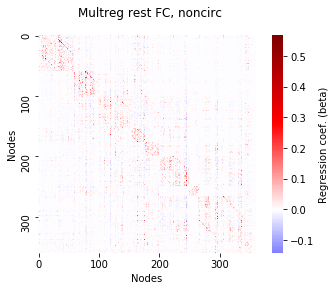

In [49]:
# plt.imshow(np.mean(restFC_noncirc_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#plt.savefig('matrix.png',dpi=600,transparent=True, bbox_inches='tight')
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_noncirc_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC, noncirc')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [50]:
#Run actflow predictions
print("==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based resting-state FC, 24 task conditions==")
actflowOutput_restFCMReg_noncirc_bycond = actflow.actflowcomp.actflowtest(activations_noncirc_bycond, restFC_noncirc_mreg_bysubj, separate_activations_bytarget=True)


==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.87, t-value vs. 0: 152.16, p-value vs. 0: 7.217917110376571e-188
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.74
 
Mean MAE (mean absolute error) = 5.87
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to p

In [51]:
print("===Compare multregFC actflow predictions to corrFC actflow prediction, NON-CIRCULAR===")
model_compare_multRegVsCorrFCActflow = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_noncirc_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_noncirc_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_noncirc_restFCCorr['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare multregFC actflow predictions to corrFC actflow prediction, NON-CIRCULAR===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.87
Model2 mean Pearson r=0.57
R-value difference = 0.30
Model1 vs. Model2 T-value: 83.66, p-value: 4.706611779022778e-143
 
Model1 mean % predicted variance explained R^2=0.74
Model2 mean % predicted variance explained R^2=-805.57
R^2 difference = 806.31
 
Model1 mean MAE = 5.87
Model2 mean MAE = 325.62
Model1 vs. Model2 mean MAE difference = -319.75
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: 

# Correlation-based task-state FC

In [52]:
%%time
#Load task residuals (post-preprocessing) data in and run correlation for each subject

loaddata_ifavailable=True
datasuffix='_taskFC_corr_data'

taskFC_corr_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    outname1 = 'taskFCcorr'

    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        taskFC_corr_bycond_bysubj[:,:,:,scount] = h5f[outname1][:]
        h5f.close()
    else:
        #Compute FCs
        taskdata = loadTaskResiduals(subj,model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False)
        tasktiming_bycond=tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5
        for condnum in range(24):
            tasktiming=tasktiming_bycond[:,condnum]
            taskFC_corr_bycond_bysubj[:,:,condnum,scount] = np.corrcoef(taskdata[:,tasktiming],rowvar=1)
            #Set FC matrix diagonal to 0s
            np.fill_diagonal(taskFC_corr_bycond_bysubj[:,:,condnum,scount],0)
        
        #Save multiple-regression task FC data to file
        h5f = h5py.File(file_path,'a')
        try:
            h5f.create_dataset(outname1,data=taskFC_corr_bycond_bysubj[:,:,:,scount])
        except:
            del h5f[outname1]
            h5f.create_dataset(outname1,data=taskFC_corr_bycond_bysubj[:,:,:,scount])
        h5f.close()
        
    scount += 1

CPU times: user 6.71 s, sys: 2.75 s, total: 9.46 s
Wall time: 28.7 s


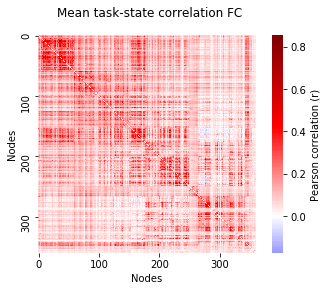

In [53]:

#Visualize FC matrix - mean task FC; same scale as rest data
restFCMin=np.min(np.min(np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2)))
restFCMax=np.max(np.max(np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2)))
ax = sns.heatmap(np.mean(np.mean(taskFC_corr_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder],square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'},vmin=restFCMin,vmax=restFCMax)
ax.figure.suptitle('Mean task-state correlation FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meantaskFC_discovery176.pdf')

In [54]:
taskFCmeanMat=np.mean(np.mean(taskFC_corr_bycond_bysubj,axis=3),axis=2)
restFCmeanMat=np.mean(restFC_corr_bysubj,axis=2)
upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat)[0],k=1)
resttask_mattcorr=np.corrcoef(taskFCmeanMat[upperTIndices_corrmat], restFCmeanMat[upperTIndices_corrmat])
print('Mean task to rest FC similarity, corr: ', str(resttask_mattcorr))


Mean task to rest FC similarity, corr:  [[1.        0.9044012]
 [0.9044012 1.       ]]


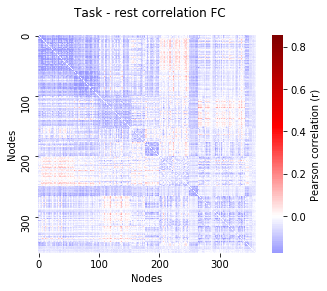

In [55]:
#Visualize FC matrix - mean task FC vs. rest FC; same scale as rest data
restFCData=np.mean(restFC_corr_bysubj[netorder,:,:][:,netorder,:],axis=2)
restFCMin=np.min(np.min(restFCData))
restFCMax=np.max(np.max(restFCData))
ax = sns.heatmap(np.mean(np.mean(taskFC_corr_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]-restFCData,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'},vmin=restFCMin,vmax=restFCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Task - rest correlation FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meantaskFCVsRestFC_discovery176.pdf')


In [56]:
#Analysis of task vs. rest matrix
diffMat=np.mean(np.mean(taskFC_corr_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]-restFCData
print('Minimum value: ' + str(min(diffMat.flatten())))
print('Maximum value: ' + str(max(diffMat.flatten())))
print('Mean value: ' + str(np.mean(diffMat.flatten())))
print('Stdev value: ' + str(np.std(diffMat.flatten())))

#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
diffMat_allsubj=np.mean(taskFC_corr_bycond_bysubj,axis=2)-restFC_corr_bysubj
upperTIndices_corrmat=np.triu_indices(np.shape(diffMat_allsubj)[0],k=1)
diffMat_allsubj_upperT=np.transpose([diffMat_allsubj[:,:,subjN][upperTIndices_corrmat] for subjN in np.arange(nSubjs)])

nConnections=int(nParcels*(nParcels-1)/2)

#FDR
# tstats = [stats.ttest_1samp(diffMat_allsubj_upperT[connnum,:],0.0) for connnum in np.arange(nConnections)]
# tvals=np.array([tstats[connnum][0] for connnum in np.arange(nConnections)])
# pvals=[tstats[connnum][1] for connnum in np.arange(nConnections)]
# pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
# fdr_sigvector=pvals_FDRcorrected<0.05
#Bonferroni
# bonferroni_sigvector=pvals<(0.05/nConnections)

#MaxT
maxt_output=actflow.tools.max_t(diffMat_allsubj_upperT)
maxTThreshold = maxt_output[1]
maxt_sigvector=np.array(maxt_output[2])<0.05
tvals=maxt_output[0]
#maxt_sigvector=np.abs(tvals)>maxTThreshold

percenttotal=100*np.sum(maxt_sigvector)/nConnections
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nConnections
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nConnections
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', percenttotal)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)


Minimum value: -0.2999960284313767
Maximum value: 0.19600922475200527
Mean value: -0.04352699817145004
Stdev value: 0.04773918195095355
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 67.84122562674095
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 4.401114206128134
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 63.440111420612816


In [57]:
#Run actflow predictions
print("==Activity flow mapping results, correlation-based task-state FC, 24 conditionss==")
actflowOutput_taskFCCorr = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_corr_bycond_bysubj, full_report=True)

==Activity flow mapping results, correlation-based task-state FC, 24 conditionss==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.66, t-value vs. 0: 133.01, p-value vs. 0: 9.847723014368333e-178
 
Mean % variance explained (R^2 score, coeff. of determination) = -950.31
 
Mean MAE (mean absolute error) = 355.08
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-le

## Match resting-state FC data to task-state FC data (amount of data, task timing regression, timing, etc)

In [58]:
%%time
#Load rest residuals (post-preprocessing) data in and run correlation for each subject
#Match rest analysis to each task as much as possible

loaddata_ifavailable=True
datasuffix='_restFCMatchedTime_corr_data'

restFC_corr_matchtaskFC_bytask_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    outname1 = 'restFCcorrMatchedtime'

    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        restFC_corr_matchtaskFC_bytask_bysubj[:,:,:,scount] = h5f[outname1][:]
        h5f.close()
    else:
        #Compute FCs
        restdata = loadRestResiduals(subj,model='24pXaCompCorXVolterra',zscore=False,FIR=False)
        tasktiming_bycond=tgp.loadTaskTimingForAllTasks(subj,taskModel='canonical')['taskRegressors']>.5
        #Restrict to the number of task time points
        restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]
        for condnum in range(24):
            tasktiming=tasktiming_bycond[:,condnum]
            restFC_corr_matchtaskFC_bytask_bysubj[:,:,condnum,scount] = np.corrcoef(restdata[:,tasktiming],rowvar=1)
            #Set FC matrix diagonal to 0s
            np.fill_diagonal(restFC_corr_matchtaskFC_bytask_bysubj[:,:,condnum,scount],0)
        
        #Save multiple-regression task FC data to file
        h5f = h5py.File(file_path,'a')
        try:
            h5f.create_dataset(outname1,data=restFC_corr_matchtaskFC_bytask_bysubj[:,:,:,scount])
        except:
            del h5f[outname1]
            h5f.create_dataset(outname1,data=restFC_corr_matchtaskFC_bytask_bysubj[:,:,:,scount])
        h5f.close()
        
    scount += 1


CPU times: user 6.74 s, sys: 2.66 s, total: 9.4 s
Wall time: 29 s


In [59]:
print("Mean number of time points per condition:")
tasktiming_bycond=tgp.loadTaskTimingForAllTasks(subjNums[0],taskModel='canonical')['taskRegressors']>.5
np.mean(np.sum(tasktiming_bycond,axis=0))

Mean number of time points per condition:


114.0

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

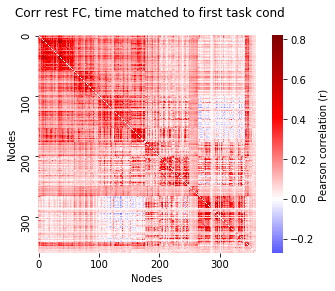

In [60]:
#Plot mean rest FC matrix example (first task)
# plt.imshow(np.tanh(np.mean(np.arctanh(restFC_corr_matchtaskFC_bytask_bysubj[netorder,:,0,:][:,netorder,:]),axis=2)),origin='lower')
# plt.colorbar()
# plt.xlabel('Regions',fontsize=18)
# plt.ylabel('Regions',fontsize=18)
#Visualize FC matrix
ax = sns.heatmap(np.tanh(np.mean(np.arctanh(restFC_corr_matchtaskFC_bytask_bysubj[netorder,:,0,:][:,netorder,:]),axis=2)),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Pearson correlation (r)'})
ax.figure.suptitle('Corr rest FC, time matched to first task cond')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [61]:
#Run actflow predictions
print("==Activity flow mapping results, correlation-based resting-state FC, MATCHED TO TASK FC, 24 conditions==")
actflowOutput_restFCCorr_matchTaskFC = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr_matchtaskFC_bytask_bysubj, full_report=True)

==Activity flow mapping results, correlation-based resting-state FC, MATCHED TO TASK FC, 24 conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.51, t-value vs. 0: 98.82, p-value vs. 0: 1.8831750981609734e-155
 
Mean % variance explained (R^2 score, coeff. of determination) = -931.63
 
Mean MAE (mean absolute error) = 347.28
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1.

In [62]:
print("===Compare Task corrFC actflow predictions to Rest corrFC (matching timing) actflow prediction===")
model_compare_TaskCorrFCVsRestCorrFCMatchTimingActflow = actflow.model_compare(target_actvect=actflowOutput_restFCCorr_matchTaskFC['actVect_actual_group'], model1_actvect=actflowOutput_restFCCorr_matchTaskFC['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCCorr['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Task corrFC actflow predictions to Rest corrFC (matching timing) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.51
Model2 mean Pearson r=0.66
R-value difference = -0.15
Model1 vs. Model2 T-value: -41.83, p-value: 4.75133395319819e-93
 
Model1 mean % predicted variance explained R^2=-931.63
Model2 mean % predicted variance explained R^2=-950.31
R^2 difference = 18.68
 
Model1 mean MAE = 347.28
Model2 mean MAE = 355.08
Model1 vs. Model2 mean MAE difference = -7.80
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not

## Visualizing predictions, rest and task correlation FC

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


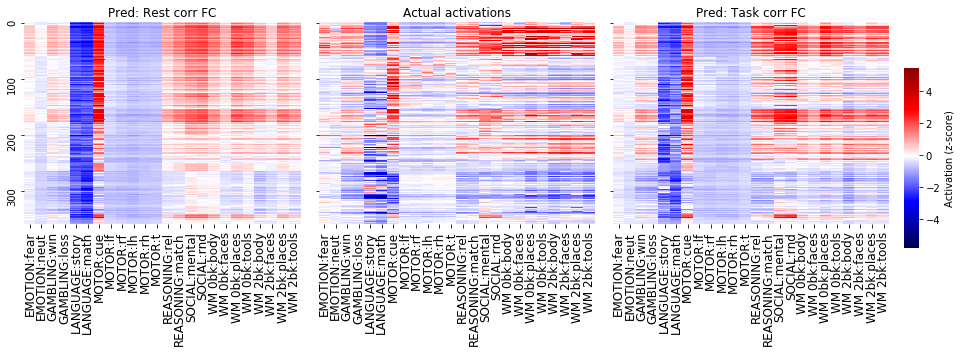

In [63]:
#Visualize predicted and actual activations
data1=stats.zscore(np.mean(actflowOutput_restFCCorr_matchTaskFC['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
data2=stats.zscore(np.mean(activations_bycond,axis=2)[netorder,:],axis=None)
data3=stats.zscore(np.mean(actflowOutput_taskFCCorr['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
datamin=min(np.array([min(data1.flatten()),min(data2.flatten()),min(data3.flatten())]))
datamax=max(np.array([max(data1.flatten()),max(data2.flatten()),max(data3.flatten())]))
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[14,5])
cbar_ax = fig.add_axes([.90, .3, .015, .5])
ax1 = sns.heatmap(data1,ax=axn[0],center=0,cmap='seismic',cbar=False,yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax1.title.set_text('Pred: Rest corr FC')
ax2 = sns.heatmap(data2,ax=axn[1],center=0,cmap='seismic',cbar=False,yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax2.title.set_text('Actual activations')
ax3 = sns.heatmap(data3,ax=axn[2],center=0,cmap='seismic',cbar=True,cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (z-score)'},yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax3.title.set_text('Pred: Task corr FC')
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 12)
ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 12)
ax3.set_xticklabels(ax3.get_xmajorticklabels(), fontsize = 12)
fig.tight_layout(rect=[0, 0, .9, 1])
# fig=ax.get_figure()
fig.savefig(figuredir+'restTaskActflowPred_CorrFC_discovery176.pdf')

In [64]:
ttestinputdata=actflowOutput_taskFCCorr['model_compare_output']['corr_conditionwise_compthenavg_bynode']
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]

In [65]:

#Save condition-wise accuracy for each node to surface map
#taskcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
ttestinputdata=np.arctanh(actflowOutput_taskFCCorr['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.arctanh(actflowOutput_taskFCCorr['model_compare_output']['corr_conditionwise_compthenavg_bynode']),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat_task=datamat.copy()
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'taskActflowPred_condwise_CorrFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

#restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
ttestinputdata=np.arctanh(actflowOutput_restFCCorr_matchTaskFC['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.arctanh(actflowOutput_restFCCorr_matchTaskFC['model_compare_output']['corr_conditionwise_compthenavg_bynode']),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat_rest=datamat.copy()
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'restMatchTaskActflowPred_condwise_CorrFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)


Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 100.0
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_CorrFC_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_CorrFC_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:/projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_CorrFC_discovery176.dscalar.nii
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 100.0
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/restMatchTaskActflowPred_condwise_CorrFC_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAntic

Min value:  0.11055169073475297
Max value:  0.8036428440867709


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  0.2165885350764139
Max value:  0.876066609639216


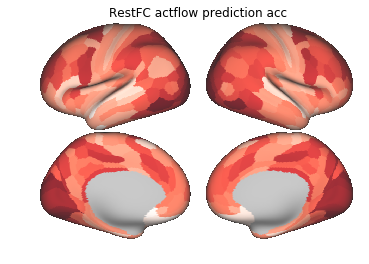

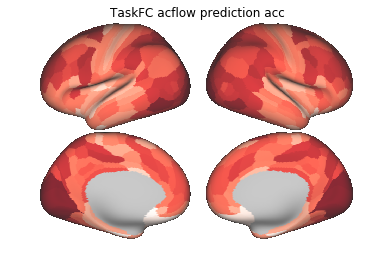

In [66]:
#Plotting images in-line, Task and rest FC-based predictions 

from wbplot import pscalar
import matplotlib.image as mpimg

#RestFC predicted
inputdata=datamat_rest
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('RestFC actflow prediction acc')
plt.imshow(img)


#TaskFC predicted
inputdata=datamat_task
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('TaskFC acflow prediction acc')
plt.imshow(img)


In [67]:
#Compare task-state and resting-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset=np.arctanh(actflowOutput_taskFCCorr['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
restdataset=np.arctanh(actflowOutput_restFCCorr_matchTaskFC['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset,restdataset)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat_taskVrest=datamat.copy()
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'taskVSrestMatchTaskActflowPred_condwise_CorrFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 94.16666666666667
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_CorrFC_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_CorrFC_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:/projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_CorrFC_discovery176.dscalar.nii


In [68]:
#Minimum value for task vs. rest map
datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
datamat=np.multiply(datamat,maxt_sigvector)
np.min(datamat[datamat>0])

0.08014621753303948

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  0.0
Max value:  0.3857511272723973


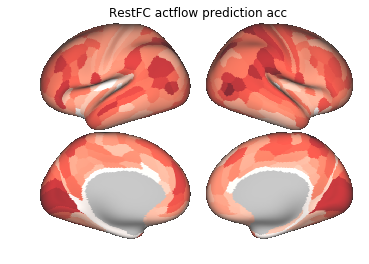

In [ ]:
#Plotting images in-line, Task vs. rest FC-based predictions 

from wbplot import pscalar
import matplotlib.image as mpimg

#RestFC predicted
inputdata=datamat_taskVrest
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('RestFC actflow prediction acc')
plt.imshow(img)

# Test with FIR-only task FC

In [ ]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_FIRonly_data'

taskFCFIRonly_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFCFIRonly_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")  
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow\n")
        
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:07:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==")
actflowOutput_taskFCMRegFIRonly_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskFCFIRonly_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.80, t-value vs. 0: 140.90, p-value vs. 0: 4.5389416998745856e-182
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.58
 
Mean MAE (mean absolute error) = 7.06
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://s

# Task-state multreg FC with parcel-level non-circular approach

In [ ]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_parcelnoncirc_data'

taskFC_mreg_parcelnoncirc_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj +'('+str(scount)+')')
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_mreg_parcelnoncirc_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")  
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow\n")
    
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("inputfilename = '/projects/f_mc1689_1/TaskFCActflow/docs/scripts/final_analyses/ActflowToolbox/network_definitions/parcels_to_remove_indices_cortexonly_data.h5'\n")
        file_python.write("h5f = h5py.File(inputfilename,'r')\n")
        file_python.write("parcels_to_remove={} \n")
        file_python.write("for parcelInt in range(360):\n")
        file_python.write("    outname1 = 'parcels_to_remove_indices'+'/'+str(parcelInt)\n")
        file_python.write("    parcels_to_remove[parcelInt] = h5f[outname1][:].copy()\n")
        file_python.write("h5f.close()\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        #file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming], n_components=0.9, svd_solver='full')\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming],parcelstoexclude_bytarget=parcels_to_remove)\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:07:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

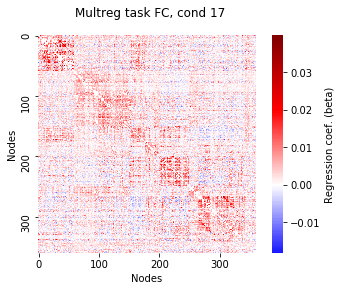

In [ ]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskFC_mreg_parcelnoncirc_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-state FC, PARCEL NON-CIRCULAR, 24 task conditions==")
actflowOutput_taskFCMReg_parcelnoncirc_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_mreg_parcelnoncirc_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, PARCEL NON-CIRCULAR, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.74, t-value vs. 0: 139.23, p-value vs. 0: 3.551547548142301e-181
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.47
 
Mean MAE (mean absolute error) = 7.78
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to posit

## Resting-state multreg FC with parcel-level non-circular approach, time-matched to task FC

In [ ]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFC_parcelnoncirc_data'

restFC_mreg_parcelnoncirc_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj +'('+str(scount)+')')
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFC_mreg_parcelnoncirc_bycond_bysubj[:,:,condnum,scount] = h5f['restFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")  
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("inputfilename = '/projects/f_mc1689_1/TaskFCActflow/docs/scripts/final_analyses/ActflowToolbox/network_definitions/parcels_to_remove_indices_cortexonly_data.h5'\n")
        file_python.write("h5f = h5py.File(inputfilename,'r')\n")
        file_python.write("parcels_to_remove={} \n")
        file_python.write("for parcelInt in range(360):\n")
        file_python.write("    outname1 = 'parcels_to_remove_indices'+'/'+str(parcelInt)\n")
        file_python.write("    parcels_to_remove[parcelInt] = h5f[outname1][:].copy()\n")
        file_python.write("h5f.close()\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        #file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming], n_components=0.9, svd_solver='full')\n")
        file_python.write("    restFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(restdata[:,tasktiming],parcelstoexclude_bytarget=parcels_to_remove)\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:07:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

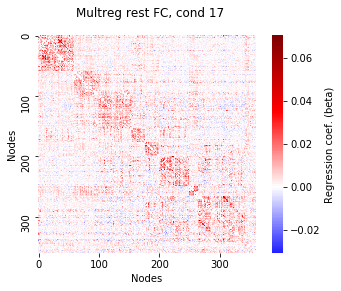

In [ ]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_mreg_parcelnoncirc_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [ ]:
#Run actflow predictions, 24-condition multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC time-matched, PARCEL NON-CIRCULAR, 24 task conditions==")
actflowOutput_restFCMReg_parcelnoncirc_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_parcelnoncirc_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC time-matched, PARCEL NON-CIRCULAR, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.39, t-value vs. 0: 72.97, p-value vs. 0: 5.906358845302521e-133
 
Mean % variance explained (R^2 score, coeff. of determination) = -0.52
 
Mean MAE (mean absolute error) = 12.79
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitraril

In [ ]:
print("===Compare Task multregFC actflow predictions to Rest multregFC (matching timing), PARCEL NON-CIRCULAR, actflow prediction===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTimingActflow_parcelnoncircular = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_parcelnoncirc_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_parcelnoncirc_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_parcelnoncirc_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True, avgthencomp_fixedeffects=True)


===Compare Task multregFC actflow predictions to Rest multregFC (matching timing), PARCEL NON-CIRCULAR, actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.39
Model2 mean Pearson r=0.74
R-value difference = -0.35
Model1 vs. Model2 T-value: -98.54, p-value: 3.077986284091213e-155
 
Model1 mean % predicted variance explained R^2=-0.52
Model2 mean % predicted variance explained R^2=0.47
R^2 difference = -0.98
 
Model1 mean MAE = 12.79
Model2 mean MAE = 7.78
Model1 vs. Model2 mean MAE difference = 5.00
 
Note: Pearson r and Pearson r^2 are scale-invariant, whil

# Task-state multreg FC with comparison to resting-state FC actflow predictions

In [23]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_data'

taskFC_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj +'('+str(scount)+')')
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")  
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow\n")
    
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        #file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming], n_components=0.9, svd_solver='full')\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:10:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

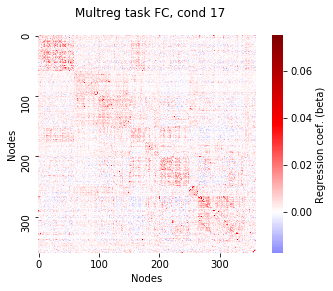

In [26]:
# plt.imshow(np.mean(taskFC_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskFC_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [27]:
#Run actflow predictions, 24-condition task multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==")
actflowOutput_taskFCMReg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.76, t-value vs. 0: 146.04, p-value vs. 0: 8.954760287923477e-185
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.51
 
Mean MAE (mean absolute error) = 7.47
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://sc

In [28]:
np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_nodewise_compthenavg_bycond'])

0.48018888893341594

Number of nodes above 0.25: 186
Number of nodes below -1: 38
Max value: 0.728789308394122
Min value: -2.78849346592408
meanPearsonr for nodes with R2 under -1: 0.43727637855809354
Number of above-0 r-values, for nodes with R2 under -1: 38


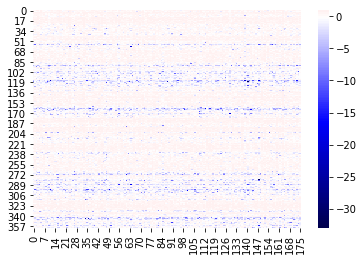

In [29]:
#plt.plot(np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_conditionwise_compthenavg_bynode'],axis=1))
#plt.imshow(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_conditionwise_compthenavg_bynode'],aspect='auto')
ax = sns.heatmap(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_conditionwise_compthenavg_bynode'],center=0,cmap='seismic',cbar=True)
meanR2=np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_conditionwise_compthenavg_bynode'],axis=1)
print('Number of nodes above 0.25:', np.sum(meanR2>0.25))
print('Number of nodes below -1:', np.sum(meanR2<-1))
print('Max value:', np.max(meanR2))
print('Min value:', np.min(meanR2))
meanPearsonr=np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'],axis=1)
print('meanPearsonr for nodes with R2 under -1:', np.mean(meanPearsonr[meanR2<-1]))
print('Number of above-0 r-values, for nodes with R2 under -1:', np.sum(meanPearsonr[meanR2<-1]>0))

In [30]:
np.round(np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['R2_nodewise_compthenavg_bycond'],axis=1),2)

array([ 0.52,  0.51,  0.73,  0.76,  0.05, -0.16,  0.43,  0.29,  0.25,
        0.26,  0.23,  0.27,  0.8 ,  0.81,  0.8 ,  0.78,  0.42,  0.48,
        0.53,  0.6 ,  0.6 ,  0.59,  0.47,  0.51])

In [31]:
np.round(np.mean(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_nodewise_compthenavg_bycond'],axis=1),2)


array([0.76, 0.76, 0.87, 0.88, 0.67, 0.64, 0.68, 0.59, 0.56, 0.57, 0.55,
       0.58, 0.9 , 0.9 , 0.9 , 0.89, 0.68, 0.72, 0.75, 0.79, 0.78, 0.78,
       0.72, 0.73])

## Match multreg resting-state FC data to task-state FC data (amount of data, task timing regression, timing, etc)

In [25]:
## Calculating multreg REST FC, matched timing with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFCMatchedTiming_data'

restFCMatchedTiming_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFCMatchedTiming_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['restFCRegressionMatchTiming'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    restFCMatchedTiming_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(restdata[:,tasktiming])\n")
        file_python.write("    #Save multiple-regression FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegressionMatchTiming/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:20:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

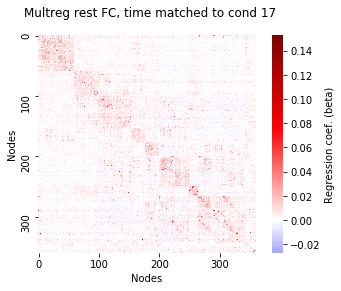

In [32]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFCMatchedTiming_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC, time matched to cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [33]:
#Analysis of task vs. rest matrix
#NOTE: MULTREG FC MATRICES ARE NOT SYMMETRIC (CAN'T JUST USE UPPER TRIANGLE OF MATRIX)

restFCDataMultreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]
diffMat=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]-restFCDataMultreg
#Remove diagonal
blankmat=np.ones((nParcels,nParcels))
upperTmat=np.triu(blankmat,k=1)
lowerTmat=np.tril(blankmat,k=-1)
offdiagmat=(upperTmat+lowerTmat)>0
diffMat_flat=diffMat[offdiagmat]
print('Minimum value: ' + str(min(diffMat_flat)))
print('Maximum value: ' + str(max(diffMat_flat)))
print('Mean value: ' + str(np.mean(diffMat_flat)))
print('Stdev value: ' + str(np.std(diffMat_flat)))

#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
diffMat_allsubj=np.mean(taskFC_mreg_bycond_bysubj,axis=2)-np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=2)
diffMat_allsubj_offdiag=np.transpose([diffMat_allsubj[:,:,subjN][offdiagmat] for subjN in np.arange(nSubjs)])

nConnections_mreg=int(nParcels*(nParcels-1))
print('Percent connections POSITIVE:', str(100*np.sum(diffMat[offdiagmat]>0)/nConnections_mreg))
print('Percent connections NEGATIVE:', str(100*np.sum(diffMat[offdiagmat]<0)/nConnections_mreg))

#FDR
tstats = [stats.ttest_1samp(diffMat_allsubj_offdiag[connnum,:],0.0) for connnum in np.arange(nConnections_mreg)]
tvals=np.array([tstats[connnum][0] for connnum in np.arange(nConnections_mreg)])
pvals=[tstats[connnum][1] for connnum in np.arange(nConnections_mreg)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
fdr_sigvector=pvals_FDRcorrected<0.05
#Bonferroni
# bonferroni_sigvector=pvals<(0.05/nConnections)

#MaxT
maxt_output=actflow.tools.max_t(diffMat_allsubj_offdiag)
maxTThreshold = maxt_output[1]
maxt_sigvector=np.array(maxt_output[2])<0.05
tvals=maxt_output[0]
#maxt_sigvector=np.abs(tvals)>maxTThreshold

totalconn=np.sum(maxt_sigvector)
poscon=np.sum(maxt_sigvector*(tvals>0))
negconn=np.sum(maxt_sigvector*(tvals<0))
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', totalconn)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', poscon)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', negconn)

print('')
percenttotal=100*np.sum(maxt_sigvector)/nConnections_mreg
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nConnections_mreg
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nConnections_mreg
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', percenttotal)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

print('')
percenttotal=100*np.sum(fdr_sigvector)/nConnections_mreg
percentpos=100*np.sum(fdr_sigvector*(tvals>0))/nConnections_mreg
percentneg=100*np.sum(fdr_sigvector*(tvals<0))/nConnections_mreg
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) TOTAL:', percenttotal)
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)


Minimum value: -0.045031264424832594
Maximum value: 0.012759983045665307
Mean value: -0.0001498655451833239
Stdev value: 0.0023529188842574987
Percent connections POSITIVE: 51.34246363354998
Percent connections NEGATIVE: 48.65753636645002
# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 3233
# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 339
# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 2894

Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 2.5015475085112966
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 0.26230269266480966
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 2.239244815846487

Percent significant connections (FDR corrected for multiple comparisons, p<0.05) TOTAL: 11.067007118539152
Percent significant connections (FDR corrected for mu

In [34]:
taskFCmeanMat_mreg=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)
restFCmeanMat_mreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)
upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat_mreg)[0],k=1)
resttask_mattcorr=np.corrcoef(taskFCmeanMat_mreg[upperTIndices_corrmat], restFCmeanMat_mreg[upperTIndices_corrmat])
print('Mean task to rest FC similarity, mreg: ', str(resttask_mattcorr))


Mean task to rest FC similarity, mreg:  [[1.         0.94269935]
 [0.94269935 1.        ]]


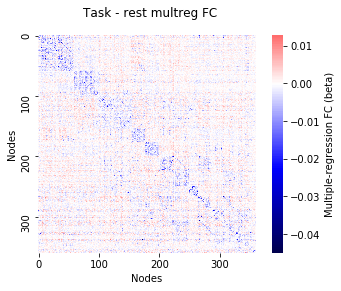

In [35]:
#Visualize FC matrix - mean task FC vs. rest FC
restFCDataMultreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]
diffMat=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]-restFCDataMultreg
FCMin=np.min(np.min(diffMat))
FCMax=np.max(np.max(diffMat))
ax = sns.heatmap(diffMat,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Task - rest multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meantaskFCVsRestFC_multreg_discovery176.pdf')


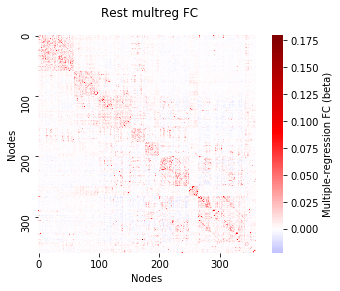

In [36]:
#Visualize FC matrix - mean rest FC
restFCDataMultreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]
FCMin=np.min(np.min(restFCDataMultreg))
FCMax=np.max(np.max(restFCDataMultreg))
ax = sns.heatmap(restFCDataMultreg,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Rest multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meanRestFC_tasktimematched_multreg_discovery176.pdf')


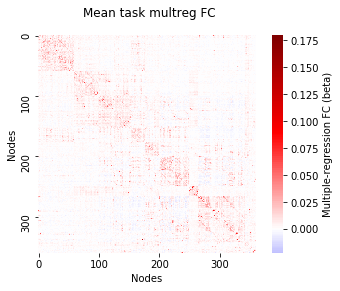

In [37]:
#Visualize FC matrix - mean task FC
FCMin=np.min(np.min(restFCDataMultreg))
FCMax=np.max(np.max(restFCDataMultreg))
mean_taskFC=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]
ax = sns.heatmap(mean_taskFC,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Mean task multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meanTaskFC_multreg_discovery176.pdf')


In [38]:
#Run actflow predictions, 24-condition rest multiple-regression FC, timing matched to task
print("==Activity flow mapping results, multiple-regression-based resting-state FC, TASK TIMING MATCHED, 24 task conditions==")
actflowOutput_restFCMRegMatchedTiming_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFCMatchedTiming_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, TASK TIMING MATCHED, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.46, t-value vs. 0: 81.20, p-value vs. 0: 7.582463385984874e-141
 
Mean % variance explained (R^2 score, coeff. of determination) = -0.29
 
Mean MAE (mean absolute error) = 11.94
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to p

In [39]:
np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['R2_nodewise_compthenavg_bycond'])

-0.2315675381664065

In [40]:
actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output'].keys()

dict_keys(['fullcomp_compthenavg_output', 'corr_fullcomp_compthenavg', 'R2_fullcomp_compthenavg', 'maeAcc_fullcomp_compthenavg', 'tval_ActflowPredAcc_fullcomp', 'pval_ActflowPredAcc_fullcomp', 'conditionwise_compthenavg_output', 'corr_conditionwise_compthenavg_bynode', 'R2_conditionwise_compthenavg_bynode', 'mae_conditionwise_compthenavg_bynode', 'nodewise_compthenavg_output', 'corr_nodewise_compthenavg_bycond', 'R2_nodewise_compthenavg_bycond', 'mae_nodewise_compthenavg_bycond'])

In [41]:
np.round(np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['R2_nodewise_compthenavg_bycond'],axis=1),2)

array([-0.17, -0.36, -0.05, -0.05, -2.32, -3.65,  0.21,  0.  , -0.01,
       -0.01, -0.03, -0.  ,  0.11,  0.13, -0.13, -0.07,  0.08,  0.02,
        0.16,  0.16,  0.15,  0.04,  0.11,  0.12])

In [42]:
np.round(np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['corr_nodewise_compthenavg_bycond'],axis=1),2)


array([0.41, 0.38, 0.52, 0.53, 0.31, 0.27, 0.53, 0.37, 0.36, 0.37, 0.34,
       0.37, 0.56, 0.57, 0.51, 0.53, 0.46, 0.4 , 0.51, 0.51, 0.51, 0.42,
       0.47, 0.48])

In [43]:
print("===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTimingActflow = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True, avgthencomp_fixedeffects=True)


===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.46
Model2 mean Pearson r=0.76
R-value difference = -0.31
Model1 vs. Model2 T-value: -93.97, p-value: 1.081422683882069e-151
 
Model1 mean % predicted variance explained R^2=-0.29
Model2 mean % predicted variance explained R^2=0.51
R^2 difference = -0.80
 
Model1 mean MAE = 11.94
Model2 mean MAE = 7.47
Model1 vs. Model2 mean MAE difference = 4.46
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not.

In [44]:
print("===Compare Task multregFC to Task corrFC actflow prediction===")
model_compare_TaskMultRegFCVsTaskCorrFCMatchTimingActflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCCorr['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Task multregFC to Task corrFC actflow prediction===


NameError: name 'actflowOutput_taskFCCorr' is not defined

In [ ]:
print("===Compare rest multregFC ALL DATA actflow predictions to Rest multregFC (matching timing) actflow prediction===")
model_compare_RestALLDATAMultRegFCVsRestMultRegFCMatchTimingActflow = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCMReg_bytask['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


## Visualizing prediction, rest and task multreg FC

/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


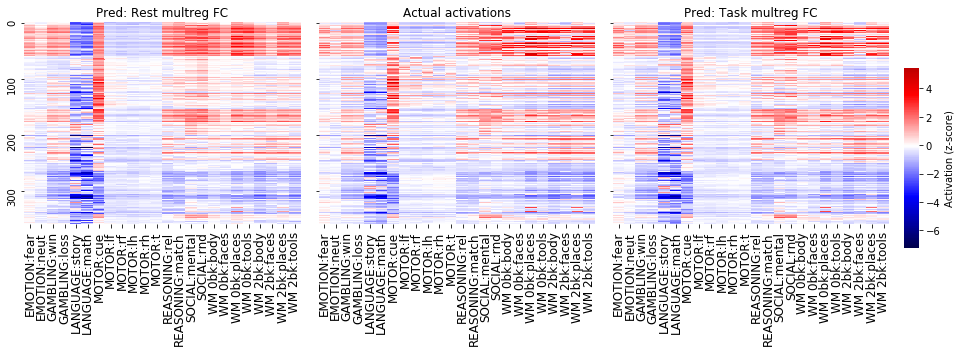

In [ ]:
#Visualize predicted and actual activations
data1=stats.zscore(np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
data2=stats.zscore(np.mean(activations_bycond,axis=2)[netorder,:],axis=None)
data3=stats.zscore(np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],axis=None)
datamin=min(np.array([min(data1.flatten()),min(data2.flatten()),min(data3.flatten())]))
datamax=max(np.array([max(data1.flatten()),max(data2.flatten()),max(data3.flatten())]))
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[14,5])
cbar_ax = fig.add_axes([.90, .3, .015, .5])
ax1 = sns.heatmap(data1,ax=axn[0],center=0,cmap='seismic',cbar=False,yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax1.title.set_text('Pred: Rest multreg FC')
ax2 = sns.heatmap(data2,ax=axn[1],center=0,cmap='seismic',cbar=False,yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax2.title.set_text('Actual activations')
ax3 = sns.heatmap(data3,ax=axn[2],center=0,cmap='seismic',cbar=True,cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (z-score)'},yticklabels=100,xticklabels=taskConditions,vmin=datamin,vmax=datamax)
ax3.title.set_text('Pred: Task multreg FC')
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 12)
ax2.set_xticklabels(ax2.get_xmajorticklabels(), fontsize = 12)
ax3.set_xticklabels(ax3.get_xmajorticklabels(), fontsize = 12)
fig.tight_layout(rect=[0, 0, .9, 1])
# fig=ax.get_figure()
fig.savefig(figuredir+'restTaskActflowPred_MultregFC_discovery176.pdf')

In [ ]:
# from importlib import reload
# actflow.tools = reload(actflow.tools)

#Save condition-wise accuracy for each node to surface map
#taskmultregFC
#Compute p-value threshold, using FDR correction for multiple comparisons
ttestinputdata=np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode']),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'taskActflowPred_condwise_MultregFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

#Max and min values
print('Maximum of map: ', np.max(datamat[datamat>0]))
print('Minimum of map: ', np.min(datamat[datamat>0]))

#restmultregFC
#Compute p-value threshold, using FDR correction for multiple comparisons
ttestinputdata=np.arctanh(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.arctanh(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode']),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'restMatchTaskActflowPred_condwise_MultregFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

#Max and min values
print('Maximum of map: ', np.max(datamat[datamat>0]))
print('Minimum of map: ', np.min(datamat[datamat>0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 100.0
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_MultregFC_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_MultregFC_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:/projects/f_mc1689_1/TaskFCActflow//docs/figures/taskActflowPred_condwise_MultregFC_discovery176.dscalar.nii
Maximum of map:  0.9060707599707769
Minimum of map:  0.3180311085521397
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 97.77777777777777
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/restMatchTaskActflowPred_condwise_MultregFC_discovery176.csv

In [ ]:
#Compare task-state and resting-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset=np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
restdataset=np.arctanh(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset,restdataset)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)
#Visualize data
datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
#Apply threshold
datamat=np.multiply(datamat,maxt_sigvector)
datamat=datamat[:,np.newaxis]
outfilename=figuredir+'taskVSrestMatchTaskActflowPred_condwise_MultregFC_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=False)

#Max and min values
print('Maximum of map: ', np.max(datamat[datamat!=0]))
print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 100.0
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_MultregFC_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_MultregFC_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:/projects/f_mc1689_1/TaskFCActflow//docs/figures/taskVSrestMatchTaskActflowPred_condwise_MultregFC_discovery176.dscalar.nii
Maximum of map:  0.6253418153931153
Minimum of map:  0.16809816330777846


Assessing relationship between task activation amplitudes and task-FC boost in actflow prediction accuracy
Mean correlation between activity amplitude & taskFC prediction accuracy boost: -0.01470131765029264
t-stat: -2.588188926012769
p-value: 0.010458995589780033


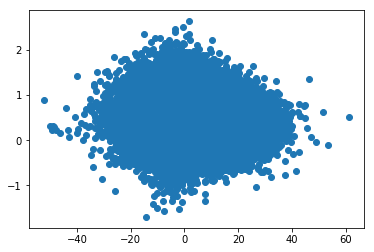

In [ ]:
#Assess relationship between task activation amplitudes and task-FC boost in actflow prediction accuracy
#Must average across conditions, because we need a separate estimate per region (condition-wise accuracy estimates)
#Spatial map correlations

print('Assessing relationship between task activation amplitudes and task-FC boost in actflow prediction accuracy')

taskdataset=np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
restdataset=np.arctanh(actflowOutput_restFCMRegMatchedTiming_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
task_vs_rest_predacc=np.subtract(taskdataset,restdataset)

actamplitudes_condavg=np.mean(activations_bycond,axis=1)

corrs_actamplitudes_taskVSrestpredacc=np.zeros(nSubjs)
scount = 0
for subj in subjNums:

    corrs_actamplitudes_taskVSrestpredacc[scount]=np.corrcoef(actamplitudes_condavg[:,scount],task_vs_rest_predacc[:,scount])[0,1]
    scount=scount+1
    
print('Mean correlation between activity amplitude & taskFC prediction accuracy boost:', np.mean(corrs_actamplitudes_taskVSrestpredacc))
tstats = stats.ttest_1samp(corrs_actamplitudes_taskVSrestpredacc,0.0)
print('t-stat:',tstats[0])
print('p-value:',tstats[1])

plt.scatter(actamplitudes_condavg,task_vs_rest_predacc)

In [ ]:
#Visualize specific task activations

#WM:2back:faces
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,21,:],axis=1)
data2=np.mean(activations_bycond[:,21,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,21,:],axis=1)

outfilename=figuredir+'restFC_ActflowPred_MultregFC_WM2backFacescond21_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data1=data1[:,np.newaxis]
actflow.tools.map_to_surface(data1,outfilename,fliphemispheres=False)

outfilename=figuredir+'actual_WM2backFacescond21_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data2=data2[:,np.newaxis]
actflow.tools.map_to_surface(data2,outfilename,fliphemispheres=False)

outfilename=figuredir+'taskFC_ActflowPred_MultregFC_WM2backFacescond21_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data3=data3[:,np.newaxis]
actflow.tools.map_to_surface(data3,outfilename,fliphemispheres=False)


#language:story
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,4,:],axis=1)
data2=np.mean(activations_bycond[:,4,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,4,:],axis=1)

outfilename=figuredir+'restFC_ActflowPred_MultregFC_LanguageStorycond4_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data1=data1[:,np.newaxis]
actflow.tools.map_to_surface(data1,outfilename,fliphemispheres=False)

outfilename=figuredir+'actual_LanguageStorycond4_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data2=data2[:,np.newaxis]
actflow.tools.map_to_surface(data2,outfilename,fliphemispheres=False)

outfilename=figuredir+'taskFC_ActflowPred_MultregFC_LanguageStorycond4_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data3=data3[:,np.newaxis]
actflow.tools.map_to_surface(data3,outfilename,fliphemispheres=False)


#motor:lh
condnum=9
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
data2=np.mean(activations_bycond[:,condnum,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)

outfilename=figuredir+'restFC_ActflowPred_MultregFC_MotorLHcond9_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data1=data1[:,np.newaxis]
actflow.tools.map_to_surface(data1,outfilename,fliphemispheres=False)

outfilename=figuredir+'actual_MotorLHcond9_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data2=data2[:,np.newaxis]
actflow.tools.map_to_surface(data2,outfilename,fliphemispheres=False)

outfilename=figuredir+'taskFC_ActflowPred_MultregFC_MotorLHcond9_discovery176'
#sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
data3=data3[:,np.newaxis]
actflow.tools.map_to_surface(data3,outfilename,fliphemispheres=False)


Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/restFC_ActflowPred_MultregFC_WM2backFacescond21_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs/figures/restFC_ActflowPred_MultregFC_WM2backFacescond21_discovery176.dscalar.nii -reset-scalars
CIFTI dscalar is output as:/projects/f_mc1689_1/TaskFCActflow//docs/figures/restFC_ActflowPred_MultregFC_WM2backFacescond21_discovery176.dscalar.nii
Command:
wb_command -cifti-convert -from-text /projects/f_mc1689_1/TaskFCActflow//docs/figures/actual_WM2backFacescond21_discovery176.csv /projectsn/f_mc1689_1/TaskFCActflow/TaskFCActflow_release/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii /projects/f_mc1689_1/TaskFCActflow//docs

In [ ]:
#Calculate R^2 similarities
from sklearn.metrics import r2_score

print('==WM:2back:faces, average-then-compare==')
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,21,:],axis=1)
data2=np.mean(activations_bycond[:,21,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,21,:],axis=1)
r2_data1vs2=r2_score(data2,data1)
print('restFC pred-to-actual R2=',r2_data1vs2)
r2_data3vs2=r2_score(data2,data3)
print('taskFC pred-to-actual R2=',r2_data3vs2)

print('==language:story, average-then-compare==')
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,4,:],axis=1)
data2=np.mean(activations_bycond[:,4,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,4,:],axis=1)
r2_data1vs2=r2_score(data2,data1)
print('restFC pred-to-actual R2=',r2_data1vs2)
r2_data3vs2=r2_score(data2,data3)
print('taskFC pred-to-actual R2=',r2_data3vs2)

print('==motor:lh, average-then-compare==')
data1=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,10,:],axis=1)
data2=np.mean(activations_bycond[:,9,:],axis=1)
data3=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,10,:],axis=1)
r2_data1vs2=r2_score(data2,data1)
print('restFC pred-to-actual R2=',r2_data1vs2)
r2_data3vs2=r2_score(data2,data3)
print('taskFC pred-to-actual R2=',r2_data3vs2)

==WM:2back:faces, average-then-compare==
restFC pred-to-actual R2= 0.5774068310097404
taskFC pred-to-actual R2= 0.9135813259411614
==language:story, average-then-compare==
restFC pred-to-actual R2= 0.8444741279707699
taskFC pred-to-actual R2= 0.9750305651827432
==motor:lh, average-then-compare==
restFC pred-to-actual R2= 0.33809614205498995
taskFC pred-to-actual R2= 0.47232920324216676


In [ ]:
#Calculate R^2 similarities, each subject separately
from sklearn.metrics import r2_score

print('==WM:2back:faces, compare-then-average==')
r2_data1vs2=np.zeros(nSubjs)
r2_data3vs2=np.zeros(nSubjs)
scount=0
for subj in subjNums:
    data1=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,21,scount]
    data2=activations_bycond[:,21,scount]
    data3=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,21,scount]
    r2_data1vs2[scount]=r2_score(data2,data1)
    r2_data3vs2[scount]=r2_score(data2,data3)
    scount += 1
print('restFC pred-to-actual R2=',np.mean(r2_data1vs2))
print('taskFC pred-to-actual R2=',np.mean(r2_data3vs2))

print('==language:story, compare-then-average==')
condnum=4
r2_data1vs2=np.zeros(nSubjs)
r2_data3vs2=np.zeros(nSubjs)
scount=0
for subj in subjNums:
    data1=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,scount]
    data2=activations_bycond[:,condnum,scount]
    data3=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,scount]
    r2_data1vs2[scount]=r2_score(data2,data1)
    r2_data3vs2[scount]=r2_score(data2,data3)
    scount += 1
print('restFC pred-to-actual R2=',np.mean(r2_data1vs2))
print('taskFC pred-to-actual R2=',np.mean(r2_data3vs2))

print('==motor:lh, compare-then-average==')
condnum=9
r2_data1vs2=np.zeros(nSubjs)
r2_data3vs2=np.zeros(nSubjs)
scount=0
for subj in subjNums:
    data1=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,scount]
    data2=activations_bycond[:,condnum,scount]
    data3=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,scount]
    r2_data1vs2[scount]=r2_score(data2,data1)
    r2_data3vs2[scount]=r2_score(data2,data3)
    scount += 1
print('restFC pred-to-actual R2=',np.mean(r2_data1vs2))
print('taskFC pred-to-actual R2=',np.mean(r2_data3vs2))


==WM:2back:faces, compare-then-average==
restFC pred-to-actual R2= 0.040453644437620444
taskFC pred-to-actual R2= 0.5850466614803417
==language:story, compare-then-average==
restFC pred-to-actual R2= -2.3227705302603057
taskFC pred-to-actual R2= 0.046442244221180484
==motor:lh, compare-then-average==
restFC pred-to-actual R2= -0.005768505157595084
taskFC pred-to-actual R2= 0.2569560023554915


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


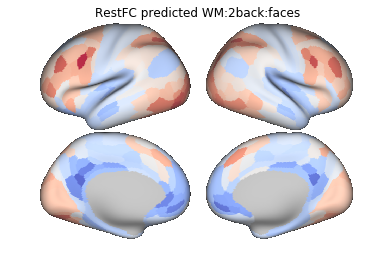

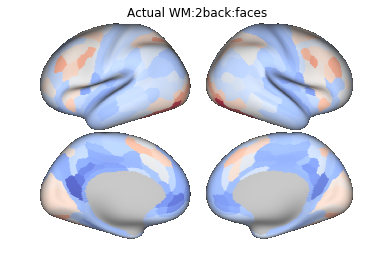

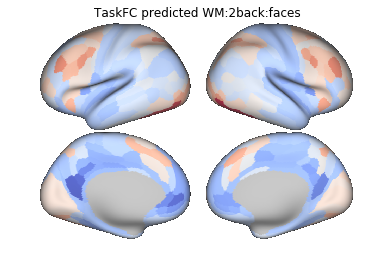

In [ ]:
#Plotting images in-line, WM:2back:faces

from wbplot import pscalar
import matplotlib.image as mpimg

condlabel='WM:2back:faces'
condnum=21

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('RestFC predicted '+condlabel)
plt.imshow(img)

#Actual
inputdata=np.mean(activations_bycond[:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual '+condlabel)
plt.imshow(img)

#TaskFC predicted
inputdata=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('TaskFC predicted '+condlabel)
plt.imshow(img)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


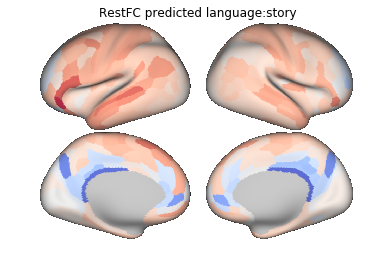

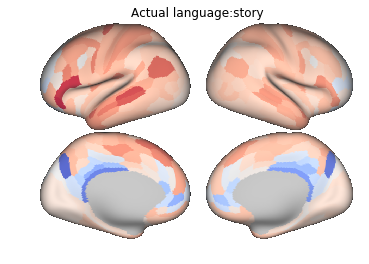

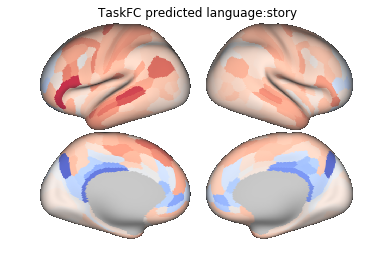

In [ ]:
#Plotting images in-line, language:story

from wbplot import pscalar
import matplotlib.image as mpimg

condlabel='language:story'
condnum=4

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('RestFC predicted '+condlabel)
plt.imshow(img)

#Actual
inputdata=np.mean(activations_bycond[:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual '+condlabel)
plt.imshow(img)

#TaskFC predicted
inputdata=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('TaskFC predicted '+condlabel)
plt.imshow(img)



pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


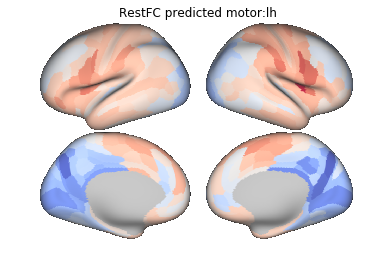

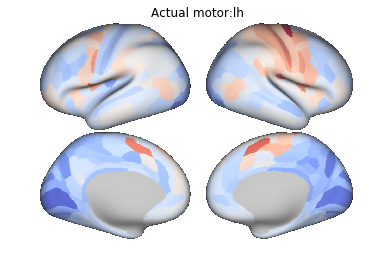

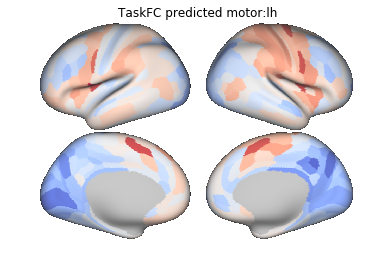

In [ ]:
#Plotting images in-line, motor:lh

from wbplot import pscalar
import matplotlib.image as mpimg

condlabel='motor:lh'
condnum=9

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('RestFC predicted '+condlabel)
plt.imshow(img)

#Actual
inputdata=np.mean(activations_bycond[:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual '+condlabel)
plt.imshow(img)

#TaskFC predicted
inputdata=np.mean(actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'][:,condnum,:],axis=1)
#flip hemispheres
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap='coolwarm',
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('TaskFC predicted '+condlabel)
plt.imshow(img)



## Focus on negative connections and actflow increases

### Negative LESIONED: All (unthresholded) task vs. rest FC changes

In [ ]:

#Analysis of task vs. rest matrix
restFCDataMultreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]
diffMat=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)[netorder,:][:,netorder]-restFCDataMultreg
#Remove diagonal
blankmat=np.ones((nParcels,nParcels))
upperTmat=np.triu(blankmat,k=1)
lowerTmat=np.tril(blankmat,k=-1)
offdiagmat=(upperTmat+lowerTmat)>0
diffMat_flat=diffMat[offdiagmat]
print('Minimum value: ' + str(min(diffMat_flat)))
print('Maximum value: ' + str(max(diffMat_flat)))
print('Mean value: ' + str(np.mean(diffMat_flat)))
print('Stdev value: ' + str(np.std(diffMat_flat)))



Minimum value: -0.045031264424832594
Maximum value: 0.012759983045665307
Mean value: -0.0001498655451833239
Stdev value: 0.0023529188842574987


In [ ]:
#Analyze number an magnitude of FC decreases vs. increases

diffMat_taskvsrest=taskFC_mreg_bycond_bysubj-restFCMatchedTiming_mreg_bycond_bysubj

diffMat_taskvsrest_offdiag=np.zeros((nConnections_mreg,nConds,nSubjs))
for taskcond_num in np.arange(nConds):
    
    scount = 0
    for subj in subjNums:

        diffMat_thissubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,scount]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,scount]
        diffMat_thissubj_offdiag=diffMat_thissubj[offdiagmat]
        diffMat_taskvsrest_offdiag[:,taskcond_num,scount]=diffMat_thissubj_offdiag
        scount=scount+1
        
nTotalConnections=nConnections_mreg*np.shape(diffMat_taskvsrest)[2]*np.shape(diffMat_taskvsrest)[3]
nFCReductions=np.sum(np.sum(np.sum(diffMat_taskvsrest_offdiag<0)))
nFCIncreases=np.sum(np.sum(np.sum(diffMat_taskvsrest_offdiag>0)))
print('Percent rest-to-task FC reductions:', 100*nFCReductions/nTotalConnections)
print('Percent rest-to-task FC increases:', 100*nFCIncreases/nTotalConnections)
print('Average amplitude of rest-to-task FC reductions:', np.sum(np.sum(np.sum(diffMat_taskvsrest_offdiag*(diffMat_taskvsrest_offdiag<0))))/nFCReductions)
print('Average amplitude of rest-to-task FC increases:', np.sum(np.sum(np.sum(diffMat_taskvsrest_offdiag*(diffMat_taskvsrest_offdiag>0))))/nFCIncreases)
print('Min amplitude of rest-to-task FC reductions:', np.min(np.min(np.min(diffMat_taskvsrest_offdiag*(diffMat_taskvsrest_offdiag<0))))/nFCReductions)
print('Max amplitude of rest-to-task FC increases:', np.max(np.max(np.max(diffMat_taskvsrest_offdiag*(diffMat_taskvsrest_offdiag>0))))/nFCIncreases)


Percent rest-to-task FC reductions: 50.19767479518959
Percent rest-to-task FC increases: 49.80232520481041
Average amplitude of rest-to-task FC reductions: -0.04609992414249636
Average amplitude of rest-to-task FC increases: 0.046164961901167124
Min amplitude of rest-to-task FC reductions: -1.7964395165992767e-08
Max amplitude of rest-to-task FC increases: 1.7810292552148355e-08


In [ ]:
#LESION rest-to-task FC decreases only

taskFC_signegonlyLESIONED_mreg_bycond_bysubj_offdiag=np.zeros((nConnections_mreg,nConds,nSubjs))
taskFC_signegonlyLESIONED_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
for taskcond_num in np.arange(nConds):
    
    diffMat_allsubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,:]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,:]
    diffMat_allsubj_offdiag=np.transpose([diffMat_allsubj[:,:,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    diffMat_subjmean_offdiag=np.mean(diffMat_allsubj_offdiag,axis=1)
    #mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0) * (maxt_sigvector_bycond[:,taskcond_num]>0))
    mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0))
    
    taskFC_mreg_bysubj_offdiag=np.transpose([taskFC_mreg_bycond_bysubj[:,:,taskcond_num,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    
    scount = 0
    for subj in subjNums:
        
        diffMat_thissubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,scount]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,scount]
        diffMat_thissubj_offdiag=diffMat_thissubj[offdiagmat]
        mask_negonlyLESIONED_thissubj_offdiag=1-((diffMat_thissubj_offdiag<0))
        
        taskFC_signegonlyLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount]=taskFC_mreg_bysubj_offdiag[:,scount]*mask_negonlyLESIONED_thissubj_offdiag
        matrix_temp=np.zeros((nParcels,nParcels))
        matrix_temp[offdiagmat]=taskFC_signegonlyLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount].copy()
        taskFC_signegonlyLESIONED_mreg_bycond_bysubj[:,:,taskcond_num,scount]=matrix_temp.copy()
        scount=scount+1


In [ ]:
#Calculate task-state FC actflow with task-reduced FC values LESIONED

#Run actflow predictions, 24-condition task multiple-regression FC, task-reduced FC values only
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, task-reduced FC values LESIONED==")
actflowOutput_taskFCMReg_bycond_signegonlyLESIONED = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_signegonlyLESIONED_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, task-reduced FC values LESIONED==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 77.33, p-value vs. 0: 3.1283836681798124e-137
 
Mean % variance explained (R^2 score, coeff. of determination) = -7.96
 
Mean MAE (mean absolute error) = 22.53
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily l

In [ ]:
#Also threshold resting-state FC to match increase-LESIONED task FC (same connections as above, but now applied to rest FC)
restFC_signegLESIONED_mreg_bycond_bysubj_offdiag=np.zeros((nConnections_mreg,nConds,nSubjs))
restFC_signegLESIONED_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
for taskcond_num in np.arange(nConds):
    
    diffMat_allsubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,:]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,:]
    diffMat_allsubj_offdiag=np.transpose([diffMat_allsubj[:,:,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    diffMat_subjmean_offdiag=np.mean(diffMat_allsubj_offdiag,axis=1)
    #mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0) * (maxt_sigvector_bycond[:,taskcond_num]>0))
    mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0))
    
    restFC_mreg_bysubj_offdiag=np.transpose([restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    
    scount = 0
    for subj in subjNums:
        
        diffMat_thissubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,scount]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,scount]
        diffMat_thissubj_offdiag=diffMat_thissubj[offdiagmat]
        mask_negonlyLESIONED_thissubj_offdiag=1-((diffMat_thissubj_offdiag<0))
        
        restFC_signegLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount]=restFC_mreg_bysubj_offdiag[:,scount]*mask_negonlyLESIONED_thissubj_offdiag
        matrix_temp=np.zeros((nParcels,nParcels))
        matrix_temp[offdiagmat]=restFC_signegLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount].copy()
        restFC_signegLESIONED_mreg_bycond_bysubj[:,:,taskcond_num,scount]=matrix_temp.copy()
        scount=scount+1


In [ ]:
#Calculate resting-state FC actflow using task-reduced FC values LESIONED

#Run actflow predictions, 24-condition task multiple-regression FC, task-reduced FC values only
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions, task-reduced FC values LESIONED==")
actflowOutput_restFCMReg_bycond_signegonlyLESIONED = actflow.actflowcomp.actflowtest(activations_bycond, restFC_signegLESIONED_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions, task-reduced FC values LESIONED==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = -0.13, t-value vs. 0: -11.12, p-value vs. 0: 4.630721960124088e-22
 
Mean % variance explained (R^2 score, coeff. of determination) = -14.24
 
Mean MAE (mean absolute error) = 28.53
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrari

In [ ]:
print("===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, task-reduced FC values LESIONED===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTimingActflow_signegLESIONED = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond_signegonlyLESIONED['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCMReg_bycond_signegonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, task-reduced FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.48
Model2 mean Pearson r=-0.13
R-value difference = 0.61
Model1 vs. Model2 T-value: 48.21, p-value: 5.698631252050015e-103
 
Model1 mean % predicted variance explained R^2=-7.96
Model2 mean % predicted variance explained R^2=-14.24
R^2 difference = 6.28
 
Model1 mean MAE = 22.53
Model2 mean MAE = 28.53
Model1 vs. Model2 mean MAE difference = -6.00
 
Note: Pearson r and Pearson r^2 are scale-in

In [ ]:
print("===Compare regular Task multregFC actflow predictions to Task multregFC actflow predictions with task-reduced FC values LESIONED===")
model_compare_TaskMultRegFCVsTaskMultRegFCsignegLESIONED_Actflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_bycond_signegonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare regular Task multregFC actflow predictions to Task multregFC actflow predictions with task-reduced FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.76
Model2 mean Pearson r=0.48
R-value difference = 0.29
Model1 vs. Model2 T-value: 59.08, p-value: 1.5700727407899031e-117
 
Model1 mean % predicted variance explained R^2=0.51
Model2 mean % predicted variance explained R^2=-7.96
R^2 difference = 8.47
 
Model1 mean MAE = 7.47
Model2 mean MAE = 22.53
Model1 vs. Model2 mean MAE difference = -15.06
 
Note: Pearson r and Pearson r^2 are scale-invariant

In [ ]:
print("===Compare regular Rest time-matched multregFC actflow predictions to Rest time-matched multregFC actflow predictions with task-reduced FC values LESIONED===")
model_compare_RestMultRegFCVsRestMultRegFCsignegLESIONED_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCMReg_bycond_signegonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare regular Rest time-matched multregFC actflow predictions to Rest time-matched multregFC actflow predictions with task-reduced FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.46
Model2 mean Pearson r=-0.13
R-value difference = 0.59
Model1 vs. Model2 T-value: 44.88, p-value: 6.179237662923991e-98
 
Model1 mean % predicted variance explained R^2=-0.29
Model2 mean % predicted variance explained R^2=-14.24
R^2 difference = 13.95
 
Model1 mean MAE = 11.94
Model2 mean MAE = 28.53
Model1 vs. Model2 mean MAE difference = -16.59
 
Note: Pearson r and Pe

In [ ]:

#Calculate actflows manually
actflows_taskFC_negLESIONED=np.zeros((nParcels,nParcels,nConds,nSubjs))
scount = 0
for subj in subjNums:
    for cond in np.arange(24):
        
        for heldOutRegion in np.arange(nParcels):
            otherRegions=list(range(nParcels))
            otherRegions.remove(heldOutRegion)
            actflows_taskFC_negLESIONED[heldOutRegion,otherRegions,cond,scount]=activations_bycond[otherRegions,cond,scount]*taskFC_signegonlyLESIONED_mreg_bycond_bysubj[heldOutRegion,otherRegions,cond,scount]
        
    scount=scount+1

In [ ]:
#Quantify percentage of positive actflows (i.e., actflow increases given that rest is baseline) with FC decreases lesioned

actflows_taskFC_negLESIONED_flat=actflows_taskFC_negLESIONED.flatten()

num_pos_actflows=np.sum(actflows_taskFC_negLESIONED_flat>0)
num_actflows_total=np.shape(actflows_taskFC_negLESIONED_flat)[0]
print("Percentage of positive actflows, with all rest-to-task FC reductions lesioned:", 100*num_pos_actflows/num_actflows_total)

num_zero_actflows=np.sum(actflows_taskFC_negLESIONED_flat==0)
print("Percentage of 0-flow actflows, with all rest-to-task FC reductions lesioned:", 100*num_zero_actflows/num_actflows_total)

num_neg_actflows=np.sum(actflows_taskFC_negLESIONED_flat<0)
print("Percentage of negative actflows, with all rest-to-task FC reductions lesioned:", 100*num_neg_actflows/num_actflows_total)

num_pos_actflows=np.sum(actflows_taskFC_negLESIONED_flat>0)
num_actflows_totalnonzero=np.sum(actflows_taskFC_negLESIONED_flat!=0)
print("Percentage of positive actflows among non-zeros, with all rest-to-task FC reductions lesioned:", 100*num_pos_actflows/num_actflows_totalnonzero)

num_neg_actflows=np.sum(actflows_taskFC_negLESIONED_flat<0)
print("Percentage of negative actflows among non-zeros, with all rest-to-task FC reductions lesioned:", 100*num_neg_actflows/num_actflows_totalnonzero)



Percentage of positive actflows, with all rest-to-task FC reductions lesioned: 24.90765127402497
Percentage of 0-flow actflows, with all rest-to-task FC reductions lesioned: 50.336014587425176
Percentage of negative actflows, with all rest-to-task FC reductions lesioned: 24.75633413854985
Percentage of positive actflows among non-zeros, with all rest-to-task FC reductions lesioned: 50.152340910841204
Percentage of negative actflows among non-zeros, with all rest-to-task FC reductions lesioned: 49.847659089158796


[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

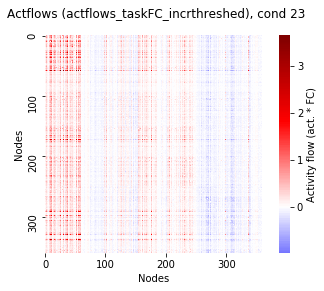

In [ ]:
#Visualize actflow matrix
ax = sns.heatmap(np.mean(actflows_taskFC_negLESIONED[netorder,:,22,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Activity flow (act. * FC)'})
ax.figure.suptitle('Actflows (actflows_taskFC_incrthreshed), cond 23')
ax.set(xlabel='Nodes',ylabel='Nodes')

### Positive LESIONED: All (unthresholded) task vs. rest FC changes

In [ ]:
#LESION rest-to-task FC increases only

taskFC_posonlyLESIONED_mreg_bycond_bysubj_offdiag=np.zeros((nConnections_mreg,nConds,nSubjs))
taskFC_posonlyLESIONED_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
for taskcond_num in np.arange(nConds):
    
    diffMat_allsubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,:]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,:]
    diffMat_allsubj_offdiag=np.transpose([diffMat_allsubj[:,:,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    diffMat_subjmean_offdiag=np.mean(diffMat_allsubj_offdiag,axis=1)
    #mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0) * (maxt_sigvector_bycond[:,taskcond_num]>0))
    mask_posonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag>0))
    
    taskFC_mreg_bysubj_offdiag=np.transpose([taskFC_mreg_bycond_bysubj[:,:,taskcond_num,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    
    scount = 0
    for subj in subjNums:
        
        diffMat_thissubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,scount]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,scount]
        diffMat_thissubj_offdiag=diffMat_thissubj[offdiagmat]
        mask_posonlyLESIONED_thissubj_offdiag=1-((diffMat_thissubj_offdiag>0))
        
        taskFC_posonlyLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount]=taskFC_mreg_bysubj_offdiag[:,scount]*mask_posonlyLESIONED_thissubj_offdiag
        matrix_temp=np.zeros((nParcels,nParcels))
        matrix_temp[offdiagmat]=taskFC_posonlyLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount].copy()
        taskFC_posonlyLESIONED_mreg_bycond_bysubj[:,:,taskcond_num,scount]=matrix_temp.copy()
        scount=scount+1


In [ ]:
#Calculate task-state FC actflow with task-increased FC values LESIONED

#Run actflow predictions, 24-condition task multiple-regression FC, task-reduced FC values only
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, task-increased FC values LESIONED==")
actflowOutput_taskFCMReg_bycond_posonlyLESIONED = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_posonlyLESIONED_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, task-increased FC values LESIONED==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = -0.20, t-value vs. 0: -19.06, p-value vs. 0: 1.4588303457772635e-44
 
Mean % variance explained (R^2 score, coeff. of determination) = -10.24
 
Mean MAE (mean absolute error) = 26.91
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrari

In [ ]:
#Also threshold resting-state FC to match increase-LESIONED task FC (same connections as above, but now applied to rest FC)
restFC_posLESIONED_mreg_bycond_bysubj_offdiag=np.zeros((nConnections_mreg,nConds,nSubjs))
restFC_posLESIONED_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
for taskcond_num in np.arange(nConds):
    
    diffMat_allsubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,:]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,:]
    diffMat_allsubj_offdiag=np.transpose([diffMat_allsubj[:,:,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    diffMat_subjmean_offdiag=np.mean(diffMat_allsubj_offdiag,axis=1)
    #mask_negonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag<0) * (maxt_sigvector_bycond[:,taskcond_num]>0))
    mask_posonlyLESIONED_offdiag=1-((diffMat_subjmean_offdiag>0))
    
    restFC_mreg_bysubj_offdiag=np.transpose([restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,subjN][offdiagmat] for subjN in np.arange(nSubjs)])
    
    scount = 0
    for subj in subjNums:
        
        diffMat_thissubj=taskFC_mreg_bycond_bysubj[:,:,taskcond_num,scount]-restFCMatchedTiming_mreg_bycond_bysubj[:,:,taskcond_num,scount]
        diffMat_thissubj_offdiag=diffMat_thissubj[offdiagmat]
        mask_posonlyLESIONED_thissubj_offdiag=1-((diffMat_thissubj_offdiag>0))
        
        restFC_posLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount]=restFC_mreg_bysubj_offdiag[:,scount]*mask_posonlyLESIONED_thissubj_offdiag
        matrix_temp=np.zeros((nParcels,nParcels))
        matrix_temp[offdiagmat]=restFC_posLESIONED_mreg_bycond_bysubj_offdiag[:,taskcond_num,scount].copy()
        restFC_posLESIONED_mreg_bycond_bysubj[:,:,taskcond_num,scount]=matrix_temp.copy()
        scount=scount+1


In [ ]:
#Calculate resting-state FC actflow using task-increased FC values LESIONED

#Run actflow predictions, 24-condition task multiple-regression FC, task-reduced FC values only
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions, task-increased FC values LESIONED==")
actflowOutput_restFCMReg_bycond_posonlyLESIONED = actflow.actflowcomp.actflowtest(activations_bycond, restFC_posLESIONED_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions, task-increased FC values LESIONED==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.31, t-value vs. 0: 50.68, p-value vs. 0: 1.595035867179409e-106
 
Mean % variance explained (R^2 score, coeff. of determination) = -12.41
 
Mean MAE (mean absolute error) = 25.81
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrar

In [ ]:
print("===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, task-increased FC values LESIONED===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTimingActflow_posLESIONED = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond_posonlyLESIONED['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCMReg_bycond_posonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, task-increased FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=-0.20
Model2 mean Pearson r=0.31
R-value difference = -0.51
Model1 vs. Model2 T-value: -32.81, p-value: 1.107379925214437e-76
 
Model1 mean % predicted variance explained R^2=-10.24
Model2 mean % predicted variance explained R^2=-12.41
R^2 difference = 2.17
 
Model1 mean MAE = 26.91
Model2 mean MAE = 25.81
Model1 vs. Model2 mean MAE difference = 1.10
 
Note: Pearson r and Pearson r^2 are scale

In [ ]:
print("===Compare regular Task multregFC actflow predictions to Task multregFC actflow predictions with task-increased FC values LESIONED===")
model_compare_TaskMultRegFCVsTaskMultRegFCposLESIONED_Actflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_bycond_posonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare regular Task multregFC actflow predictions to Task multregFC actflow predictions with task-increased FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.76
Model2 mean Pearson r=-0.20
R-value difference = 0.96
Model1 vs. Model2 T-value: 87.08, p-value: 5.019307265436631e-146
 
Model1 mean % predicted variance explained R^2=0.51
Model2 mean % predicted variance explained R^2=-10.24
R^2 difference = 10.76
 
Model1 mean MAE = 7.47
Model2 mean MAE = 26.91
Model1 vs. Model2 mean MAE difference = -19.43
 
Note: Pearson r and Pearson r^2 are scale-invar

In [ ]:
print("===Compare regular Rest time-matched multregFC actflow predictions to Rest time-matched multregFC actflow predictions with task-increased FC values LESIONED===")
model_compare_RestMultRegFCVsRestMultRegFCposLESIONED_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMRegMatchedTiming_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCMReg_bycond_posonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare regular Rest time-matched multregFC actflow predictions to Rest time-matched multregFC actflow predictions with task-increased FC values LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.46
Model2 mean Pearson r=0.31
R-value difference = 0.14
Model1 vs. Model2 T-value: 24.68, p-value: 7.04099032331946e-59
 
Model1 mean % predicted variance explained R^2=-0.29
Model2 mean % predicted variance explained R^2=-12.41
R^2 difference = 12.12
 
Model1 mean MAE = 11.94
Model2 mean MAE = 25.81
Model1 vs. Model2 mean MAE difference = -13.87
 
Note: Pearson r and Pe

In [ ]:
print("===Compare regular Task multregFC negative LESIONED actflow predictions to Task multregFC actflow predictions with positive LESIONED===")
model_compare_TaskMultRegFCnegLESIONEDVsTaskMultRegFCposLESIONED_Actflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond_signegonlyLESIONED['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_bycond_posonlyLESIONED['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare regular Task multregFC negative LESIONED actflow predictions to Task multregFC actflow predictions with positive LESIONED===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.48
Model2 mean Pearson r=-0.20
R-value difference = 0.67
Model1 vs. Model2 T-value: 49.73, p-value: 3.545454902141102e-105
 
Model1 mean % predicted variance explained R^2=-7.96
Model2 mean % predicted variance explained R^2=-10.24
R^2 difference = 2.28
 
Model1 mean MAE = 22.53
Model2 mean MAE = 26.91
Model1 vs. Model2 mean MAE difference = -4.38
 
Note: Pearson r and Pearson r^2 are scale-inv

In [ ]:

#Calculate actflows manually
actflows_taskFC_posLESIONED=np.zeros((nParcels,nParcels,nConds,nSubjs))
scount = 0
for subj in subjNums:
    for cond in np.arange(24):
        
        for heldOutRegion in np.arange(nParcels):
            otherRegions=list(range(nParcels))
            otherRegions.remove(heldOutRegion)
            actflows_taskFC_posLESIONED[heldOutRegion,otherRegions,cond,scount]=activations_bycond[otherRegions,cond,scount]*taskFC_posonlyLESIONED_mreg_bycond_bysubj[heldOutRegion,otherRegions,cond,scount]
        
    scount=scount+1

In [ ]:
#Quantify percentage of positive actflows (i.e., actflow increases given that rest is baseline) with FC decreases lesioned

actflows_taskFC_posLESIONED_flat=actflows_taskFC_posLESIONED.flatten()

num_pos_actflows=np.sum(actflows_taskFC_posLESIONED_flat>0)
num_actflows_total=np.shape(actflows_taskFC_posLESIONED_flat)[0]
print("Percentage of positive actflows, with all rest-to-task FC increases lesioned:", 100*num_pos_actflows/num_actflows_total)

num_zero_actflows=np.sum(actflows_taskFC_posLESIONED_flat==0)
print("Percentage of 0-flow actflows, with all rest-to-task FC increases lesioned:", 100*num_zero_actflows/num_actflows_total)

num_neg_actflows=np.sum(actflows_taskFC_posLESIONED_flat<0)
print("Percentage of negative actflows, with all rest-to-task FC increases lesioned:", 100*num_neg_actflows/num_actflows_total)

num_pos_actflows=np.sum(actflows_taskFC_posLESIONED_flat>0)
num_actflows_totalnonzero=np.sum(actflows_taskFC_posLESIONED_flat!=0)
print("Percentage of positive actflows among non-zeros, with all rest-to-task FC increases lesioned:", 100*num_pos_actflows/num_actflows_totalnonzero)

num_neg_actflows=np.sum(actflows_taskFC_posLESIONED_flat<0)
print("Percentage of negative actflows among non-zeros, with all rest-to-task FC increases lesioned:", 100*num_neg_actflows/num_actflows_totalnonzero)



Percentage of positive actflows, with all rest-to-task FC increases lesioned: 25.0287042882529
Percentage of 0-flow actflows, with all rest-to-task FC increases lesioned: 49.9417631903526
Percentage of negative actflows, with all rest-to-task FC increases lesioned: 25.0295325213945
Percentage of positive actflows among non-zeros, with all rest-to-task FC increases lesioned: 49.999172730409235
Percentage of negative actflows among non-zeros, with all rest-to-task FC increases lesioned: 50.000827269590765


[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

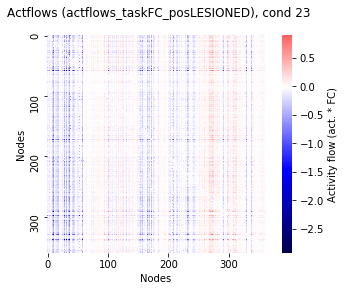

In [ ]:
#Visualize actflow matrix
ax = sns.heatmap(np.mean(actflows_taskFC_posLESIONED[netorder,:,22,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Activity flow (act. * FC)'})
ax.figure.suptitle('Actflows (actflows_taskFC_posLESIONED), cond 23')
ax.set(xlabel='Nodes',ylabel='Nodes')

## Using task-general FC (multreg FC calculated across all tasks simultaneously)

In [ ]:
## Calculating multreg task-general FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregTaskGenFC_data'

taskgenFC_mreg_bysubj=np.zeros((nParcels,nParcels,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        taskgenFC_mreg_bysubj[:,:,scount] = h5f['taskgenFCRegression'][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
        
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("tasktiming_all=np.array(np.sum(tasktiming_bycond,axis=1)>0)\n")
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("taskgenFC_mreg_bysubj=actflow.connectivity_estimation.multregconn(taskdata[:,tasktiming_all])\n")
        file_python.write("#Save multiple-regression task FC data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'taskgenFCRegression'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=taskgenFC_mreg_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=taskgenFC_mreg_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:02:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

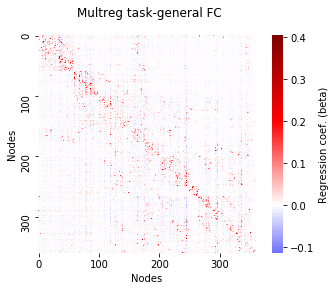

In [ ]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskgenFC_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task-general FC')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [ ]:
taskFCmeanMat_mreg=np.mean(taskgenFC_mreg_bysubj,axis=2)
restFCmeanMat_mreg=np.mean(restFC_mreg_bysubj,axis=2)
upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat_mreg)[0],k=1)
resttask_mattcorr=np.corrcoef(taskFCmeanMat_mreg[upperTIndices_corrmat], restFCmeanMat_mreg[upperTIndices_corrmat])
print('Mean task-gen. to rest FC similarity, mreg: ', str(resttask_mattcorr))


Mean task-gen. to rest FC similarity, mreg:  [[1.         0.95087532]
 [0.95087532 1.        ]]


In [ ]:
#Analysis of task vs. rest matrix
restFCDataMultreg=np.mean(restFC_mreg_bysubj,axis=2)[netorder,:][:,netorder]
diffMat=np.mean(taskgenFC_mreg_bysubj,axis=2)[netorder,:][:,netorder]-restFCDataMultreg
print('Minimum value: ' + str(min(diffMat.flatten())))
print('Maximum value: ' + str(max(diffMat.flatten())))
print('Mean value: ' + str(np.mean(diffMat.flatten())))
print('Stdev value: ' + str(np.std(diffMat.flatten())))

#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
diffMat_allsubj=taskgenFC_mreg_bysubj-restFC_mreg_bysubj
upperTIndices_corrmat=np.triu_indices(np.shape(diffMat_allsubj)[0],k=1)
diffMat_allsubj_upperT=np.transpose([diffMat_allsubj[:,:,subjN][upperTIndices_corrmat] for subjN in np.arange(nSubjs)])

nConnections=int(nParcels*(nParcels-1)/2)
print('Percent connections POSITIVE:', str(100*np.sum(diffMat[upperTIndices_corrmat]>0)/nConnections))
print('Percent connections NEGATIVE:', str(100*np.sum(diffMat[upperTIndices_corrmat]<0)/nConnections))

#FDR
tstats = [stats.ttest_1samp(diffMat_allsubj_upperT[connnum,:],0.0) for connnum in np.arange(nConnections)]
tvals=np.array([tstats[connnum][0] for connnum in np.arange(nConnections)])
pvals=[tstats[connnum][1] for connnum in np.arange(nConnections)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
fdr_sigvector=pvals_FDRcorrected<0.05
#Bonferroni
# bonferroni_sigvector=pvals<(0.05/nConnections)

#MaxT
maxt_output=actflow.tools.max_t(diffMat_allsubj_upperT)
maxTThreshold = maxt_output[1]
maxt_sigvector=np.array(maxt_output[2])<0.05
tvals=maxt_output[0]
#maxt_sigvector=np.abs(tvals)>maxTThreshold

totalconn=np.sum(maxt_sigvector)
poscon=np.sum(maxt_sigvector*(tvals>0))
negconn=np.sum(maxt_sigvector*(tvals<0))
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', totalconn)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', poscon)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', negconn)

print('')
percenttotal=100*np.sum(maxt_sigvector)/nConnections
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nConnections
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nConnections
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', percenttotal)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

print('')
percenttotal=100*np.sum(fdr_sigvector)/nConnections
percentpos=100*np.sum(fdr_sigvector*(tvals>0))/nConnections
percentneg=100*np.sum(fdr_sigvector*(tvals<0))/nConnections
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) TOTAL:', percenttotal)
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant connections (FDR corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)


Minimum value: -0.19537868931596186
Maximum value: 0.07743451617961822
Mean value: -7.358140845126687e-06
Stdev value: 0.00562843309207656
Percent connections POSITIVE: 50.72423398328691
Percent connections NEGATIVE: 49.27576601671309
# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 497
# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 106
# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 391

Percent significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 0.7691117301145156
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 0.16403590219746209
Percent significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 0.6050758279170535

Percent significant connections (FDR corrected for multiple comparisons, p<0.05) TOTAL: 3.098112039616218
Percent significant connections (FDR corrected for multiple

In [ ]:
totalconn=np.sum(maxt_sigvector)
poscon=np.sum(maxt_sigvector*(tvals>0))
negconn=np.sum(maxt_sigvector*(tvals<0))
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL:', totalconn)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', poscon)
print('# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', negconn)

# significant connections (maxT corrected for multiple comparisons, p<0.05) TOTAL: 497
# significant connections (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 106
# significant connections (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 391


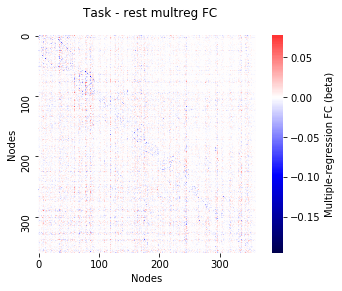

In [ ]:
#Visualize FC matrix - mean task FC vs. rest FC
FCMin=np.min(np.min(diffMat))
FCMax=np.max(np.max(diffMat))
ax = sns.heatmap(diffMat,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Task - rest multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meantaskGenFCVsRestFC_multreg_discovery176.pdf')


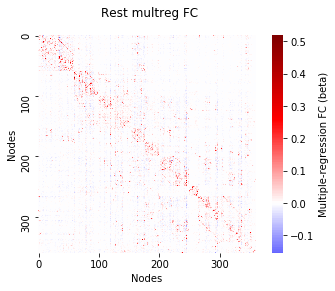

In [ ]:
#Visualize FC matrix - mean rest FC
FCMin=np.min(np.min(restFCDataMultreg))
FCMax=np.max(np.max(restFCDataMultreg))
ax = sns.heatmap(restFCDataMultreg,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Rest multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meanRestFC_multreg_discovery176.pdf')


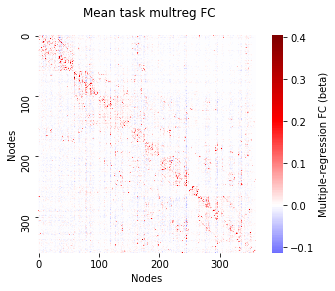

In [ ]:
#Visualize FC matrix - mean task FC
meanTaskFCMultReg=np.mean(taskgenFC_mreg_bysubj,axis=2)[netorder,:][:,netorder]
FCMin=np.min(np.min(meanTaskFCMultReg))
FCMax=np.max(np.max(meanTaskFCMultReg))
ax = sns.heatmap(meanTaskFCMultReg,square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'},vmin=FCMin,vmax=FCMax)
#ax.invert_yaxis()
ax.figure.suptitle('Mean task multreg FC')
ax.set(xlabel='Nodes',ylabel='Nodes')
fig=ax.get_figure()
fig.savefig(figuredir+'meantaskGenFC_multreg_discovery176.pdf')


# Task-state multiple regression FC LOCALLY-NON-CIRCULAR with comparison to resting-state FC actflow predictions

In [ ]:
## Calculating NON-CIRCULAR multreg TASK FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_noncirc_data'

taskFC_noncirc_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_noncirc_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        # Create batchscripts directory if it doesn't exist
        if not os.path.exists('batchscripts/'): os.makedirs('batchscripts/')
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write(
            f"import sys; sys.path.insert(0, '{basedir}/docs/scripts/final_analyses/'); sys.path.insert(0, '{basedir}/docs/scripts/final_analyses/glmScripts/vertexwise_postproc/')\n"
            f"import loadTaskResiduals_byscript; import h5py; import ActflowToolbox as actflow; import taskGLMPipeline_VertexWise as tgp\n"
            f"taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('{str(subj)}',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=True, preprocdatadir_vertexwise='{preprocdatadir_vertexwise}', datadir='{datadir}')\n"    
            f"tasktiming_bycond=tgp.loadTaskTimingForAllTasks('{str(subj)}',taskModel='canonical')['taskRegressors']>.5\n"
            f"for condnum in range(24):\n"
            f"    tasktiming=tasktiming_bycond[:,condnum]\n"
            f"    output_data=actflow.connectivity_estimation.calcconn_parcelwise_noncircular_surface(taskdata[:,tasktiming],dilated_parcels=True,verbose=False,connmethod='pc_multregconn')\n"
            f"    #Save data to file\n"
            f"    h5f = h5py.File('{file_path}','a')\n"
            f"    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n"
            f"    try:\n"
            f"        h5f.create_dataset(outname1,data=output_data)\n"
            f"    except:\n"
            f"        del h5f[outname1]\n"
            f"        h5f.create_dataset(outname1,data=output_data)\n"
            f"    h5f.close()"
            )
        file_python.close()
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write(
            f'#!/bin/bash\n'
            f'#SBATCH --partition=nm3\n'
            f'#SBATCH --job-name={str(subj)}\n'
            f'#SBATCH --requeue\n'
            f'#SBATCH --time=00:20:00\n'
            f'#SBATCH --nodes=1\n'
            f'#SBATCH --ntasks=1\n'
            f'#SBATCH --cpus-per-task=20\n'
            f'#SBATCH --mem=64000\n'
            f'#SBATCH --export=ALL\n'
            f'time python batchscripts/pythonscript_{str(subj)}.py\n'
            )
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

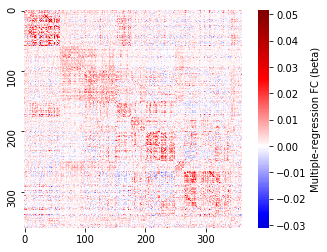

In [ ]:
ax = sns.heatmap(np.mean(taskFC_noncirc_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Multiple-regression FC (beta)'})


In [ ]:
np.corrcoef(taskFC_mreg_bycond_bysubj.flatten(),taskFC_noncirc_mreg_bycond_bysubj.flatten())

array([[1.      , 0.739939],
       [0.739939, 1.      ]])

In [ ]:

taskFCmeanMat_mreg=np.mean(np.mean(taskFC_noncirc_mreg_bycond_bysubj,axis=3),axis=2)
restFCmeanMat_mreg=np.mean(restFC_noncirc_mreg_bysubj,axis=2)
upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat_mreg)[0],k=1)
resttask_mattcorr=np.corrcoef(taskFCmeanMat_mreg[upperTIndices_corrmat], restFCmeanMat_mreg[upperTIndices_corrmat])
print('Mean noncirc task to rest FC similarity, mreg: ', str(resttask_mattcorr))


Mean noncirc task to rest FC similarity, mreg:  [[1.         0.71619801]
 [0.71619801 1.        ]]


In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC
print("==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based task-state FC, 24 task conditions==")
actflowOutput_taskFCMReg_noncirc_bycond = actflow.actflowcomp.actflowtest(activations_noncirc_bycond, taskFC_noncirc_mreg_bycond_bysubj, separate_activations_bytarget=True, full_report=True)


==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based task-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.85, t-value vs. 0: 150.68, p-value vs. 0: 3.935808851437328e-187
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.67
 
Mean MAE (mean absolute error) = 5.74
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to posi

In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC
print("==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based task-state FC, 24 task conditions==")
actflowOutput_taskFCMReg_noncirc_bycond = actflow.actflowcomp.actflowtest(activations_noncirc_bycond, taskFC_noncirc_mreg_bycond_bysubj, separate_activations_bytarget=True, full_report=True)


==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based task-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.85, t-value vs. 0: 150.68, p-value vs. 0: 3.935808851437328e-187
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.67
 
Mean MAE (mean absolute error) = 5.74
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to posi

## Match multreg resting-state FC data to task-state FC data NON-CIRCULAR (amount of data, task timing regression, timing, etc)

In [ ]:
## Calculating multreg REST FC, NON-CIRCULAR, matched timing with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFCMatchedTiming_noncirc_data'

restFCMatchedTiming_noncirc_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFCMatchedTiming_noncirc_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['restFCRegressionMatchTiming'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/vertexwise_postproc/')\n")
        
        file_python.write("import loadRestResiduals_byscript; import h5py; import ActflowToolbox as actflow; import taskGLMPipeline_VertexWise as tgp; import numpy as np\n")
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=True, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    restFCMatchedTiming_noncirc_mreg_bycond_bysubj=actflow.connectivity_estimation.calcconn_parcelwise_noncircular(restdata[:,tasktiming],dilated_parcels=True,verbose=False,connmethod='pc_multregconn')\n")
        file_python.write("    #Save multiple-regression FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegressionMatchTiming/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_noncirc_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_noncirc_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:20:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

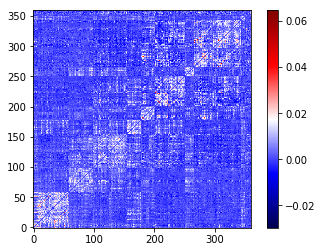

In [ ]:
plt.imshow(np.mean(restFCMatchedTiming_noncirc_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),origin='lower')
plt.colorbar()

In [ ]:
#Run actflow predictions, 24-condition rest multiple-regression FC
print("==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based resting-state FC, 24 task conditions==")
actflowOutput_restFCMReg_noncirc_bycond = actflow.actflowcomp.actflowtest(activations_noncirc_bycond, restFCMatchedTiming_noncirc_mreg_bycond_bysubj, separate_activations_bytarget=True, full_report=True)


==Activity flow mapping results, LOCALLY-NON-CIRCULAR, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.42, t-value vs. 0: 76.35, p-value vs. 0: 2.7224887723700828e-136
 
Mean % variance explained (R^2 score, coeff. of determination) = -0.37
 
Mean MAE (mean absolute error) = 12.32
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to

In [ ]:
print("===Compare NON-CIRCULAR Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTiming_noncirc_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_noncirc_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_noncirc_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_noncirc_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare NON-CIRCULAR Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.42
Model2 mean Pearson r=0.85
R-value difference = -0.42
Model1 vs. Model2 T-value: -120.37, p-value: 3.1626918778290836e-170
 
Model1 mean % predicted variance explained R^2=-0.37
Model2 mean % predicted variance explained R^2=0.67
R^2 difference = -1.04
 
Model1 mean MAE = 12.32
Model2 mean MAE = 5.74
Model1 vs. Model2 mean MAE difference = 6.58
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 a

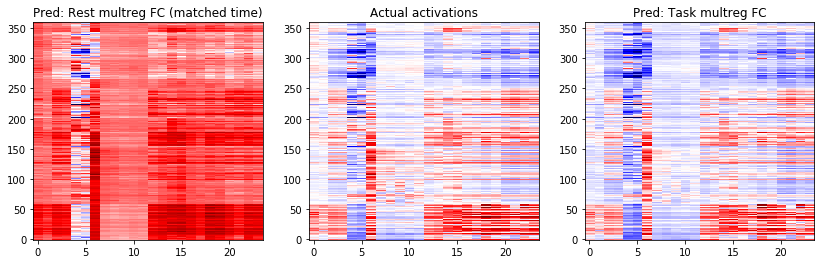

In [ ]:
#Visualize predicted and actual activations
fig = plt.figure(figsize=[14,4])
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.title.set_text('Pred: Rest multreg FC (matched time)')
ax1.imshow(np.mean(actflowOutput_restFCMReg_noncirc_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],aspect='auto',origin='lower')
ax2.title.set_text('Actual activations')
ax2.imshow(np.mean(activations_bycond,axis=2)[netorder,:],aspect='auto',origin='lower')
ax3.title.set_text('Pred: Task multreg FC')
ax3.imshow(np.mean(actflowOutput_taskFCMReg_noncirc_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],aspect='auto',origin='lower')
plt.show()



In [ ]:
#Compare task-state and resting-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset=np.arctanh(actflowOutput_taskFCMReg_noncirc_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
restdataset=np.arctanh(actflowOutput_restFCMReg_noncirc_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset,restdataset)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)

#Max and min values
print('Maximum of map: ', np.max(datamat[datamat!=0]))
print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 100.0
Maximum of map:  0.6253418153931153
Minimum of map:  0.16809816330777846


# Multreg-based task-state FC - Task-state FC tests (double cross-validation)

In [49]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved, RUN 1 ONLY

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_run1_data'

taskFC_run1_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_run1_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    taskdata_condonly=taskdata[:,tasktiming]\n")
        file_python.write("    taskdata_condonly_run1only=taskdata_condonly[:,0:int(np.sum(tasktiming)/2)]\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata_condonly_run1only)\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:20:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

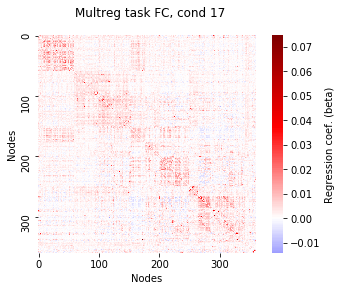

In [ ]:
# plt.imshow(np.mean(taskFC_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskFC_run1_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC, half data only
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, just run 1==")
actflowOutput_taskFCMReg_run1only_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj, full_report=True, avgthencomp_fixedeffects=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, just run 1==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.72, t-value vs. 0: 112.38, p-value vs. 0: 4.505832001999541e-165
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.49
 
Mean MAE (mean absolute error) = 8.94
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. Se

In [ ]:
#Run actflow predictions, 24-condition task multiple-regression FC, double cross-validation
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, DOUBLE CROSS-VALIDATION==")
actflowOutput_taskFCMReg_compRun2_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj, actVect_group_test=actvect_splitbyrun_group_run2s, full_report=True, avgthencomp_fixedeffects=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, DOUBLE CROSS-VALIDATION==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.40, t-value vs. 0: 57.31, p-value vs. 0: 2.501792930068209e-115
 
Mean % variance explained (R^2 score, coeff. of determination) = -0.08
 
Mean MAE (mean absolute error) = 14.47
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to 

## Resting-state FC double-cross validation (match time to task)

In [51]:
## Calculating multreg REST FC, matched timing with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFCMatchedTiming_run1only_data'

restFCMatchedTiming_mreg_run1_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFCMatchedTiming_mreg_run1_bycond_bysubj[:,:,condnum,scount] = h5f['restFCRegressionMatchTiming'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    restdata_condonly=restdata[:,tasktiming]\n")
        file_python.write("    restdata_condonly_run1only=restdata_condonly[:,0:int(np.sum(tasktiming)/2)]\n")
        file_python.write("    restFCMatchedTiming_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(restdata_condonly_run1only)\n")
        file_python.write("    #Save multiple-regression FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegressionMatchTiming/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:20:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

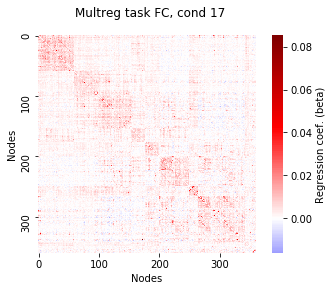

In [ ]:
# plt.imshow(np.mean(taskFC_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFCMatchedTiming_mreg_run1_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [ ]:
#Run actflow predictions, 24-condition rest multiple-regression FC, double cross-validation
print("==Activity flow mapping results, multiple-regression-based resting-state FC (matched time), 24 task conditions, DOUBLE CROSS-VALIDATION==")
actflowOutput_restFCMRegTimematched_compRun2_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, restFCMatchedTiming_mreg_run1_bycond_bysubj, actVect_group_test=actvect_splitbyrun_group_run2s, full_report=True, avgthencomp_fixedeffects=True)


==Activity flow mapping results, multiple-regression-based resting-state FC (matched time), 24 task conditions, DOUBLE CROSS-VALIDATION==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.27, t-value vs. 0: 47.74, p-value vs. 0: 2.770987895206258e-102
 
Mean % variance explained (R^2 score, coeff. of determination) = -0.19
 
Mean MAE (mean absolute error) = 15.36
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbi

In [ ]:
print("===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, DOUBLE CROSS-VALIDATION===")
model_compare_TaskMultRegFCVsRestMultRegFCMatchTimingActflow_doublecrossval = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run2s, model1_actvect=actflowOutput_restFCMRegTimematched_compRun2_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_compRun2_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare Task multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction, DOUBLE CROSS-VALIDATION===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.27
Model2 mean Pearson r=0.40
R-value difference = -0.13
Model1 vs. Model2 T-value: -37.59, p-value: 9.945865088085409e-86
 
Model1 mean % predicted variance explained R^2=-0.19
Model2 mean % predicted variance explained R^2=-0.08
R^2 difference = -0.11
 
Model1 mean MAE = 15.36
Model2 mean MAE = 14.47
Model1 vs. Model2 mean MAE difference = 0.90
 
Note: Pearson r and Pearson r^2 are scale-invariant, 

In [ ]:
#Calculate percent of regions showing effect 

#Compute p-value threshold, using maxT correction for multiple comparisons
taskdataset=np.arctanh(actflowOutput_taskFCMReg_compRun2_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
restdataset=np.arctanh(actflowOutput_restFCMRegTimematched_compRun2_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset,restdataset)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)


Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 48.333333333333336


# Group vs. individual task FC actflow predictions (inspired by Gratton2018)

Hypothesis: the task vs. rest FC boost to actflow will be much smaller using other subjects' FC relative to same-subject FC, due to large individualized task vs. rest FC effects

## Focus on FC matrix similarity (replicating Gratton2018)

In [18]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved, RUN 2 ONLY

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_run2_data'

taskFC_run2_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_run2_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
        
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    taskdata_condonly=taskdata[:,tasktiming]\n")
        file_python.write("    taskdata_condonly_run2only=taskdata_condonly[:,int(np.sum(tasktiming)/2):int(np.sum(tasktiming)+1)]\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata_condonly_run2only)\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:5:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

In [19]:
tasktiming_bycond=tgp.loadTaskTimingForAllTasks(subjNums[0],taskModel='canonical')['taskRegressors']>.5
print('Number of time points by task condition (2 runs):')
for condnum in np.arange(24):
    timepoints=np.sum(tasktiming_bycond[:,condnum])
    print(condnum, ":", timepoints, "(", timepoints/.72, "seconds)")


Number of time points by task condition (2 runs):
0 : 124 ( 172.22222222222223 seconds)
1 : 150 ( 208.33333333333334 seconds)
2 : 152 ( 211.11111111111111 seconds)
3 : 152 ( 211.11111111111111 seconds)
4 : 283 ( 393.05555555555554 seconds)
5 : 307 ( 426.3888888888889 seconds)
6 : 66 ( 91.66666666666667 seconds)
7 : 64 ( 88.88888888888889 seconds)
8 : 64 ( 88.88888888888889 seconds)
9 : 64 ( 88.88888888888889 seconds)
10 : 64 ( 88.88888888888889 seconds)
11 : 64 ( 88.88888888888889 seconds)
12 : 132 ( 183.33333333333334 seconds)
13 : 132 ( 183.33333333333334 seconds)
14 : 155 ( 215.2777777777778 seconds)
15 : 155 ( 215.2777777777778 seconds)
16 : 76 ( 105.55555555555556 seconds)
17 : 76 ( 105.55555555555556 seconds)
18 : 76 ( 105.55555555555556 seconds)
19 : 76 ( 105.55555555555556 seconds)
20 : 76 ( 105.55555555555556 seconds)
21 : 76 ( 105.55555555555556 seconds)
22 : 76 ( 105.55555555555556 seconds)
23 : 76 ( 105.55555555555556 seconds)


In [20]:
tasktiming_bycond=tgp.loadTaskTimingForAllTasks(subjNums[0],taskModel='canonical')['taskRegressors']>.5
print('Number of time points by task condition (1 run):')
for condnum in np.arange(24):
    timepoints=np.sum(tasktiming_bycond[:,condnum])
    print(condnum, ":", .5*timepoints, "(", .5*timepoints/.72, "seconds)")


Number of time points by task condition (1 run):
0 : 62.0 ( 86.11111111111111 seconds)
1 : 75.0 ( 104.16666666666667 seconds)
2 : 76.0 ( 105.55555555555556 seconds)
3 : 76.0 ( 105.55555555555556 seconds)
4 : 141.5 ( 196.52777777777777 seconds)
5 : 153.5 ( 213.19444444444446 seconds)
6 : 33.0 ( 45.833333333333336 seconds)
7 : 32.0 ( 44.44444444444444 seconds)
8 : 32.0 ( 44.44444444444444 seconds)
9 : 32.0 ( 44.44444444444444 seconds)
10 : 32.0 ( 44.44444444444444 seconds)
11 : 32.0 ( 44.44444444444444 seconds)
12 : 66.0 ( 91.66666666666667 seconds)
13 : 66.0 ( 91.66666666666667 seconds)
14 : 77.5 ( 107.6388888888889 seconds)
15 : 77.5 ( 107.6388888888889 seconds)
16 : 38.0 ( 52.77777777777778 seconds)
17 : 38.0 ( 52.77777777777778 seconds)
18 : 38.0 ( 52.77777777777778 seconds)
19 : 38.0 ( 52.77777777777778 seconds)
20 : 38.0 ( 52.77777777777778 seconds)
21 : 38.0 ( 52.77777777777778 seconds)
22 : 38.0 ( 52.77777777777778 seconds)
23 : 38.0 ( 52.77777777777778 seconds)


[Text(83.40000000000006, 0.5, 'Nodes'), Text(0.5, 15.0, 'Nodes')]

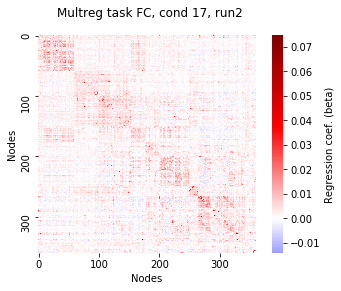

In [21]:
# plt.imshow(np.mean(taskFC_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),origin='lower')
# plt.colorbar()
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskFC_run2_mreg_bycond_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17, run2')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [48]:
taskFCmeanMat_mreg=np.mean(np.mean(taskFC_mreg_bycond_bysubj,axis=3),axis=2)
restFCmeanMat_mreg=np.mean(np.mean(restFCMatchedTiming_mreg_bycond_bysubj,axis=3),axis=2)
upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat_mreg)[0],k=1)
resttask_mattcorr=np.corrcoef(taskFCmeanMat_mreg[upperTIndices_corrmat], restFCmeanMat_mreg[upperTIndices_corrmat])
print('Mean task to rest FC similarity, mreg, AVERAGE-THEN-COMPARE: ', str(resttask_mattcorr[0,1]))


Mean task to rest FC similarity, mreg, AVERAGE-THEN-COMPARE:  0.9426993529331876


In [45]:
resttask_mattcorr_bysubj=np.zeros((nSubjs))
for subjnum in np.arange(nSubjs):
    taskFCmeanMat_mreg=np.mean(taskFC_mreg_bycond_bysubj[:,:,:,subjnum],axis=2)
    restFCmeanMat_mreg=np.mean(restFCMatchedTiming_mreg_bycond_bysubj[:,:,:,subjnum],axis=2)
    upperTIndices_corrmat=np.triu_indices(np.shape(taskFCmeanMat_mreg)[0],k=1)
    resttask_mattcorr_bysubj[subjnum]=np.corrcoef(taskFCmeanMat_mreg[upperTIndices_corrmat], restFCmeanMat_mreg[upperTIndices_corrmat])[0,1]
print('Mean task to rest FC similarity, mreg, COMPARE-THEN-AVERAGE: ', str(np.mean(resttask_mattcorr_bysubj)))


Mean task to rest FC similarity, mreg, COMPARE-THEN-AVERAGE:  0.19683023503316993


In [52]:
#Group rest [rest from other subjects], mean similarity to each condition run 1
mattcorr_grouprest_simtotaskconds_bycond_bysubj=np.zeros((nConds,nSubjs))
upperTIndices_corrmat=np.triu_indices(np.shape(taskFC_mreg_bycond_bysubj[:,:,0,0])[0],k=1)
subjorder_plus1=np.arange(1,176)
subjorder_plus1=np.append(subjorder_plus1, 0)
for subjnum in np.arange(nSubjs):
    for condnum in np.arange(nConds):
        taskFCMat_mreg=taskFC_run1_mreg_bycond_bysubj[:,:,condnum,subjnum]
        restFCMat_mreg=restFCMatchedTiming_mreg_run1_bycond_bysubj[:,:,condnum,subjorder_plus1[subjnum]]
        mattcorr_grouprest_simtotaskconds_bycond_bysubj[condnum,subjnum]=np.corrcoef(taskFCMat_mreg[upperTIndices_corrmat], restFCMat_mreg[upperTIndices_corrmat])[0,1]
print('Group rest: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE: ', str(np.mean(np.mean(mattcorr_grouprest_simtotaskconds_bycond_bysubj))))


Group rest: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE:  0.021808339105796205


In [53]:
#Group task [same task from other subjects], mean similarity to each condition run 1
mattcorr_grouptask_simtotaskconds_bycond_bysubj=np.zeros((nConds,nSubjs))
upperTIndices_corrmat=np.triu_indices(np.shape(taskFC_mreg_bycond_bysubj[:,:,0,0])[0],k=1)
subjorder_plus1=np.arange(1,176)
subjorder_plus1=np.append(subjorder_plus1, 0)
for subjnum in np.arange(nSubjs):
    for condnum in np.arange(nConds):
        taskFCMat_mreg=taskFC_run1_mreg_bycond_bysubj[:,:,condnum,subjnum]
        task2FCMat_mreg=taskFC_run1_mreg_bycond_bysubj[:,:,condnum,subjorder_plus1[subjnum]]
        mattcorr_grouptask_simtotaskconds_bycond_bysubj[condnum,subjnum]=np.corrcoef(taskFCMat_mreg[upperTIndices_corrmat], task2FCMat_mreg[upperTIndices_corrmat])[0,1]
print('Group task: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE: ', str(np.mean(np.mean(mattcorr_grouptask_simtotaskconds_bycond_bysubj))))



Group task: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE:  0.022937598588497275


In [54]:
#Individual rest [rest from same subject], mean similarity to each condition run 1
mattcorr_indivrest_simtotaskconds_bycond_bysubj=np.zeros((nConds,nSubjs))
upperTIndices_corrmat=np.triu_indices(np.shape(taskFC_mreg_bycond_bysubj[:,:,0,0])[0],k=1)
for subjnum in np.arange(nSubjs):
    for condnum in np.arange(nConds):
        taskFCMat_mreg=taskFC_run1_mreg_bycond_bysubj[:,:,condnum,subjnum]
        restFCMat_mreg=restFCMatchedTiming_mreg_run1_bycond_bysubj[:,:,condnum,subjnum]
        mattcorr_indivrest_simtotaskconds_bycond_bysubj[condnum,subjnum]=np.corrcoef(taskFCMat_mreg[upperTIndices_corrmat], restFCMat_mreg[upperTIndices_corrmat])[0,1]
print('Individual rest: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE: ', str(np.mean(np.mean(mattcorr_indivrest_simtotaskconds_bycond_bysubj))))


Individual rest: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE:  0.027606468569516485


In [55]:
#Individual task [same task (diff. run) same subject], mean similarity to each condition run 1
mattcorr_indivtask_simtotaskconds_bycond_bysubj=np.zeros((nConds,nSubjs))
upperTIndices_corrmat=np.triu_indices(np.shape(taskFC_mreg_bycond_bysubj[:,:,0,0])[0],k=1)
for subjnum in np.arange(nSubjs):
    for condnum in np.arange(nConds):
        taskFCMat_mreg=taskFC_run1_mreg_bycond_bysubj[:,:,condnum,subjnum]
        task2FCMat_mreg=taskFC_run2_mreg_bycond_bysubj[:,:,condnum,subjnum]
        mattcorr_indivtask_simtotaskconds_bycond_bysubj[condnum,subjnum]=np.corrcoef(taskFCMat_mreg[upperTIndices_corrmat], task2FCMat_mreg[upperTIndices_corrmat])[0,1]
print('Individual task: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE: ', str(np.mean(np.mean(mattcorr_indivtask_simtotaskconds_bycond_bysubj))))


Individual task: Mean similarity across task conditions, mreg, COMPARE-THEN-AVERAGE:  0.5945011983187481


## Focus on actflow group vs. individual FC effects

In [59]:
#GROUPREST
print('Group rest [rest from other subjects], predicting run 1 activations for all task conditions')
#Run actflow predictions, 24-condition REST multiple-regression FC FROM OTHER SUBJECTS, run 1 only
print("==Activity flow mapping, multiple-regression-based REST FC FROM OTHER SUBJECTS, 24 task conditions FROM RUN 1==")

#Shift subject order by 1 (so each subject uses a different subject's FC)
# subjorder_plus1=np.arange(1,176)
# subjorder_plus1=np.append(subjorder_plus1, 0)
#Randomly permute subject order, setting random seed so we always get the same order
subjorder_rand=np.arange(0,176)
np.random.seed(51)
subjorder_rand=np.random.permutation(subjorder_rand)
restFCMatchedTiming_mreg_run1_bycond_bysubj_subjordershift=restFCMatchedTiming_mreg_run1_bycond_bysubj[:,:,:,subjorder_rand].copy()
actflowOutput_restFCMReg_run1only_othersubj_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, restFCMatchedTiming_mreg_run1_bycond_bysubj_subjordershift, full_report=True)


Group rest [rest from other subjects], predicting run 1 activations for all task conditions
==Activity flow mapping, multiple-regression-based REST FC FROM OTHER SUBJECTS, 24 task conditions FROM RUN 1==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.43, t-value vs. 0: 71.10, p-value vs. 0: 4.868246623070917e-131
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.06
 
Mean MAE (mean absolute error) = 12.48
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, rang

In [60]:
#GROUPOTHERTASK
#Group task [other task from other subjects], predicting run 1 activations for all task conditions
#Run actflow predictions, 24-condition task multiple-regression FC FROM OTHER SUBJECTS, run 1 only
print("==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER TASKS & OTHER SUBJECTS, 24 task conditions FROM RUN 1==")

# taskConditions = ['xEMOTION:fear','xEMOTION:neut','xGAMBLING:win','xGAMBLING:loss','xLANGUAGE:story','xLANGUAGE:math',
#                   'MOTOR:cue','MOTOR:lf','MOTOR:rf','MOTOR:lh','MOTOR:rh','MOTOR:t','REASONING:rel',
#                   'xREASONING:match','xSOCIAL:mental','xSOCIAL:rnd','xWM 0bk:body','xWM 0bk:faces','xWM 0bk:places',
#                   'xWM 0bk:tools','xWM 2bk:body','xWM 2bk:faces','xWM 2bk:places','xWM 2bk:tools']

#Randomly permute subject order, setting random seed so we always get the same order
subjorder_rand=np.arange(0,176)
np.random.seed(51)
subjorder_rand=np.random.permutation(subjorder_rand)
taskFC_run1_mreg_bycond_bysubj_subjordershift=taskFC_run1_mreg_bycond_bysubj[:,:,:,subjorder_rand].copy()
#Shifting task condition order to make sure FC data not from the same task
taskorder_shift=np.array((22, 23, 20, 21, 18, 19, 17, 16, 15, 14, 13, 12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)).astype(int)
actflowOutput_taskFCMReg_run1only_othertask_othersubj_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj_subjordershift[:,:,taskorder_shift,:], full_report=True)


==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER TASKS & OTHER SUBJECTS, 24 task conditions FROM RUN 1==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.44, t-value vs. 0: 78.37, p-value vs. 0: 3.2161548888690556e-138
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.12
 
Mean MAE (mean absolute error) = 12.32
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitraril

In [61]:
#GROUPTASK
#Group task [same task from other subjects], predicting run 1 activations for all task conditions
#Run actflow predictions, 24-condition task multiple-regression FC FROM OTHER SUBJECTS, run 1 only
print("==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER SUBJECTS, 24 task conditions FROM RUN 1==")

#Randomly permute subject order, setting random seed so we always get the same order
subjorder_rand=np.arange(0,176)
np.random.seed(51)
subjorder_rand=np.random.permutation(subjorder_rand)
taskFC_run1_mreg_bycond_bysubj_subjordershift=taskFC_run1_mreg_bycond_bysubj[:,:,:,subjorder_rand].copy()
actflowOutput_taskFCMReg_run1only_othersubj_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj_subjordershift, full_report=True)


==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER SUBJECTS, 24 task conditions FROM RUN 1==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.51, t-value vs. 0: 73.13, p-value vs. 0: 4.063815668701142e-133
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.15
 
Mean MAE (mean absolute error) = 11.72
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to pos

In [62]:
#INDIVREST
#Individual rest [rest from same subject], predicting run 1 activations for all task conditions
#Run actflow predictions, 24-condition REST multiple-regression FC, SAME SUBJECT
print("==Activity flow mapping, multiple-regression-based REST FC, 24 task conditions FROM RUN 1, SAME SUBJECT==")
actflowOutput_taskFCMReg_run1only_FCfromRest_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, restFCMatchedTiming_mreg_run1_bycond_bysubj, full_report=True)


==Activity flow mapping, multiple-regression-based REST FC, 24 task conditions FROM RUN 1, SAME SUBJECT==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 73.46, p-value vs. 0: 1.889190123342921e-133
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.13
 
Mean MAE (mean absolute error) = 12.04
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See

In [63]:
#INDIVOTHERTASK
#Indiv other task [other task from same subject], predicting run 1 activations for all task conditions

print("==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER TASKS & SAME SUBJECTS, 24 task conditions FROM RUN 1==")

#Shifting task condition order to make sure FC data not from the same task
taskorder_shift=np.array((22, 23, 20, 21, 18, 19, 17, 16, 15, 14, 13, 12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)).astype(int)
actflowOutput_taskFCMReg_run1only_othertask_samesubj_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj[:,:,taskorder_shift,:], full_report=True)


==Activity flow mapping, multiple-regression-based task-state FC FROM OTHER TASKS & SAME SUBJECTS, 24 task conditions FROM RUN 1==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.49, t-value vs. 0: 79.74, p-value vs. 0: 1.6672432878096776e-139
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.18
 
Mean MAE (mean absolute error) = 11.80
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily

In [64]:
#INDIVTASK
#Individual task [same task (diff. run) same subject], predicting run 1 activations for all task conditions
#Run actflow predictions, 24-condition task multiple-regression FC, SAME SUBJECT, FC FROM RUN 2
print("==Activity flow mapping, multiple-regression-based task-state FC, 24 task conditions FROM RUN 1, SAME SUBJECT, FC FROM RUN 2==")

actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run2_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping, multiple-regression-based task-state FC, 24 task conditions FROM RUN 1, SAME SUBJECT, FC FROM RUN 2==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.67, t-value vs. 0: 108.80, p-value vs. 0: 1.2022522377386535e-162
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.40
 
Mean MAE (mean absolute error) = 9.75
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily lar

In [65]:
#INDIVTASKRUN
#Individual task run [same task/subject/run], predicting run 1 activations for all task conditions
#Run actflow predictions, 24-condition task multiple-regression FC, SAME SUBJECT, FC FROM SAME RUN
print("==Activity flow mapping, multiple-regression-based task-state FC, 24 task conditions FROM RUN 1, SAME SUBJECT, FC FROM SAME RUN==")

actflowOutput_taskFCMReg_run1only_FCfromrun1_bycond = actflow.actflowcomp.actflowtest(actvect_splitbyrun_group_run1s, taskFC_run1_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping, multiple-regression-based task-state FC, 24 task conditions FROM RUN 1, SAME SUBJECT, FC FROM SAME RUN==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.72, t-value vs. 0: 112.38, p-value vs. 0: 4.505832001999541e-165
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.49
 
Mean MAE (mean absolute error) = 8.94
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily l

## Quantify relative contributions to prediction accuracy (inspired by Gratton2018)

Going through interesting combinations of actflow comparisons among analysis types: GROUPREST, GROUPOTHERTASK, GROUPTASK, INDIVREST, INDIVOTHERTASK, INDIVTASK, INDIVTASKRUN

Order: GROUPREST-GROUPOTHERTASK, GROUPREST-GROUPTASK, GROUPREST-INDIVREST, (no:GROUPREST-INDIVTASK), (no:GROUPREST-INDIVTASKRUN), GROUPOTHERTASK-GROUPTASK, (no:GROUPTASK-INDIVREST), 
    GROUPTASK-INDIVTASK, (no:GROUPTASK-INDIVTASKRUN), INDIVREST-INDIVTASK, (no:INDIVREST-INDIVTASKRUN), INDIVOTHERTASK-INDIVTASK, INDIVTASK-INDIVTASKRUN
    

In [66]:
#GROUPREST-GROUPOTHERTASK
print("The effect of group other task vs. rest FC:")
print("===Compare GROUPREST vs GROUPOTHERTASK actflow prediction===")
model_compare_GROUPRESTvsGROUPOTHERTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_restFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_othertask_othersubj_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of group other task vs. rest FC:
===Compare GROUPREST vs GROUPOTHERTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.43
Model2 mean Pearson r=0.44
R-value difference = -0.01
Model1 vs. Model2 T-value: -3.60, p-value: 0.00041419722254628836
 
Model1 mean % predicted variance explained R^2=0.06
Model2 mean % predicted variance explained R^2=0.12
R^2 difference = -0.05
 
Model1 mean MAE = 12.48
Model2 mean MAE = 12.32
Model1 vs. Model2 mean MAE difference = 0.16
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not.

In [67]:
#GROUPREST-GROUPTASK
print("The effect of group task vs. rest FC:")
print("===Compare GROUPREST vs GROUPTASK actflow prediction===")
model_compare_GROUPRESTvsGROUPTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_restFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of group task vs. rest FC:
===Compare GROUPREST vs GROUPTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.43
Model2 mean Pearson r=0.51
R-value difference = -0.08
Model1 vs. Model2 T-value: -19.28, p-value: 3.827919460022508e-45
 
Model1 mean % predicted variance explained R^2=0.06
Model2 mean % predicted variance explained R^2=0.15
R^2 difference = -0.09
 
Model1 mean MAE = 12.48
Model2 mean MAE = 11.72
Model1 vs. Model2 mean MAE difference = 0.76
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units:

In [68]:
#GROUPREST-INDIVREST
print("The effect of individualized vs. group rest (intrinsic) FC:")
print("===Compare GROUPREST vs INDIVREST actflow prediction===")
model_compare_GROUPRESTvsINDIVREST = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_restFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_FCfromRest_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of individualized vs. group rest (intrinsic) FC:
===Compare GROUPREST vs INDIVREST actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.43
Model2 mean Pearson r=0.48
R-value difference = -0.05
Model1 vs. Model2 T-value: -13.48, p-value: 7.113329980522266e-29
 
Model1 mean % predicted variance explained R^2=0.06
Model2 mean % predicted variance explained R^2=0.13
R^2 difference = -0.07
 
Model1 mean MAE = 12.48
Model2 mean MAE = 12.04
Model1 vs. Model2 mean MAE difference = 0.44
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and M

In [69]:
#GROUPOTHERTASK-GROUPTASK
print("The effect of individualized task-general vs. task-specific FC:")
print("===Compare GROUPOTHERTASK vs GROUPTASK actflow prediction===")
model_compare_GROUPOTHERTASKvsGROUPTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_taskFCMReg_run1only_othertask_othersubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of individualized task-general vs. task-specific FC:
===Compare GROUPOTHERTASK vs GROUPTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.44
Model2 mean Pearson r=0.51
R-value difference = -0.07
Model1 vs. Model2 T-value: -17.42, p-value: 4.420977752056184e-40
 
Model1 mean % predicted variance explained R^2=0.12
Model2 mean % predicted variance explained R^2=0.15
R^2 difference = -0.04
 
Model1 mean MAE = 12.32
Model2 mean MAE = 11.72
Model1 vs. Model2 mean MAE difference = 0.61
 
Note: Pearson r and Pearson r^2 are scale-invariant, while 

In [70]:
#GROUPTASK-INDIVTASK
print("The effect of individualized vs. group task FC:")
print("===Compare GROUPTASK vs INDIVTASK actflow prediction===")
model_compare_GROUPTASKvsINDIVTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_taskFCMReg_run1only_othersubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of individualized vs. group task FC:
===Compare GROUPTASK vs INDIVTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.51
Model2 mean Pearson r=0.67
R-value difference = -0.16
Model1 vs. Model2 T-value: -38.67, p-value: 1.1843572399450907e-87
 
Model1 mean % predicted variance explained R^2=0.15
Model2 mean % predicted variance explained R^2=0.40
R^2 difference = -0.25
 
Model1 mean MAE = 11.72
Model2 mean MAE = 9.75
Model1 vs. Model2 mean MAE difference = 1.96
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. 

In [71]:
#INDIVREST-INDIVTASK
print("The effect of individualized task vs. rest FC:")
print("===Compare INDIVREST vs INDIVTASK actflow prediction===")
model_compare_INDIVRESTvsINDIVTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_taskFCMReg_run1only_FCfromRest_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of individualized task vs. rest FC:
===Compare INDIVREST vs INDIVTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.48
Model2 mean Pearson r=0.67
R-value difference = -0.19
Model1 vs. Model2 T-value: -64.12, p-value: 1.7604414654731994e-123
 
Model1 mean % predicted variance explained R^2=0.13
Model2 mean % predicted variance explained R^2=0.40
R^2 difference = -0.27
 
Model1 mean MAE = 12.04
Model2 mean MAE = 9.75
Model1 vs. Model2 mean MAE difference = 2.28
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. 

In [72]:
#INDIVOTHERTASK-INDIVTASK
print("The effect of individualized task-general vs. task-specific FC:")
print("===Compare INDIVOTHERTASK vs INDIVTASK actflow prediction===")
model_compare_INDIVOTHERTASKvsINDIVTASK = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_taskFCMReg_run1only_othertask_samesubj_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of individualized task-general vs. task-specific FC:
===Compare INDIVOTHERTASK vs INDIVTASK actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.49
Model2 mean Pearson r=0.67
R-value difference = -0.18
Model1 vs. Model2 T-value: -68.44, p-value: 3.02058064542215e-128
 
Model1 mean % predicted variance explained R^2=0.18
Model2 mean % predicted variance explained R^2=0.40
R^2 difference = -0.22
 
Model1 mean MAE = 11.80
Model2 mean MAE = 9.75
Model1 vs. Model2 mean MAE difference = 2.05
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R

In [73]:
#INDIVTASK-INDIVTASKRUN
print("The effect of same-run task vs. individualized task FC:")
print("===Compare INDIVTASK vs INDIVTASKRUN actflow prediction===")
model_compare_INDIVTASKvsINDIVTASKRUN = actflow.model_compare(target_actvect=actvect_splitbyrun_group_run1s, model1_actvect=actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskFCMReg_run1only_FCfromrun1_bycond['actPredVector_bytask_bysubj'], full_report=False, print_report=True, print_by_condition=False, mean_absolute_error=True)


The effect of same-run task vs. individualized task FC:
===Compare INDIVTASK vs INDIVTASKRUN actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.67
Model2 mean Pearson r=0.72
R-value difference = -0.05
Model1 vs. Model2 T-value: -30.96, p-value: 6.739360019338731e-73
 
Model1 mean % predicted variance explained R^2=0.40
Model2 mean % predicted variance explained R^2=0.49
R^2 difference = -0.09
 
Model1 mean MAE = 9.75
Model2 mean MAE = 8.94
Model1 vs. Model2 mean MAE difference = 0.82
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE 

## Visualize

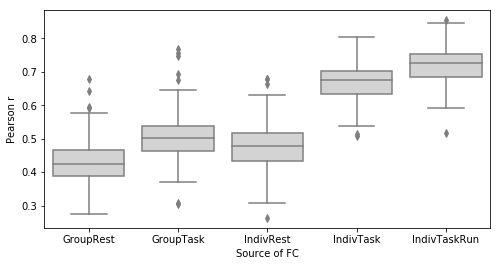

In [74]:
#Vizualize relative prediction accuracies
import pandas as pd
#GROUPREST, GROUPTASK, INDIVREST, INDIVTASK, INDIVTASKRUN
#colnames=np.array(('GroupRest','GroupTask','IndivRest','IndivTask','IndivTaskRun'))
colnames=np.array(('Pearson r','Source of FC'))
corr_array_byactflowtype=np.concatenate((actflowOutput_restFCMReg_run1only_othersubj_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_othersubj_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromRest_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromrun1_bycond['model_compare_output']['corr_fullcomp_compthenavg']))
analysistype_array=np.concatenate((np.repeat('GroupRest',nSubjs), np.repeat('GroupTask',nSubjs), np.repeat('IndivRest',nSubjs),
                                   np.repeat('IndivTask',nSubjs), np.repeat('IndivTaskRun',nSubjs)))
analysistype_series=pd.Series(analysistype_array, dtype="category")
#analysistype_array=np.concatenate((np.repeat(1,nSubjs), np.repeat(2,nSubjs), np.repeat(3,nSubjs),
#                                   np.repeat(4,nSubjs), np.repeat(5,nSubjs)))
subjnums_array=np.concatenate((np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs)))
df_actflowpreds = pd.DataFrame(np.vstack((corr_array_byactflowtype,analysistype_series)).T, index=subjnums_array, columns=colnames)
df_actflowpreds['Source of FC']=df_actflowpreds['Source of FC'].astype('category')
df_actflowpreds['Pearson r']=df_actflowpreds['Pearson r'].astype('float')
fig = plt.figure(figsize=[8,4])
ax = sns.boxplot(y='Pearson r',x='Source of FC',data=df_actflowpreds,color='lightgray')
fig.savefig(figuredir+'groupIndivCompTests_PearsonR_MultregFC_discovery176.pdf')

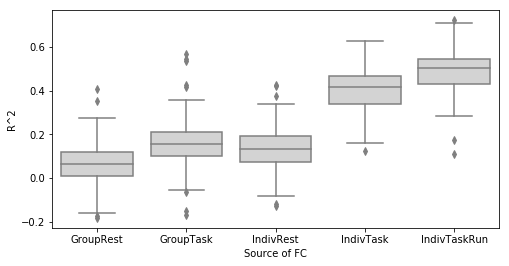

In [75]:
#Vizualize relative prediction accuracies - R^2 values
import pandas as pd
#GROUPREST, GROUPTASK, INDIVREST, INDIVTASK, INDIVTASKRUN
#colnames=np.array(('GroupRest','GroupTask','IndivRest','IndivTask','IndivTaskRun'))
colnames=np.array(('R^2','Source of FC'))
r2_array_byactflowtype=np.concatenate((actflowOutput_restFCMReg_run1only_othersubj_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_othersubj_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromRest_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromrun2_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskFCMReg_run1only_FCfromrun1_bycond['model_compare_output']['R2_fullcomp_compthenavg']))
analysistype_array=np.concatenate((np.repeat('GroupRest',nSubjs), np.repeat('GroupTask',nSubjs), np.repeat('IndivRest',nSubjs),
                                   np.repeat('IndivTask',nSubjs), np.repeat('IndivTaskRun',nSubjs)))
analysistype_series=pd.Series(analysistype_array, dtype="category")
subjnums_array=np.concatenate((np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs)))
df_actflowpreds_R2 = pd.DataFrame(np.vstack((r2_array_byactflowtype,analysistype_series)).T, index=subjnums_array, columns=colnames)
df_actflowpreds_R2['Source of FC']=df_actflowpreds_R2['Source of FC'].astype('category')
df_actflowpreds_R2['R^2']=df_actflowpreds_R2['R^2'].astype('float')
fig = plt.figure(figsize=[8,4])
ax = sns.boxplot(y='R^2',x='Source of FC',data=df_actflowpreds_R2,color='lightgray')
fig.savefig(figuredir+'groupIndivCompTests_R2_MultregFC_discovery176.pdf')

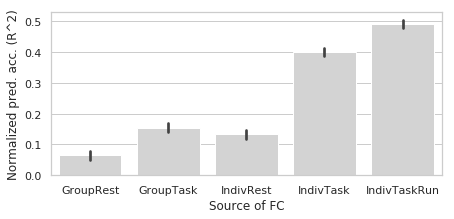

In [76]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=[7,3])
ax = sns.barplot(y='R^2',x='Source of FC',data=df_actflowpreds_R2,color='lightgray',ci=95)
ax.set(ylabel='Normalized pred. acc. (R^2)')
fig.savefig(figuredir+'groupIndivCompTests_R2_barplots_MultregFC_discovery176.pdf')

<Figure size 504x216 with 0 Axes>

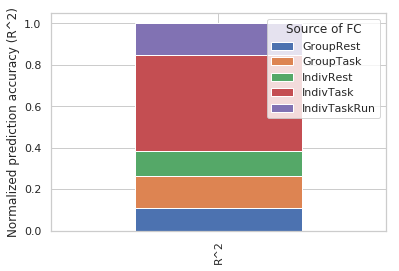

In [77]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=[7,3])
meanvals=df_actflowpreds_R2.groupby('Source of FC').mean()
#subtract intrinsic FC
baselines=np.array((0,meanvals['R^2'][0],meanvals['R^2'][0],meanvals['R^2'][2],meanvals['R^2'][3]))
meanvals=meanvals.sub(baselines,axis='rows')
meanvals_normalized=meanvals/meanvals.sum()
ax=meanvals_normalized.T.plot(kind='bar', stacked=True)
ax.set(ylabel='Normalized prediction accuracy (R^2)')
fig = ax.get_figure()
fig.savefig(figuredir+'groupIndivCompTests_R2_stackedbarplots_MultregFC_discovery176.pdf')

## Check possibility that original analyses were overfit (explaining why R^2 is better with half the data)

In [78]:
## Calculating multreg REST FC, matched timing with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFCMatchedTiming_halfncomp_data'

restFCMatchedTiming_halfncomp_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFCMatchedTiming_halfncomp_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['restFCRegressionMatchTiming'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        file_python.write("    restFCMatchedTiming_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(restdata[:,tasktiming], n_components=int(np.round(np.sum(tasktiming)/2)))\n")
        file_python.write("    #Save multiple-regression FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegressionMatchTiming/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFCMatchedTiming_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:20:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

In [79]:
#Run actflow predictions, 24-condition rest multiple-regression FC, timing matched to task
print("==Activity flow mapping results, multiple-regression-based resting-state FC, TASK TIMING MATCHED, 24 task conditions, halfncomp==")
actflowOutput_restFCMRegMatchedTiming_halfncomp_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFCMatchedTiming_halfncomp_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, TASK TIMING MATCHED, 24 task conditions, halfncomp==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.63, t-value vs. 0: 112.47, p-value vs. 0: 3.9088519001439045e-165
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.38
 
Mean MAE (mean absolute error) = 9.43
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily 

In [80]:
## Calculating multreg FC with SLURM cluster command (in parallel), loading from data if saved

#Note: issue with subject 559457; SVD didn't converge; copying from original analysis (conservative test of hypothesis)

loaddata_ifavailable=True
datasuffix='_PCmultregTaskFC_halfncomp_data'

taskFC_halfncomp_mreg_bycond_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
#snums_touse=np.concatenate((np.arange(0,161), np.arange(162,176)))
for subj in subjNums:
    #print('Subject ' + subj +'('+str(scount)+')')
    file_path=resultsdir + subj + datasuffix + '.h5'
    #print(file_path)
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskFC_halfncomp_mreg_bycond_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")  
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    tasktiming=tasktiming_bycond[:,condnum]\n")
        #file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming], n_components=0.9, svd_solver='full')\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(taskdata[:,tasktiming], n_components=int(np.round(np.sum(tasktiming)/2)))\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=main\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:15:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

In [81]:
#Run actflow predictions, 24-condition rest multiple-regression FC, timing matched to task
print("==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, halfncomp==")
actflowOutput_taskfc_halfncomp_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskFC_halfncomp_mreg_bycond_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions, halfncomp==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.78, t-value vs. 0: 154.89, p-value vs. 0: 3.2851477398194505e-189
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.60
 
Mean MAE (mean absolute error) = 7.24
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. Se

# Multreg-based task-state FC - Task-general FC tests

In [82]:
## Calculating multreg task-general FC with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregTaskGenFC_data'

taskgenFC_mreg_bysubj=np.zeros((nParcels,nParcels,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        taskgenFC_mreg_bysubj[:,:,scount] = h5f['taskgenFCRegression'][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
 
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("tasktiming_all=np.array(np.sum(tasktiming_bycond,axis=1)>0)\n")
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("taskgenFC_mreg_bysubj=actflow.connectivity_estimation.multregconn(taskdata[:,tasktiming_all])\n")
        file_python.write("#Save multiple-regression task FC data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'taskgenFCRegression'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=taskgenFC_mreg_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=taskgenFC_mreg_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:05:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

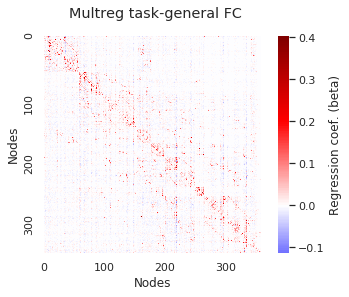

In [83]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskgenFC_mreg_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task-general FC')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [84]:
#Run actflow predictions, 24-condition task-general multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general FC, 24 task conditions==")
actflowOutput_taskGeneralFCMReg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-general FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.91, t-value vs. 0: 163.67, p-value vs. 0: 2.2745658702165087e-193
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.83
 
Mean MAE (mean absolute error) = 4.63
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https:/

In [85]:

print("===Compare task-general multregFC actflow predictions to task-state multregFC actflow prediction===")
model_compare_TaskGenMultRegFCVsTaskSTateMultRegFC_Actflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskGeneralFCMReg_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare task-general multregFC actflow predictions to task-state multregFC actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.76
Model2 mean Pearson r=0.91
R-value difference = -0.15
Model1 vs. Model2 T-value: -94.55, p-value: 3.737948813842191e-152
 
Model1 mean % predicted variance explained R^2=0.51
Model2 mean % predicted variance explained R^2=0.83
R^2 difference = -0.32
 
Model1 mean MAE = 7.47
Model2 mean MAE = 4.63
Model1 vs. Model2 mean MAE difference = 2.84
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 u

In [86]:
#Compare task-general and task-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset1=np.arctanh(actflowOutput_taskGeneralFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
taskdataset2=np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset1,taskdataset2)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata))
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)

tvals=np.array([tstats[nodenum][0] for nodenum in np.arange(nParcels)])
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nParcels
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nParcels
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

#Visualize data
# datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
# #Apply threshold
# datamat=np.multiply(datamat,maxt_sigvector)
# datamat=datamat[:,np.newaxis]
# outfilename='../figures/figure_parts/taskgeneralVStaskstateActflowPred_condwise_MultregFC_discovery176'
# #sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
# actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=True)

# #Max and min values
# print('Maximum of map: ', np.max(datamat[datamat!=0]))
# print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 98.33333333333333
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 98.33333333333333
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 0.0


## Resting-state FC time-matched to task-general FC

In [87]:
## Calculating multreg REST FC, matched timing with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_PCmultregRestFC_matchedTaskGen_data'

restFC_mreg_matchedTaskGen_bysubj=np.zeros((nParcels,nParcels,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        restFC_mreg_matchedTaskGen_bysubj[:,:,scount] = h5f['restFCRegressionMatchTiming'][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("tasktiming_dur=3810\n")
        file_python.write("restFC_mreg_matchedTaskGen_bycond_bysubj=actflow.connectivity_estimation.pc_multregconn(restdata[:,0:tasktiming_dur])\n")
        file_python.write("#Save multiple-regression FC data to file\n")
        file_python.write("h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("outname1 = 'restFCRegressionMatchTiming'\n")
        file_python.write("try:\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_mreg_matchedTaskGen_bycond_bysubj)\n")
        file_python.write("except:\n")
        file_python.write("    del h5f[outname1]\n")
        file_python.write("    h5f.create_dataset(outname1,data=restFC_mreg_matchedTaskGen_bycond_bysubj)\n")
        file_python.write("h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:05:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

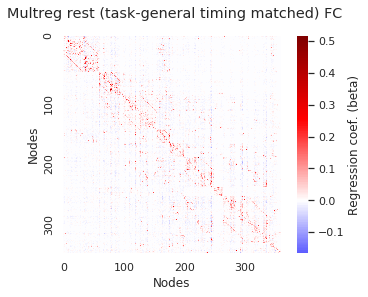

In [88]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_mreg_matchedTaskGen_bysubj[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest (task-general timing matched) FC')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [89]:
#Run actflow predictions, 24-condition multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state (task-general timing matched) FC, 24 task conditions==")
actflowOutput_restFCMReg_taskGeneralMatched_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_matchedTaskGen_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state (task-general timing matched) FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.88, t-value vs. 0: 162.89, p-value vs. 0: 5.194311585996199e-193
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.77
 
Mean MAE (mean absolute error) = 5.53
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily lar

In [90]:
print("===Compare task-general multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===")
model_compare_TaskGenMultRegFCVsRestMultRegFCMatchTiming_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_taskGeneralMatched_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_taskGeneralMatched_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskGeneralFCMReg_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare task-general multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.88
Model2 mean Pearson r=0.91
R-value difference = -0.03
Model1 vs. Model2 T-value: -44.57, p-value: 1.9031951409810695e-97
 
Model1 mean % predicted variance explained R^2=0.77
Model2 mean % predicted variance explained R^2=0.83
R^2 difference = -0.06
 
Model1 mean MAE = 5.53
Model2 mean MAE = 4.63
Model1 vs. Model2 mean MAE difference = 0.90
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE ar

In [91]:
import gc
gc.collect()

13634

In [92]:
#Compare task-general and resting-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset1=np.arctanh(actflowOutput_taskGeneralFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
taskdataset2=np.arctanh(actflowOutput_restFCMReg_taskGeneralMatched_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset1,taskdataset2)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata),nproc=numWorkers)
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)

tvals=np.array([tstats[nodenum][0] for nodenum in np.arange(nParcels)])
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nParcels
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nParcels
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

#Visualize data
# datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
# #Apply threshold
# datamat=np.multiply(datamat,maxt_sigvector)
# datamat=datamat[:,np.newaxis]
# outfilename='../figures/figure_parts/taskgeneralVStaskstateActflowPred_condwise_MultregFC_discovery176'
# #sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
# actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=True)

# #Max and min values
# print('Maximum of map: ', np.max(datamat[datamat!=0]))
# print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 77.77777777777777
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 77.77777777777777
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 0.0


## Multreg task-general FC, current task held out

In [93]:
## Calculating multreg task-general FC, CURRENT TASK HELD OUT, with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregTaskGenFC_notcurrenttask_data'

taskgenFC_mreg_bycondheldout_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            taskgenFC_mreg_bycondheldout_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
 
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    conds_other=np.delete(np.arange(24),condnum)\n")
        file_python.write("    tasktiming=np.array(np.sum(tasktiming_bycond[:,conds_other],axis=1)>0)\n")
        file_python.write("    taskFC_mreg_bycond_bysubj=actflow.connectivity_estimation.multregconn(taskdata[:,tasktiming])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bycond_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:10:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

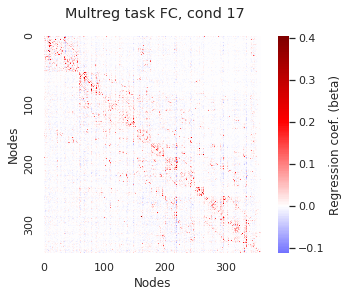

In [94]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskgenFC_mreg_bycondheldout_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg task FC, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')


In [95]:
#Run actflow predictions, 24-condition task-general cond-held-out multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general cond-held-out FC, 24 task conditions==")
actflowOutput_taskGeneralFCMReg_condheldout_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bycondheldout_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based task-general cond-held-out FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.90, t-value vs. 0: 154.21, p-value vs. 0: 7.101024141122594e-189
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.80
 
Mean MAE (mean absolute error) = 5.04
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1

In [96]:

print("===Compare task-general condheldout multregFC actflow predictions to task-state multregFC actflow prediction===")
model_compare_TaskGenMultRegFCVsTaskSTateMultRegFC_condheldout_Actflow = actflow.model_compare(target_actvect=actflowOutput_taskFCMReg_bycond['actVect_actual_group'], model1_actvect=actflowOutput_taskFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskGeneralFCMReg_condheldout_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare task-general condheldout multregFC actflow predictions to task-state multregFC actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.76
Model2 mean Pearson r=0.90
R-value difference = -0.13
Model1 vs. Model2 T-value: -75.62, p-value: 1.3844578782838288e-135
 
Model1 mean % predicted variance explained R^2=0.51
Model2 mean % predicted variance explained R^2=0.80
R^2 difference = -0.28
 
Model1 mean MAE = 7.47
Model2 mean MAE = 5.04
Model1 vs. Model2 mean MAE difference = 2.43
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE a

In [97]:
#Compare task-general and task-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset1=np.arctanh(actflowOutput_taskGeneralFCMReg_condheldout_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
taskdataset2=np.arctanh(actflowOutput_taskFCMReg_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset1,taskdataset2)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata),nproc=numWorkers)
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)

tvals=np.array([tstats[nodenum][0] for nodenum in np.arange(nParcels)])
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nParcels
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nParcels
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

#Visualize data
# datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
# #Apply threshold
# datamat=np.multiply(datamat,maxt_sigvector)
# datamat=datamat[:,np.newaxis]
# outfilename='../figures/figure_parts/taskgeneralVStaskstateActflowPred_condwise_MultregFC_discovery176'
# #sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
# actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=True)

# #Max and min values
# print('Maximum of map: ', np.max(datamat[datamat!=0]))
# print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 96.11111111111111
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 96.11111111111111
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 0.0


## Resting-state FC time-matched to cond-held-out task-general FC

In [98]:
## Calculating multreg resting-state FC time-matched to task-general FC, CURRENT TASK HELD OUT, with SLURM cluster command (in parallel), loading from data if saved

loaddata_ifavailable=True
datasuffix='_multregRestFC_timeMatchedTaskGenFC_notcurrenttask_data'

restFC_mreg_timematchedtaskgen_bycondheldout_bysubj=np.zeros((nParcels,nParcels,nConds,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for condnum in range(24):
            dataid = 'condition' + str(condnum)
            restFC_mreg_timematchedtaskgen_bycondheldout_bysubj[:,:,condnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
    
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        #file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("for condnum in range(24):\n")
        file_python.write("    conds_other=np.delete(np.arange(24),condnum)\n")
        file_python.write("    tasktiming=np.array(np.sum(tasktiming_bycond[:,conds_other],axis=1)>0)\n")
        file_python.write("    restFC_mreg_timematchedtaskgen_bycondheldout_bysubj=actflow.connectivity_estimation.multregconn(restdata[:,tasktiming])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(condnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_timematchedtaskgen_bycondheldout_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_timematchedtaskgen_bycondheldout_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:10:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

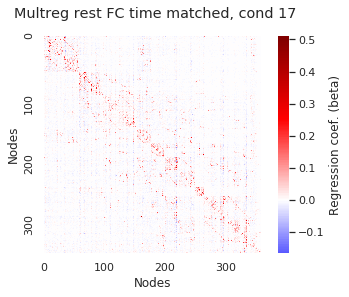

In [99]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_mreg_timematchedtaskgen_bycondheldout_bysubj[netorder,:,16,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC time matched, cond 17')
ax.set(xlabel='Nodes',ylabel='Nodes')


In [100]:
#Run actflow predictions, 24-condition resting-state FC, time matched to task-general cond-held-out multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC, time matched to task-general cond-held-out FC, 24 task conditions==")
actflowOutput_restFCMReg_timematchedtaskGeneral_condheldout_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_timematchedtaskgen_bycondheldout_bysubj, full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, time matched to task-general cond-held-out FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.87, t-value vs. 0: 157.99, p-value vs. 0: 1.0488473264000528e-190
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.75
 
Mean MAE (mean absolute error) = 5.81
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can 

In [101]:
print("===Compare task-general (condheldout) multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===")
model_compare_TaskGenMultRegFCVsRestMultRegFCMatchTiming_condheldout_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCMReg_timematchedtaskGeneral_condheldout_bycond['actVect_actual_group'], model1_actvect=actflowOutput_restFCMReg_timematchedtaskGeneral_condheldout_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_taskGeneralFCMReg_condheldout_bycond['actPredVector_bytask_bysubj'], full_report=True, print_report=True, print_by_condition=True, mean_absolute_error=True)


===Compare task-general (condheldout) multregFC actflow predictions to Rest multregFC (matching timing) actflow prediction===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.87
Model2 mean Pearson r=0.90
R-value difference = -0.03
Model1 vs. Model2 T-value: -32.59, p-value: 3.066329274453115e-76
 
Model1 mean % predicted variance explained R^2=0.75
Model2 mean % predicted variance explained R^2=0.80
R^2 difference = -0.05
 
Model1 mean MAE = 5.81
Model2 mean MAE = 5.04
Model1 vs. Model2 mean MAE difference = 0.77
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R

In [102]:
#Compare task-general and resting-state predictions

#taskcorrFC vs. restcorrFC
#Compute p-value threshold, using FDR correction for multiple comparisons
taskdataset1=np.arctanh(actflowOutput_taskGeneralFCMReg_condheldout_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
taskdataset2=np.arctanh(actflowOutput_restFCMReg_timematchedtaskGeneral_condheldout_bycond['model_compare_output']['corr_conditionwise_compthenavg_bynode'])
ttestinputdata=np.subtract(taskdataset1,taskdataset2)
tstats = [stats.ttest_1samp(ttestinputdata[nodenum],0.0) for nodenum in np.arange(nParcels)]
pvals=[tstats[nodenum][1] for nodenum in np.arange(nParcels)]
pvals_FDRcorrected=sm.stats.multipletests(pvals,method='fdr_bh')[1]
#Compute p-value threshold, using maxT (permutation test) correction for multiple comparisons
maxt_output=actflow.tools.max_t(np.array(ttestinputdata),nproc=numWorkers)
maxt_sigvector=maxt_output[2]<0.05
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05):', 100*np.sum(maxt_sigvector)/nParcels)

tvals=np.array([tstats[nodenum][0] for nodenum in np.arange(nParcels)])
percentpos=100*np.sum(maxt_sigvector*(tvals>0))/nParcels
percentneg=100*np.sum(maxt_sigvector*(tvals<0))/nParcels
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE:', percentpos)
print('Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE:', percentneg)

#Visualize data
# datamat=np.tanh(np.mean(np.subtract(taskdataset,restdataset),axis=1))
# #Apply threshold
# datamat=np.multiply(datamat,maxt_sigvector)
# datamat=datamat[:,np.newaxis]
# outfilename='../figures/figure_parts/taskgeneralVStaskstateActflowPred_condwise_MultregFC_discovery176'
# #sys.path.insert(0,'/projects/community/connectome_wb/1.3.2/kholodvl/workbench/bin_rh_linux64/')
# actflow.tools.map_to_surface(datamat,outfilename,fliphemispheres=True)

# #Max and min values
# print('Maximum of map: ', np.max(datamat[datamat!=0]))
# print('Minimum of map: ', np.min(datamat[datamat!=0]))

Percent significant nodes (maxT corrected for multiple comparisons, p<0.05): 40.55555555555556
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) POSITIVE: 40.55555555555556
Percent significant nodes (maxT corrected for multiple comparisons, p<0.05) NEGATIVE: 0.0


## Actflow prediction using other tasks individually

In [103]:
#ITERATE THROUGH ALTERNATIVE TASKS FOR FC: Run actflow predictions, 24-condition task multiple-regression FC
print("==ITERATE THROUGH ALTERNATIVE TASKS FOR FC: Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==")
#actflowOutput_taskFCMReg_bycond_test = actflow.actflowcomp.actflowtest(activations_bycond[:,0,:], taskFC_mreg_bycond_bysubj[:,:,1,:], print_by_condition=False, full_report=False)

#Calculate actflow predictions
predaccs_byFCcond_byactcond_bysubj=np.zeros((nConds, nConds, nSubjs))
scount = 0
for subj in subjNums:
    for FC_cond in np.arange(nConds):
        for act_cond in np.arange(nConds):
                
            actPredVector=actflow.actflowcalc(activations_bycond[:,act_cond,scount], taskFC_mreg_bycond_bysubj[:,:,FC_cond,scount])
            predaccs_byFCcond_byactcond_bysubj[FC_cond,act_cond,scount]=np.corrcoef(actPredVector,activations_bycond[:,act_cond,scount])[0,1]
            
    scount=scount+1

#Assess statistical signficance of actflow predictions
tstats_predaccs_byFCcond_byactcond=np.zeros((nConds, nConds))
pvals_predaccs_byFCcond_byactcond=np.ones((nConds, nConds))
for FC_cond in np.arange(nConds):
    for act_cond in np.arange(nConds):
            
            tstats = stats.ttest_1samp(np.arctanh(predaccs_byFCcond_byactcond_bysubj[FC_cond,act_cond,:]),0.0)
            tstats_predaccs_byFCcond_byactcond[FC_cond,act_cond]=tstats[0]
            pvals_predaccs_byFCcond_byactcond[FC_cond,act_cond]=tstats[1]


            


==ITERATE THROUGH ALTERNATIVE TASKS FOR FC: Activity flow mapping results, multiple-regression-based task-state FC, 24 task conditions==


bonferroni_thresh (p<0.05 corrected): p< 8.680555555555556e-05


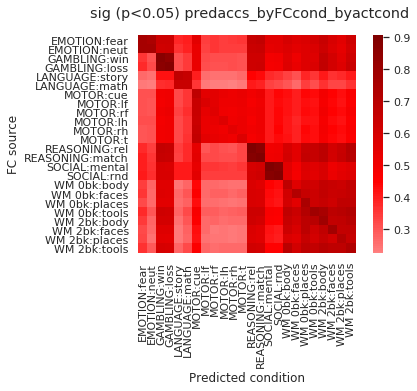

In [104]:
ncomparisons=nConds*nConds
bonferroni_thresh=.05/ncomparisons
threshed_data=np.mean(predaccs_byFCcond_byactcond_bysubj,axis=2)*(pvals_predaccs_byFCcond_byactcond<bonferroni_thresh)
ax = sns.heatmap(threshed_data,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('sig (p<0.05) predaccs_byFCcond_byactcond')
ax.set(ylabel='FC source',xlabel='Predicted condition')
print('bonferroni_thresh (p<0.05 corrected): p<', bonferroni_thresh)

In [105]:
print('Task-state FC state generalization matrix analysis')
#upperTIndices_24by24=np.triu(np.ones((24,24)),k=1)>0
#Remove diagonal
blankmat=np.ones((nConds,nConds))
upperTmat=np.triu(blankmat,k=1)
lowerTmat=np.tril(blankmat,k=-1)
offdiagmat_conds=(upperTmat+lowerTmat)>0
mean_predact_crossconditions=np.tanh(np.mean(np.mean(np.mean(np.arctanh(predaccs_byFCcond_byactcond_bysubj),axis=2)[offdiagmat_conds])))
print('mean_predact_crossconditions: r=', mean_predact_crossconditions)

mean_predact_bysubj=np.mean(np.mean(np.arctanh(predaccs_byFCcond_byactcond_bysubj),axis=0),axis=1)
tstats = stats.ttest_1samp(mean_predact_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value vs. 0:', tstat)
print('p-value vs. 0:', pval)

Task-state FC state generalization matrix analysis
mean_predact_crossconditions: r= 0.48848133775920544
t-value vs. 0: 19.183063229746963
p-value vs. 0: 1.19786654210894e-15


In [106]:
#ITERATE THROUGH ALTERNATIVE TASK-EQUIVALENT TIME FROM REST FOR FC: Run actflow predictions, 24-condition rest multiple-regression FC
print("==ITERATE THROUGH TASK-EQUIVALENT TIME FROM REST FOR FC: Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==")

#Calculate actflow predictions
predaccsRestFC_byFCcond_byactcond_bysubj=np.zeros((nConds, nConds, nSubjs))
scount = 0
for subj in subjNums:
    for FC_cond in np.arange(nConds):
        for act_cond in np.arange(nConds):
                
            actPredVector=actflow.actflowcalc(activations_bycond[:,act_cond,scount], restFCMatchedTiming_mreg_bycond_bysubj[:,:,FC_cond,scount])
            predaccsRestFC_byFCcond_byactcond_bysubj[FC_cond,act_cond,scount]=np.corrcoef(actPredVector,activations_bycond[:,act_cond,scount])[0,1]
            
    scount=scount+1

#Assess statistical signficance of actflow predictions
tstats_predaccsRestFC_byFCcond_byactcond=np.zeros((nConds, nConds))
pvals_predaccsRestFC_byFCcond_byactcond=np.ones((nConds, nConds))
for FC_cond in np.arange(nConds):
    for act_cond in np.arange(nConds):
            
            tstats = stats.ttest_1samp(np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj[FC_cond,act_cond,:]),0.0)
            tstats_predaccsRestFC_byFCcond_byactcond[FC_cond,act_cond]=tstats[0]
            pvals_predaccsRestFC_byFCcond_byactcond[FC_cond,act_cond]=tstats[1]


            


==ITERATE THROUGH TASK-EQUIVALENT TIME FROM REST FOR FC: Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==


In [107]:
print('Resting-state FC state generalization matrix analysis:')
#upperTIndices_24by24=np.triu(np.ones((24,24)),k=1)>0
#Remove diagonal
blankmat=np.ones((nConds,nConds))
upperTmat=np.triu(blankmat,k=1)
lowerTmat=np.tril(blankmat,k=-1)
offdiagmat_conds=(upperTmat+lowerTmat)>0
mean_predactrest_crossconditions=np.tanh(np.mean(np.mean(np.mean(np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj),axis=2)[offdiagmat_conds])))
print('mean_predactrest_crossconditions: r=', mean_predactrest_crossconditions)

mean_predact_bysubj=np.mean(np.mean(np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj),axis=0),axis=1)
tstats = stats.ttest_1samp(mean_predact_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value vs. 0:', tstat)
print('p-value vs. 0:', pval)

print('Task-state FC vs. Resting-state FC state generalization matrix analysis:')
mean_predacttaskVSrest_crossconditions=np.tanh(np.mean(np.mean(np.mean(np.arctanh(predaccs_byFCcond_byactcond_bysubj)-np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj),axis=2)[offdiagmat_conds])))
print('mean_predacttaskVSrest_crossconditions: r=', mean_predacttaskVSrest_crossconditions)

mean_predact_bysubj=np.mean(np.mean(np.arctanh(predaccs_byFCcond_byactcond_bysubj)-np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj),axis=0),axis=1)
tstats = stats.ttest_1samp(mean_predact_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value paired:', tstat)
print('p-value paired:', pval)

Resting-state FC state generalization matrix analysis:
mean_predactrest_crossconditions: r= 0.45401824399178853
t-value vs. 0: 30.07000789427279
p-value vs. 0: 5.737430018678397e-20
Task-state FC vs. Resting-state FC state generalization matrix analysis:
mean_predacttaskVSrest_crossconditions: r= 0.0442844811651388
t-value paired: 4.095619108075989
p-value paired: 0.00044354105308819247


In [108]:
#Assess statistical signficance of actflow predictions, TASK FC PREDICTIONS VS REST FC PREDICTIONS
tstats_predaccsTaskVSRestFC_byFCcond_byactcond=np.zeros((nConds, nConds))
pvals_predaccsTaskVSRestFC_byFCcond_byactcond=np.ones((nConds, nConds))
for FC_cond in np.arange(nConds):
    for act_cond in np.arange(nConds):
            #Paired t-tests
            predacc_diffs=np.arctanh(predaccs_byFCcond_byactcond_bysubj[FC_cond,act_cond,:])-np.arctanh(predaccsRestFC_byFCcond_byactcond_bysubj[FC_cond,act_cond,:])
            tstats = stats.ttest_1samp(predacc_diffs,0.0)
            tstats_predaccsTaskVSRestFC_byFCcond_byactcond[FC_cond,act_cond]=tstats[0]
            pvals_predaccsTaskVSRestFC_byFCcond_byactcond[FC_cond,act_cond]=tstats[1]

bonferroni_thresh (p<0.05 corrected): p< 8.680555555555556e-05


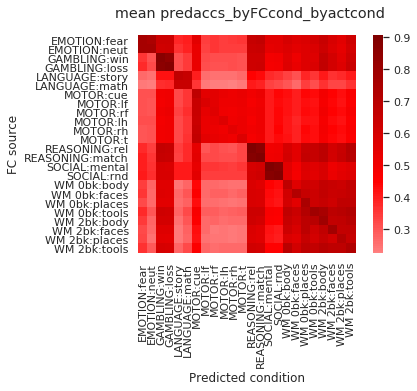

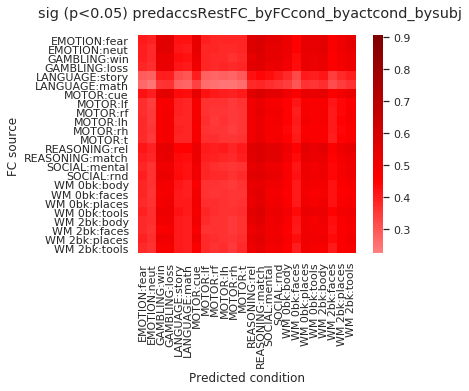

In [109]:
#Visualize matrices
predaccs_byFCcond_byactcond_mean=np.mean(predaccs_byFCcond_byactcond_bysubj,axis=2)
predaccsRestFC_byFCcond_byactcond_mean=np.mean(predaccsRestFC_byFCcond_byactcond_bysubj,axis=2)
datamin=np.min(np.array(np.min(np.min(predaccs_byFCcond_byactcond_mean)), np.min(np.min(predaccsRestFC_byFCcond_byactcond_mean))))
datamax=np.max(np.array(np.max(np.max(predaccs_byFCcond_byactcond_mean)), np.max(np.max(predaccsRestFC_byFCcond_byactcond_mean))))

ax = sns.heatmap(predaccs_byFCcond_byactcond_mean,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True, vmin=datamin,vmax=datamax)
ax.figure.suptitle('mean predaccs_byFCcond_byactcond')
ax.set(ylabel='FC source',xlabel='Predicted condition')
fig=ax.get_figure()
fig.savefig(figuredir+'predaccs_byFCcond_byactcond_discovery176.pdf')

#Resting-state FC predictions
ncomparisons=nConds*nConds
bonferroni_thresh=.05/ncomparisons
threshed_data=predaccsRestFC_byFCcond_byactcond_mean*(pvals_predaccsRestFC_byFCcond_byactcond<bonferroni_thresh)
plt.figure()
ax = sns.heatmap(threshed_data,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True, vmin=datamin,vmax=datamax)
ax.figure.suptitle('sig (p<0.05) predaccsRestFC_byFCcond_byactcond_bysubj')
ax.set(ylabel='FC source ',xlabel='Predicted condition')
print('bonferroni_thresh (p<0.05 corrected): p<', bonferroni_thresh)
fig=ax.get_figure()
fig.savefig(figuredir+'predaccsRestFC_byFCcond_byactcond_discovery176.pdf')

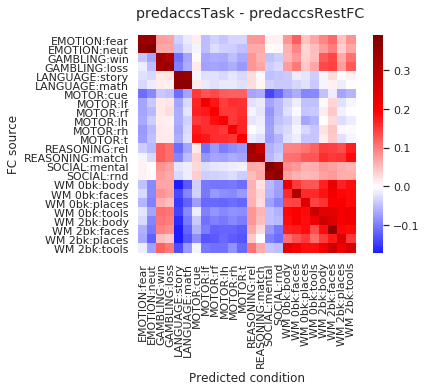

In [110]:
#Task FC - rest FC predictions no thresh
#ncomparisons=nConds*nConds
#bonferroni_thresh=.05/ncomparisons
#threshed_data=np.mean(predaccs_byFCcond_byactcond_bysubj-predaccsRestFC_byFCcond_byactcond_bysubj,axis=2)*(pvals_predaccsTaskVSRestFC_byFCcond_byactcond<bonferroni_thresh)
ax = sns.heatmap(np.mean(predaccs_byFCcond_byactcond_bysubj-predaccsRestFC_byFCcond_byactcond_bysubj,axis=2),center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('predaccsTask - predaccsRestFC')
ax.set(ylabel='FC source',xlabel='Predicted condition')
#print('bonferroni_thresh (p<0.05 corrected): p<', bonferroni_thresh)
fig=ax.get_figure()
fig.savefig(figuredir+'predaccs_byFCcond_byactcond_unthreshed_discovery176.pdf')

bonferroni_thresh (p<0.05 corrected): p< 8.680555555555556e-05


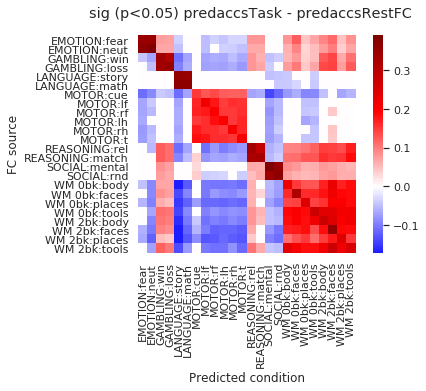

In [111]:
#Task FC - rest FC predictions
ncomparisons=nConds*nConds
bonferroni_thresh=.05/ncomparisons
threshed_data=np.mean(predaccs_byFCcond_byactcond_bysubj-predaccsRestFC_byFCcond_byactcond_bysubj,axis=2)*(pvals_predaccsTaskVSRestFC_byFCcond_byactcond<bonferroni_thresh)
ax = sns.heatmap(threshed_data,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('sig (p<0.05) predaccsTask - predaccsRestFC')
ax.set(ylabel='FC source',xlabel='Predicted condition')
print('bonferroni_thresh (p<0.05 corrected): p<', bonferroni_thresh)
fig=ax.get_figure()
fig.savefig(figuredir+'predaccs_byFCcond_byactcond_threshbonp05_discovery176.pdf')

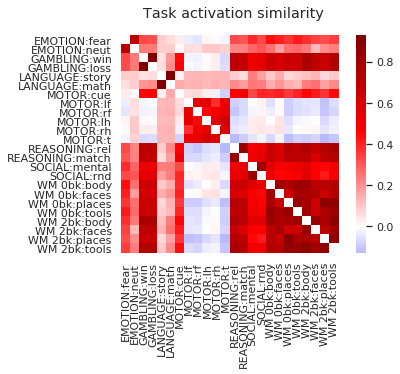

In [112]:
actsim_bycond_bysubj=np.zeros((nConds, nConds, nSubjs))
scount = 0
for subj in subjNums:
    actsim_bycond_bysubj[:,:,scount]=np.corrcoef(np.transpose(activations_bycond[:,:,scount]))
    scount=scount+1

actsim_bycond_mean=np.mean(actsim_bycond_bysubj,axis=2)
np.fill_diagonal(actsim_bycond_mean,0)
ax = sns.heatmap(actsim_bycond_mean,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('Task activation similarity')
fig=ax.get_figure()
fig.savefig(figuredir+'actsim_bycond_discovery176.pdf')

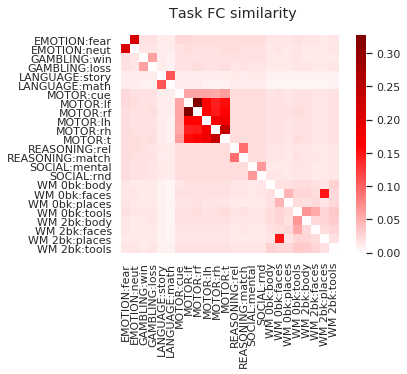

In [113]:
taskFCsim_bycond_bysubj=np.zeros((nConds, nConds, nSubjs))
scount = 0
for subj in subjNums:
    taskFCsim_bycond_bysubj[:,:,scount]=np.corrcoef(np.transpose(taskFC_mreg_bycond_bysubj[:,:,:,scount].reshape(nParcels*nParcels,nConds)))
    scount=scount+1

taskFCsim_bycond_mean=np.mean(taskFCsim_bycond_bysubj,axis=2)
np.fill_diagonal(taskFCsim_bycond_mean,0)
ax = sns.heatmap(taskFCsim_bycond_mean,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('Task FC similarity')
fig=ax.get_figure()
fig.savefig(figuredir+'taskFCsim_bycond_discovery176.pdf')

Text(0.5, 0.98, 'Task FC similarity, avg. first')

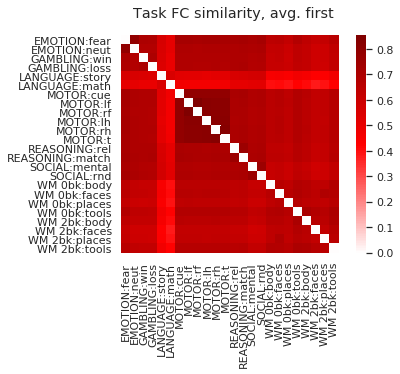

In [114]:

taskFCsim_bycond_avgfirst=np.corrcoef(np.transpose(np.mean(taskFC_mreg_bycond_bysubj,axis=3).reshape(nParcels*nParcels,nConds)))

np.fill_diagonal(taskFCsim_bycond_avgfirst,0)
ax = sns.heatmap(taskFCsim_bycond_avgfirst,center=0,cmap='seismic',cbar=True,yticklabels=taskConditions,xticklabels=taskConditions, square=True)
ax.figure.suptitle('Task FC similarity, avg. first')
#fig=ax.get_figure()
#fig.savefig('../figures/figure_parts/taskFCsim_bycond_discovery176.pdf')

In [115]:
#Compare taskFC generalization matrix to each of the others to infer likely cause of taskFC generalization

#Set up for removing diagonal
blankmat=np.ones((nConds,nConds))
upperTmat=np.triu(blankmat,k=1)
lowerTmat=np.tril(blankmat,k=-1)
offdiagmat_conds=(upperTmat+lowerTmat)>0


taskFCaccTOrestFCacc_bysubj=np.zeros((nSubjs))
scount = 0
for subj in subjNums:
    taskFCaccTOrestFCacc_bysubj[scount]=np.corrcoef(predaccs_byFCcond_byactcond_bysubj[:,:,scount][offdiagmat_conds],predaccsRestFC_byFCcond_byactcond_bysubj[:,:,scount][offdiagmat_conds])[0,1]
    scount=scount+1
print('taskFCaccTOrestFCacc_bysubj: r=',np.mean(taskFCaccTOrestFCacc_bysubj))

taskFCaccTOactsim_bysubj=np.zeros((nSubjs))
scount = 0
for subj in subjNums:
    taskFCaccTOactsim_bysubj[scount]=np.corrcoef(predaccs_byFCcond_byactcond_bysubj[:,:,scount][offdiagmat_conds],actsim_bycond_bysubj[:,:,scount][offdiagmat_conds])[0,1]
    scount=scount+1
print('taskFCaccTOactsim_bysubj: r=',np.mean(taskFCaccTOactsim_bysubj))
tstats = stats.ttest_1samp(taskFCaccTOactsim_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value vs. 0:', tstat)
print('p-value vs. 0:', pval)

taskFCaccTOtaskFCsim_bysubj=np.zeros((nSubjs))
scount = 0
for subj in subjNums:
    taskFCaccTOtaskFCsim_bysubj[scount]=np.corrcoef(predaccs_byFCcond_byactcond_bysubj[:,:,scount][offdiagmat_conds],taskFCsim_bycond_bysubj[:,:,scount][offdiagmat_conds])[0,1]
    scount=scount+1
print('taskFCaccTOtaskFCsim_bysubj: r=',np.mean(taskFCaccTOtaskFCsim_bysubj))
tstats = stats.ttest_1samp(taskFCaccTOtaskFCsim_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value vs. 0:', tstat)
print('p-value vs. 0:', pval)


taskFCaccTOrestFCacc_bysubj: r= 0.4991470600929351
taskFCaccTOactsim_bysubj: r= 0.607863648433976
t-value vs. 0: 95.48638529214321
p-value vs. 0: 6.878579886592626e-153
taskFCaccTOtaskFCsim_bysubj: r= 0.21144780699282492
t-value vs. 0: 38.639751801303944
p-value vs. 0: 1.3383304057929757e-87


In [116]:
print('Comparing actflow prediction for similar vs dissimilar task conditions (using activation similarity patterns):')
actsim_bycond_mean=np.mean(actsim_bycond_bysubj,axis=2)
np.fill_diagonal(actsim_bycond_mean,0)
pos_actsim_bycond_mean=actsim_bycond_mean>0
neg_actsim_bycond_mean=actsim_bycond_mean<0
predaccstaskVSrestFC_bycond_bysubj=predaccs_byFCcond_byactcond_bysubj-predaccsRestFC_byFCcond_byactcond_bysubj
predaccstaskVSrestFC_bycond_mean=np.mean(predaccstaskVSrestFC_bycond_bysubj,axis=2)
print('pos_actsim_bycond_mean: r=',np.tanh(np.mean(np.arctanh(predaccstaskVSrestFC_bycond_mean[pos_actsim_bycond_mean]))))
print('neg_actsim_bycond_mean: r=',np.tanh(np.mean(np.arctanh(predaccstaskVSrestFC_bycond_mean[neg_actsim_bycond_mean]))))
print('pos_actsim_bycond_mean - neg_actsim_bycond_mean: r-diff=',np.tanh(np.mean(np.arctanh(predaccstaskVSrestFC_bycond_mean[pos_actsim_bycond_mean])))-np.tanh(np.mean(np.arctanh(predaccstaskVSrestFC_bycond_mean[neg_actsim_bycond_mean]))))

pos_actsim_bysubj=np.zeros((nSubjs))
neg_actsim_bysubj=np.zeros((nSubjs))
scount = 0
for subj in subjNums:
    pos_actsim_bysubj[scount]=np.mean(np.arctanh(predaccstaskVSrestFC_bycond_bysubj[:,:,scount][pos_actsim_bycond_mean]))
    neg_actsim_bysubj[scount]=np.mean(np.arctanh(predaccstaskVSrestFC_bycond_bysubj[:,:,scount][neg_actsim_bycond_mean]))
    scount=scount+1

tstats = stats.ttest_1samp(pos_actsim_bysubj-neg_actsim_bysubj,0.0)
tstat=tstats[0]
pval=tstats[1]
print('t-value paired:', tstat)
print('p-value paired:', pval)

Comparing actflow prediction for similar vs dissimilar task conditions (using activation similarity patterns):
pos_actsim_bycond_mean: r= 0.04061270698722598
neg_actsim_bycond_mean: r= -0.04589371539465954
pos_actsim_bycond_mean - neg_actsim_bycond_mean: r-diff= 0.08650642238188552
t-value paired: 31.862339890244556
p-value paired: 9.177379368228011e-75


## Number of time points analysis

Plan: predict 8 WM task conditions only, using (rest or task-general) data of different lengths: 5min, 10min, 20min, 50min

In [117]:
#REST: 5, 10, 20, and 30 minutes
## Calculating multreg resting-state FC time-matched to task-general FC, CURRENT TASK HELD OUT, with SLURM cluster command (in parallel), loading from data if saved

durations_insecs=np.array((300, 600, 1200, 1800))
durations_inTRs=np.round(durations_insecs/.72)
nDurations=4

loaddata_ifavailable=True
datasuffix='_multregRestFC_5_10_20_30mins_data'

restFC_mreg_bydurations_bysubj=np.zeros((nParcels,nParcels,nDurations,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for durnum in np.arange(nDurations):
            dataid = 'condition' + str(durnum)
            restFC_mreg_bydurations_bysubj[:,:,durnum,scount] = h5f['restFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadRestResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
        file_python.write("print('Subject " + str(subj) + "')\n")
        
        file_python.write("restdata = loadRestResiduals_byscript.loadRestResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        #file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("durations_insecs=np.array((300, 600, 1200, 1800))\n")
        file_python.write("durations_inTRs=np.round(durations_insecs/.72).astype(int)\n")
        file_python.write("for durnum in np.arange(4):\n")
        file_python.write("    print(str(durnum))\n")
        file_python.write("    restFC_mreg_bysubj=actflow.connectivity_estimation.multregconn(restdata[:,0:durations_inTRs[durnum]])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'restFCRegression/' + 'condition' + str(durnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=restFC_mreg_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=nm3\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:05:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

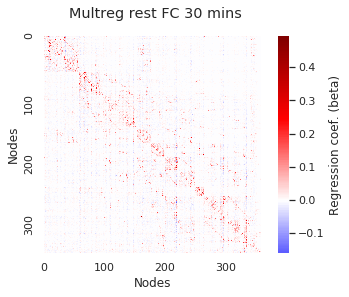

In [118]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(restFC_mreg_bydurations_bysubj[netorder,:,3,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg rest FC 30 mins')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [119]:
#Run actflow predictions, 24-condition resting-state FC, 5 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 5 min multiple-regression FC==")
actflowOutput_restFCMReg_5mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bydurations_bysubj[:,:,0,:], full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 5 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.36, t-value vs. 0: 74.85, p-value vs. 0: 7.931469751532154e-135
 
Mean % variance explained (R^2 score, coeff. of determination) = -2.71
 
Mean MAE (mean absolute error) = 21.28
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) 

In [120]:
#Run actflow predictions, 24-condition resting-state FC, 10 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 10 min multiple-regression FC==")
actflowOutput_restFCMReg_10mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bydurations_bysubj[:,:,1,:], full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 10 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.71, t-value vs. 0: 115.80, p-value vs. 0: 2.5569678238001405e-167
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.39
 
Mean MAE (mean absolute error) = 8.91
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large)

In [121]:
#Run actflow predictions, 24-condition resting-state FC, 20 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 20 min multiple-regression FC==")
actflowOutput_restFCMReg_20mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bydurations_bysubj[:,:,2,:], full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 20 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.83, t-value vs. 0: 142.39, p-value vs. 0: 7.265831352906432e-183
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.67
 
Mean MAE (mean absolute error) = 6.63
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) 

In [122]:
#Run actflow predictions, 24-condition resting-state FC, 30 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 30 min multiple-regression FC==")
actflowOutput_restFCMReg_30mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg_bydurations_bysubj[:,:,3,:], full_report=True)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24-conditions, 30 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.86, t-value vs. 0: 154.46, p-value vs. 0: 5.311056686344529e-189
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.73
 
Mean MAE (mean absolute error) = 5.98
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) 

In [123]:
#TASK-GENERAL: 5, 10, 20, and 30 minutes
## Calculating multreg resting-state FC time-matched to task-general FC, CURRENT TASK HELD OUT, with SLURM cluster command (in parallel), loading from data if saved

durations_insecs=np.array((300, 600, 1200, 1800))
durations_inTRs=np.round(durations_insecs/.72)
nDurations=4

loaddata_ifavailable=True
datasuffix='_multregTaskGenFC_5_10_20_30mins_data'

taskgenFC_mreg_bydurations_bysubj=np.zeros((nParcels,nParcels,nDurations,nSubjs))
job_sent_to_scheduler=False
import os
scount = 0
for subj in subjNums:
    #print('Subject ' + subj)
    file_path=resultsdir + subj + datasuffix + '.h5'
    if loaddata_ifavailable and os.path.exists(file_path):
        h5f = h5py.File(file_path,'r')
        for durnum in np.arange(nDurations):
            dataid = 'condition' + str(durnum)
            taskgenFC_mreg_bydurations_bysubj[:,:,durnum,scount] = h5f['taskFCRegression'][dataid][:]
        h5f.close()
    else:
        if job_sent_to_scheduler==False:
            job_sent_to_scheduler=True
            print('Sending job to SLURM scheduler')
        
        file_python = open("batchscripts/pythonscript_" + str(subj) + ".py", "w")
        file_python.write("import sys; sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/'); sys.path.insert(0, '" + basedir + "/docs/scripts/final_analyses/glmScripts/parcellated_postproc/')\n")
        file_python.write("import loadTaskResiduals_byscript; import taskGLMPipeline_withNuisanceReg_GlasserParcels as tgp; import h5py; import ActflowToolbox as actflow; import numpy as np\n")
 
        file_python.write("print('Subject " + str(subj) + "')\n")
        file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR_plus_canonical',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        #file_python.write("taskdata = loadTaskResiduals_byscript.loadTaskResiduals_byscript('" + str(subj) + "',model='24pXaCompCorXVolterra',taskModel='FIR',zscore=False,vertexVoxelWise=False, preprocdatadir_vertexwise='" + preprocdatadir_vertexwise + "', datadir='" + datadir + "')\n")
        file_python.write("tasktiming_bycond=tgp.loadTaskTimingForAllTasks('"+str(subj)+"',taskModel='canonical')['taskRegressors']>.5\n")
        #Restrict to the number of task time points
        #file_python.write("restdata = restdata[:,0:np.shape(tasktiming_bycond)[0]]\n")
        file_python.write("durations_insecs=np.array((300, 600, 1200, 1800))\n")
        file_python.write("durations_inTRs=np.round(durations_insecs/.72).astype(int)\n")
        file_python.write("for durnum in np.arange(4):\n")
        file_python.write("    print(str(durnum))\n")
        #file_python.write("    conds_other=np.arange(16)\n")
        #Including all tasks (even the one being predicted), since we want as much task data as possible
        file_python.write("    tasktiming=np.array(np.sum(tasktiming_bycond,axis=1)>0)\n")   
        #file_python.write("    tasktiming=np.array(np.sum(tasktiming_bycond[:,conds_other],axis=1)>0)\n")  
        file_python.write("    tasktiming_indices=np.array((np.where(tasktiming))).astype(int)\n")
        #Selecting task time points at random, to spread out influence of each task
        file_python.write("    tasktiming_indices=np.random.permutation(tasktiming_indices[0])\n")
        file_python.write("    tasktiming_mod=tasktiming.copy()\n")
        file_python.write("    tasktiming_mod[np.arange(np.shape(tasktiming_mod)[0])]=0\n")
        file_python.write("    tasktiming_mod[tasktiming_indices[np.arange(durations_inTRs[durnum])]]=1\n")
        file_python.write("    print(str(np.sum(tasktiming_mod)))\n")
        file_python.write("    taskFC_mreg_bysubj=actflow.connectivity_estimation.multregconn(taskdata[:,tasktiming_mod])\n")
        file_python.write("    #Save multiple-regression task FC data to file\n")
        file_python.write("    h5f = h5py.File('"+file_path+"','a')\n")
        file_python.write("    outname1 = 'taskFCRegression/' + 'condition' + str(durnum)\n")
        file_python.write("    try:\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bysubj)\n")
        file_python.write("    except:\n")
        file_python.write("        del h5f[outname1]\n")
        file_python.write("        h5f.create_dataset(outname1,data=taskFC_mreg_bysubj)\n")
        file_python.write("    h5f.close()")
        file_python.close()
                          
        
        file_slurm = open("batchscripts/slurmscript.sh", "w")
        file_slurm.write('#!/bin/bash\n')
        file_slurm.write('#SBATCH --partition=main\n')
        file_slurm.write('#SBATCH --job-name='+str(subj)+'\n')
        file_slurm.write('#SBATCH --requeue\n')
        file_slurm.write('#SBATCH --time=00:05:00\n')
        file_slurm.write('#SBATCH --nodes=1\n')
        file_slurm.write('#SBATCH --ntasks=1\n')
        file_slurm.write('#SBATCH --cpus-per-task=20\n')
        file_slurm.write('#SBATCH --mem=64000\n')
        file_slurm.write('#SBATCH --export=ALL\n')
        file_slurm.write("time python batchscripts/pythonscript_" + str(subj) + ".py\n")
        file_slurm.close()
        
        os.system("chmod 755 batchscripts/pythonscript_" + str(subj) + ".py")
        os.system("chmod 755 batchscripts/slurmscript.sh")
        os.system("sbatch batchscripts/slurmscript.sh")

    scount += 1
    
if job_sent_to_scheduler:
    print("***WAIT FOR SLURM JOBS TO FINISH, THEN RUN AGAIN TO LOAD DATA***")

[Text(80.90000000000006, 0.5, 'Nodes'), Text(0.5, 12.5, 'Nodes')]

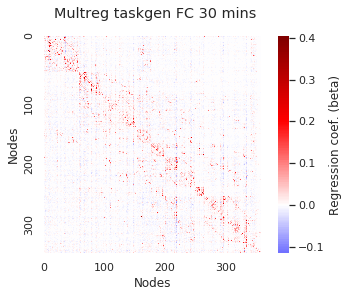

In [124]:
#Visualize FC matrix
ax = sns.heatmap(np.mean(taskgenFC_mreg_bydurations_bysubj[netorder,:,3,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=100,yticklabels=100, cbar_kws={'label': 'Regression coef. (beta)'})
ax.figure.suptitle('Multreg taskgen FC 30 mins')
ax.set(xlabel='Nodes',ylabel='Nodes')

In [125]:
#Run actflow predictions, 24-condition task-general FC, 5 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 5 min multiple-regression FC==")
actflowOutput_taskgenFCMReg_5mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bydurations_bysubj[:,:,0,:], full_report=True)


==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 5 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 86.66, p-value vs. 0: 1.131147112771684e-145
 
Mean % variance explained (R^2 score, coeff. of determination) = -1.53
 
Mean MAE (mean absolute error) = 17.44
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) t

In [126]:
#Run actflow predictions, 24-condition task-general FC, 10 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 10 min multiple-regression FC==")
actflowOutput_taskgenFCMReg_10mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bydurations_bysubj[:,:,1,:], full_report=True)


==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 10 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.83, t-value vs. 0: 133.22, p-value vs. 0: 7.534690384357665e-178
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.65
 
Mean MAE (mean absolute error) = 6.61
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) t

In [127]:
#Run actflow predictions, 24-condition task-general FC, 20 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 20 min multiple-regression FC==")
actflowOutput_taskgenFCMReg_20mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bydurations_bysubj[:,:,2,:], full_report=True)


==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 20 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.89, t-value vs. 0: 155.98, p-value vs. 0: 9.75346726426353e-190
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.79
 
Mean MAE (mean absolute error) = 5.10
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to

In [128]:
#Run actflow predictions, 24-condition task-general FC, 30 min multiple-regression FC
print("==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 30 min multiple-regression FC==")
actflowOutput_taskgenFCMReg_30mins_bycond = actflow.actflowcomp.actflowtest(activations_bycond, taskgenFC_mreg_bydurations_bysubj[:,:,3,:], full_report=True)


==Activity flow mapping results, multiple-regression-based task-general FC, 24-conditions, 30 min multiple-regression FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 176 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.91, t-value vs. 0: 162.25, p-value vs. 0: 1.0311219124198775e-192
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.83
 
Mean MAE (mean absolute error) = 4.69
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) 

### Visualize results

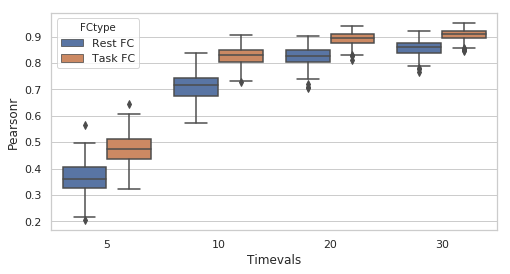

In [129]:
#Vizualize relative prediction accuracies, as a factor of time, r-values
import pandas as pd
#5, 10, 20, 30 mins; rest vs. task FC
#colnames=np.array(('GroupRest','GroupTask','IndivRest','IndivTask','IndivTaskRun'))
colnames=np.array(('Pearsonr','FCtype','Time','Timevals'))
corr_array_byactflowtype=np.concatenate((actflowOutput_restFCMReg_5mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_10mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_20mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_30mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_5mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_10mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_20mins_bycond['model_compare_output']['corr_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_30mins_bycond['model_compare_output']['corr_fullcomp_compthenavg']))
analysistype_array=np.concatenate((np.repeat('Rest FC',4*nSubjs), np.repeat('Task FC',4*nSubjs)))
analysistype_series=pd.Series(analysistype_array, dtype="category")
amounttime_array=np.concatenate((np.repeat('5 min',nSubjs), np.repeat('10 min',nSubjs), np.repeat('20 min',nSubjs),
                                np.repeat('30 min',nSubjs), np.repeat('5 min',nSubjs), np.repeat('10 min',nSubjs),
                                np.repeat('20 min',nSubjs), np.repeat('30 min',nSubjs)))
amounttime_series=pd.Series(amounttime_array, dtype="category")
amounttimevals_array=np.concatenate((np.repeat(5,nSubjs), np.repeat(10,nSubjs), np.repeat(20,nSubjs),
                                np.repeat(30,nSubjs), np.repeat(5,nSubjs), np.repeat(10,nSubjs),
                                np.repeat(20,nSubjs), np.repeat(30,nSubjs)))
amounttimevals_series=pd.Series(amounttimevals_array, dtype="category")
subjnums_array=np.concatenate((np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),
                              np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs)))
df_actflowpreds = pd.DataFrame(np.vstack((corr_array_byactflowtype,analysistype_series,amounttime_series,amounttimevals_series)).T, index=subjnums_array, columns=colnames)
df_actflowpreds['FCtype']=df_actflowpreds['FCtype'].astype('category')
df_actflowpreds['Time']=df_actflowpreds['Time'].astype('category')
df_actflowpreds['Pearsonr']=df_actflowpreds['Pearsonr'].astype('float')
df_actflowpreds=df_actflowpreds.sort_values('Timevals')
df_actflowpreds_rvals=df_actflowpreds.copy()
fig = plt.figure(figsize=[8,4])
ax = sns.boxplot(y='Pearsonr',x='Timevals',data=df_actflowpreds,hue='FCtype')
#ax = sns.catplot(y='Pearson r',x='Timevals',data=df_actflowpreds,hue='FC type',kind="point",capsize=.2)
fig.savefig(figuredir+'amounttimeFC_PearsonR_MultregFC_discovery176.pdf')

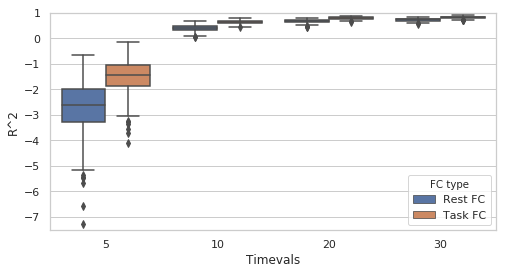

In [130]:
#Vizualize relative prediction accuracies, as a factor of time, r-values
import pandas as pd
#5, 10, 20, 30 mins; rest vs. task FC
#colnames=np.array(('GroupRest','GroupTask','IndivRest','IndivTask','IndivTaskRun'))
colnames=np.array(('R^2','FC type','Time','Timevals'))
corr_array_byactflowtype=np.concatenate((actflowOutput_restFCMReg_5mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_10mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_20mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_30mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_5mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_10mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_20mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_30mins_bycond['model_compare_output']['R2_fullcomp_compthenavg']))
analysistype_array=np.concatenate((np.repeat('Rest FC',4*nSubjs), np.repeat('Task FC',4*nSubjs)))
analysistype_series=pd.Series(analysistype_array, dtype="category")
amounttime_array=np.concatenate((np.repeat('5 min',nSubjs), np.repeat('10 min',nSubjs), np.repeat('20 min',nSubjs),
                                np.repeat('30 min',nSubjs), np.repeat('5 min',nSubjs), np.repeat('10 min',nSubjs),
                                np.repeat('20 min',nSubjs), np.repeat('30 min',nSubjs)))
amounttime_series=pd.Series(amounttime_array, dtype="category")
amounttimevals_array=np.concatenate((np.repeat(5,nSubjs), np.repeat(10,nSubjs), np.repeat(20,nSubjs),
                                np.repeat(30,nSubjs), np.repeat(5,nSubjs), np.repeat(10,nSubjs),
                                np.repeat(20,nSubjs), np.repeat(30,nSubjs)))
amounttimevals_series=pd.Series(amounttimevals_array, dtype="category")
subjnums_array=np.concatenate((np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),
                              np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs)))
df_actflowpreds = pd.DataFrame(np.vstack((corr_array_byactflowtype,analysistype_series,amounttime_series,amounttimevals_series)).T, index=subjnums_array, columns=colnames)
df_actflowpreds['FC type']=df_actflowpreds['FC type'].astype('category')
df_actflowpreds['Time']=df_actflowpreds['Time'].astype('category')
df_actflowpreds['R^2']=df_actflowpreds['R^2'].astype('float')
df_actflowpreds=df_actflowpreds.sort_values('Timevals')
fig = plt.figure(figsize=[8,4])
ax = sns.boxplot(y='R^2',x='Timevals',data=df_actflowpreds,hue='FC type')
ax.set(ylim=(np.min(np.min(df_actflowpreds['R^2']))-.25, 1))
#ax = sns.catplot(y='Pearson r',x='Timevals',data=df_actflowpreds,hue='FC type',kind="point",capsize=.2)
fig.savefig(figuredir+'amounttimeFC_Rsq_MultregFC_discovery176.pdf')

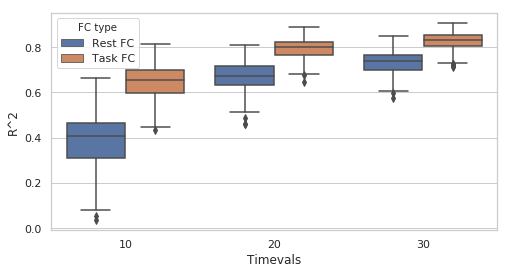

In [131]:
#Vizualize relative prediction accuracies, as a factor of time, r-values
import pandas as pd
#5, 10, 20, 30 mins; rest vs. task FC
#colnames=np.array(('GroupRest','GroupTask','IndivRest','IndivTask','IndivTaskRun'))
colnames=np.array(('R^2','FC type','Time','Timevals'))
corr_array_byactflowtype=np.concatenate((actflowOutput_restFCMReg_10mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_20mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_restFCMReg_30mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_10mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_20mins_bycond['model_compare_output']['R2_fullcomp_compthenavg'],
                                  actflowOutput_taskgenFCMReg_30mins_bycond['model_compare_output']['R2_fullcomp_compthenavg']))
analysistype_array=np.concatenate((np.repeat('Rest FC',3*nSubjs), np.repeat('Task FC',3*nSubjs)))
analysistype_series=pd.Series(analysistype_array, dtype="category")
amounttime_array=np.concatenate((np.repeat('10 min',nSubjs), np.repeat('20 min',nSubjs),
                                np.repeat('30 min',nSubjs), np.repeat('10 min',nSubjs),
                                np.repeat('20 min',nSubjs), np.repeat('30 min',nSubjs)))
amounttime_series=pd.Series(amounttime_array, dtype="category")
amounttimevals_array=np.concatenate((np.repeat(10,nSubjs), np.repeat(20,nSubjs),
                                np.repeat(30,nSubjs), np.repeat(10,nSubjs),
                                np.repeat(20,nSubjs), np.repeat(30,nSubjs)))
amounttimevals_series=pd.Series(amounttimevals_array, dtype="category")
subjnums_array=np.concatenate((np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs),
                              np.arange(nSubjs),np.arange(nSubjs),np.arange(nSubjs)))
df_actflowpreds = pd.DataFrame(np.vstack((corr_array_byactflowtype,analysistype_series,amounttime_series,amounttimevals_series)).T, index=subjnums_array, columns=colnames)
df_actflowpreds['FC type']=df_actflowpreds['FC type'].astype('category')
df_actflowpreds['Time']=df_actflowpreds['Time'].astype('category')
df_actflowpreds['R^2']=df_actflowpreds['R^2'].astype('float')
df_actflowpreds=df_actflowpreds.sort_values('Timevals')
fig = plt.figure(figsize=[8,4])
ax = sns.boxplot(y='R^2',x='Timevals',data=df_actflowpreds,hue='FC type')
#ax = sns.catplot(y='Pearson r',x='Timevals',data=df_actflowpreds,hue='FC type',kind="point",capsize=.2)
fig.savefig(figuredir+'amounttimeFC_Rsq_no5min_MultregFC_discovery176.pdf')

### Comparing conditions

In [132]:
#ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_actflowpreds_rvals_lm=ols('Pearsonr ~ C(Timevals) + C(FCtype) + C(Timevals)*C(FCtype)', data=df_actflowpreds_rvals).fit() 
print(sm.stats.anova_lm(df_actflowpreds_rvals_lm, typ=2))

                          sum_sq      df            F         PR(>F)
C(Timevals)            48.634868     3.0  9020.632485   0.000000e+00
C(FCtype)               2.603230     1.0  1448.514991  3.404206e-218
C(Timevals):C(FCtype)   0.248911     3.0    46.167196   1.890488e-28
Residual                2.516040  1400.0          NaN            NaN


In [133]:
#Task vs. rest T-tests
print('Task vs. rest FC actflow predictions')
for timev in np.array((5,10,20,30)):
    print('Time:', str(timev), 'min')
    restFC5Min=df_actflowpreds_rvals[(df_actflowpreds_rvals['Timevals']==timev) & (df_actflowpreds_rvals['FCtype']=='Rest FC')]
    taskFC5Min=df_actflowpreds_rvals[(df_actflowpreds_rvals['Timevals']==timev) & (df_actflowpreds_rvals['FCtype']=='Task FC')]

    ttest_vals=stats.ttest_1samp(taskFC5Min['Pearsonr']-restFC5Min['Pearsonr'],0.0)
    print(ttest_vals)

Task vs. rest FC actflow predictions
Time: 5 min
Ttest_1sampResult(statistic=23.743499711544768, pvalue=1.2878092306304326e-56)
Time: 10 min
Ttest_1sampResult(statistic=48.797111589553325, pvalue=7.887233721889665e-104)
Time: 20 min
Ttest_1sampResult(statistic=45.179913414207626, pvalue=2.0993105578507104e-98)
Time: 30 min
Ttest_1sampResult(statistic=46.19464224985543, pvalue=5.805713208576939e-100)
